In [1]:
!pip install segmentation-models-pytorch
!pip install wandb
!pip install albumentations

  Obtaining dependency information for segmentation-models-pytorch from https://files.pythonhosted.org/packages/54/dd/0a3417eebc791d1f60ba9949a2c6fcb406ba671c67042179fb270409b17b/segmentation_models_pytorch-0.3.4-py3-none-any.whl.metadata
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for huggingface-hub>=0.24.6 from https://files.pythonhosted.org/packages/60/bf/cea0b9720c32fa01b0c4ec4b16b9f4ae34ca106b202ebbae9f03ab98cd8f/huggingface_hub-0.26.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for timm==0.9.7 from https://files.pythonhosted.org/packages/7a/bd/2c56be7a3b5bc71cf85a405246b89d5359f942c9f7fb6db6306d9d056092/timm-0.9.7-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.9 MB/s eta 0:00:00
  Obtaining dependency information for munch from https://files.pythonhosted.org/packages/56/b3

In [2]:
import os
import pandas as pd
import numpy as np
import cv2
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, random_split, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torchvision.transforms import ToTensor
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchinfo import summary
import timm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
!nvidia-smi

Sun Nov 24 01:14:30 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, label_dir, resize=None, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.resize = resize
        self.transform = transform
        self.images = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.images)

    def read_mask(self, mask_path):
        image = cv2.imread(mask_path)
        image = cv2.resize(image, self.resize)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        lower1 = np.array([0, 100, 20])
        upper1 = np.array([10, 255, 255])

        lower2 = np.array([160,100,20])
        upper2 = np.array([179,255,255])
        lower_mask = cv2.inRange(image, lower1, upper1)
        upper_mask = cv2.inRange(image, lower2, upper2)

        red_mask = lower_mask + upper_mask;
        red_mask[red_mask != 0] = 1

        green_mask = cv2.inRange(image, (36, 25, 25), (70, 255, 255))
        green_mask[green_mask != 0] = 2

        full_mask = cv2.bitwise_or(red_mask, green_mask)
        full_mask = np.expand_dims(full_mask, axis=-1)
        full_mask = full_mask.astype(np.uint8)

        return full_mask

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.read_mask(label_path)
        image = cv2.resize(image, self.resize)
        if self.transform:
            image = self.transform(image)

        return image, label

    def show_image(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = plt.imread(img_path)
        label = plt.imread(label_path)
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image)
        axs[0].set_title('Image')
        axs[1].imshow(label)
        axs[1].set_title('Label')
        plt.show()

In [5]:
image_path = []
TRAIN_DIR = '/kaggle/input/bkai-igh-neopolyp/train/train'
for root, dirs, files in os.walk(TRAIN_DIR):
    for file in files:
        path = os.path.join(root,file)
        image_path.append(path)

len(image_path)

1000

In [6]:
mask_path = []
TRAIN_MASK_DIR = '/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt'
for root, dirs, files in os.walk(TRAIN_MASK_DIR):
    for file in files:
        path = os.path.join(root,file)
        mask_path.append(path)

len(mask_path)

1000

In [7]:
dataset = CustomImageDataset(img_dir = TRAIN_DIR, label_dir = TRAIN_MASK_DIR, resize= (256,256), transform = None)

In [8]:
model = smp.UnetPlusPlus(encoder_name="efficientnet-b7", encoder_weights="imagenet", in_channels=3, classes=3)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:01<00:00, 203MB/s]  


In [9]:
batch_size = 8
images_data = []
labels_data = []
for x,y in dataset:
    images_data.append(x)
    labels_data.append(y)

In [10]:
class CustomDataset(CustomImageDataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __getitem__(self, index):
        image = self.data[index]
        label = self.targets[index]
        if self.transform:
            transformed = self.transform(image=image, mask=label)
            image = transformed['image'].float()
            label = transformed['mask'].float()
            label = label.permute(2, 0, 1)
        return image, label

    def __len__(self):
        return len(self.data)


train_transform = A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), A.RandomBrightnessContrast(p=0.2), A.GaussNoise(p=0.2),
                             A.Rotate(limit=30, p=0.3), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2(),])

val_transform = A.Compose([A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)), ToTensorV2(),])

train_size = int(0.9 * len(images_data))
val_size = len(images_data) - train_size
train_dataset = CustomDataset(images_data[:train_size], labels_data[:train_size], transform=train_transform)
val_dataset = CustomDataset(images_data[train_size:], labels_data[train_size:], transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
print(len(train_dataset))
print(len(val_dataset))

900
100


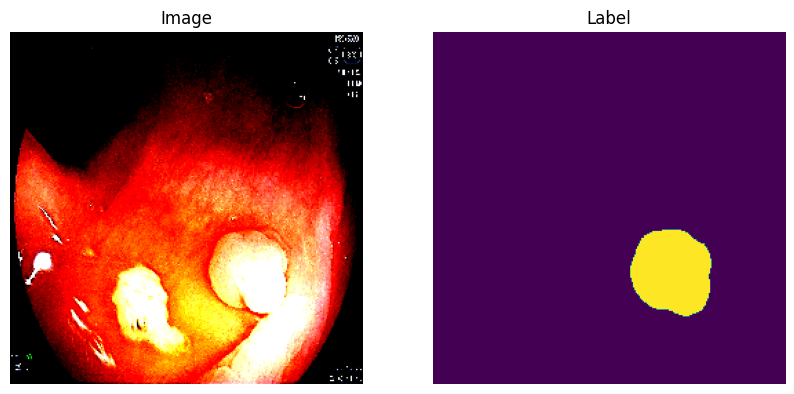

In [11]:
image, label = train_dataset[2]

label_array = label.permute(1, 2, 0).numpy()
image_array = image.permute(1, 2, 0).numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image_array)
axs[0].set_title('Image')
axs[0].axis('off')

axs[1].imshow(label_array)
axs[1].set_title('Label')
axs[1].axis('off')

plt.show()

In [12]:
learning_rate = 0.0001
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [13]:
color_dict= {0: (0, 0, 0), 1: (255, 0, 0), 2: (0, 255, 0)}
def mask_to_rgb(mask, color_dict):
    output = np.zeros((mask.shape[0], mask.shape[1], 3))

    for k in color_dict.keys():
        output[mask==k] = color_dict[k]

    return np.uint8(output)

In [14]:
import wandb

!wandb login 'dda4940ec41671d447ffde4115dbaaa410fea9ed'


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [15]:
wandb.init(project = 'unet model', resume = 'allow')  

wandb: Currently logged in as: whattonname (whattonname-hanoi-university-of-science-and-technology). Use `wandb login --relogin` to force relogin


Epoch [1/300], Loss: 0.5197765483
Save new model


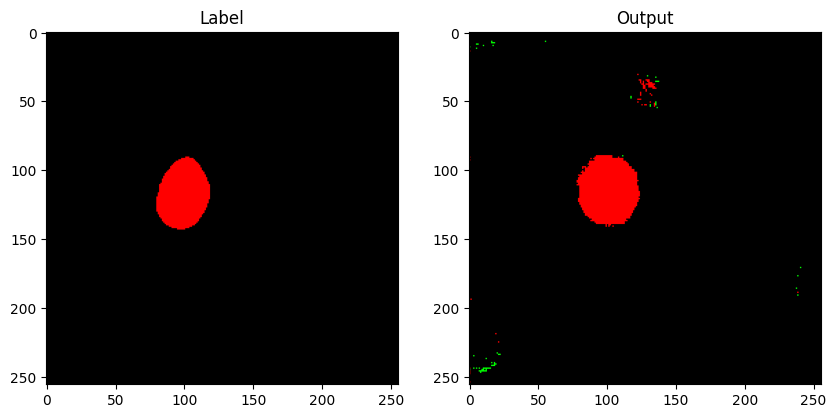

Epoch [2/300], Loss: 0.3763623753
Save new model


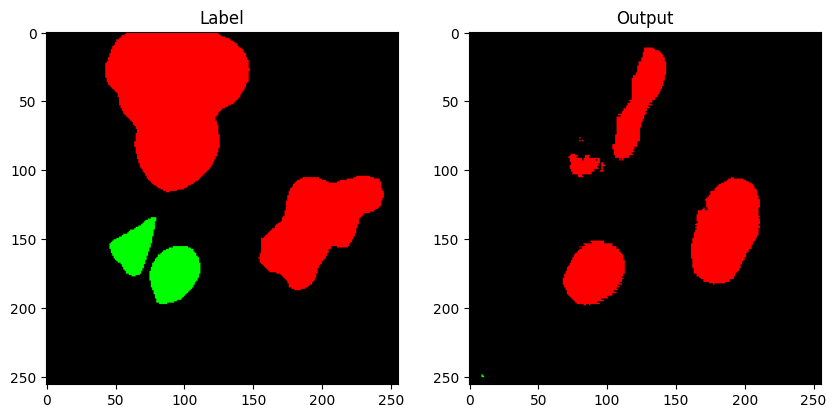

Epoch [3/300], Loss: 0.3073537464
Save new model


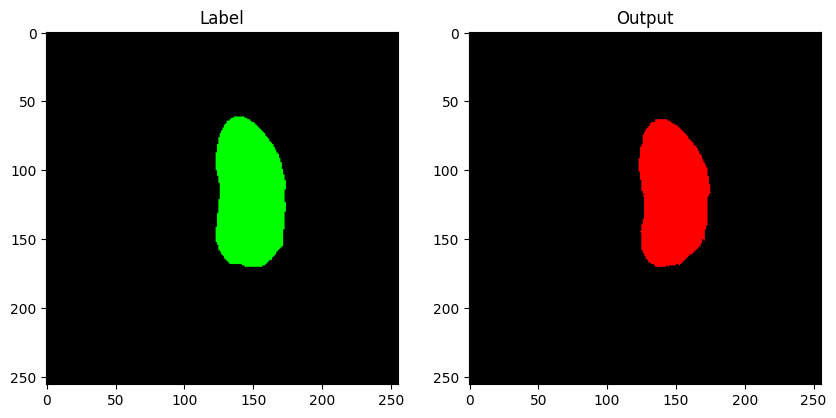

Epoch [4/300], Loss: 0.2441963167
Save new model


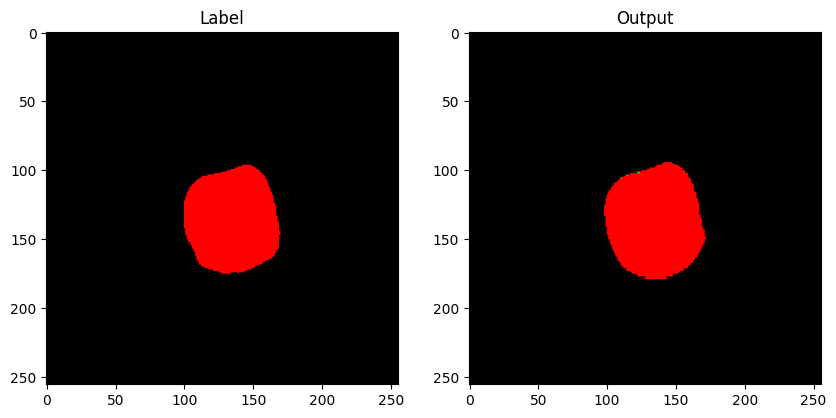

Epoch [5/300], Loss: 0.2263256816
Save new model


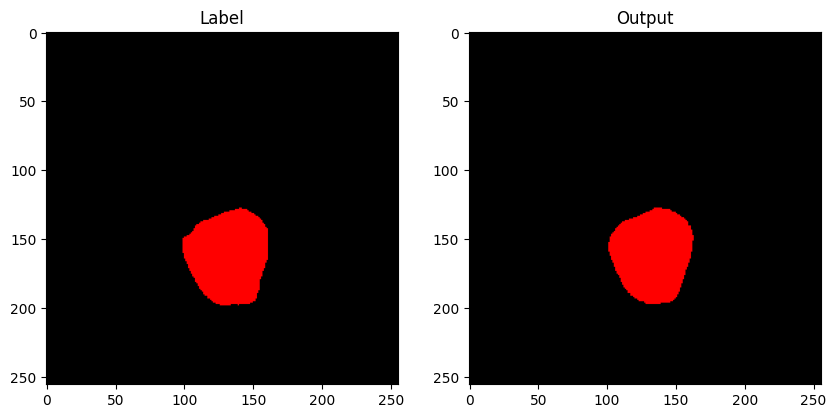

Epoch [6/300], Loss: 0.2100120955
Save new model


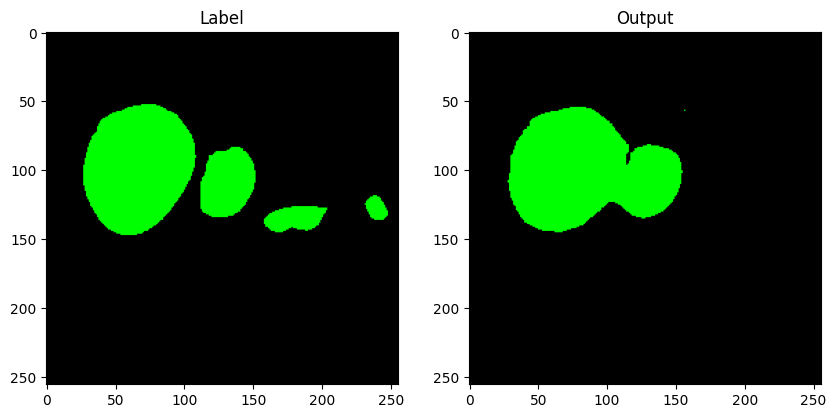

Epoch [7/300], Loss: 0.1858434150
Save new model


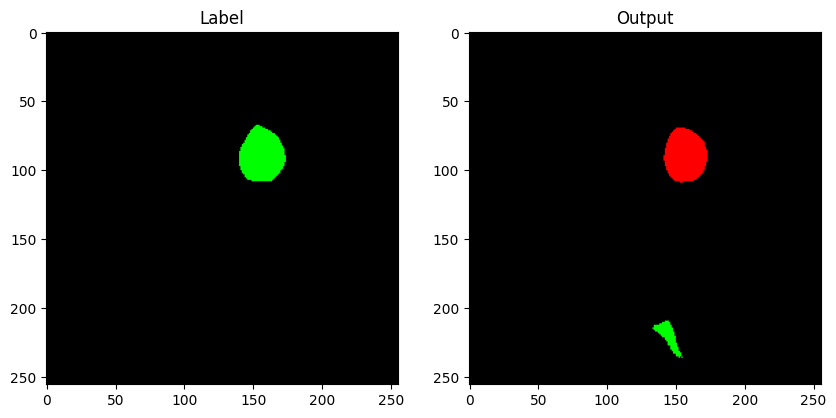

Epoch [8/300], Loss: 0.1593099553
Save new model


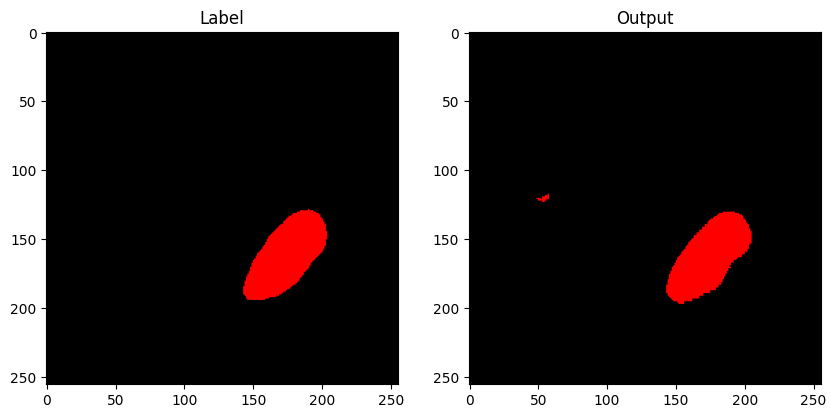

Epoch [9/300], Loss: 0.1844507914


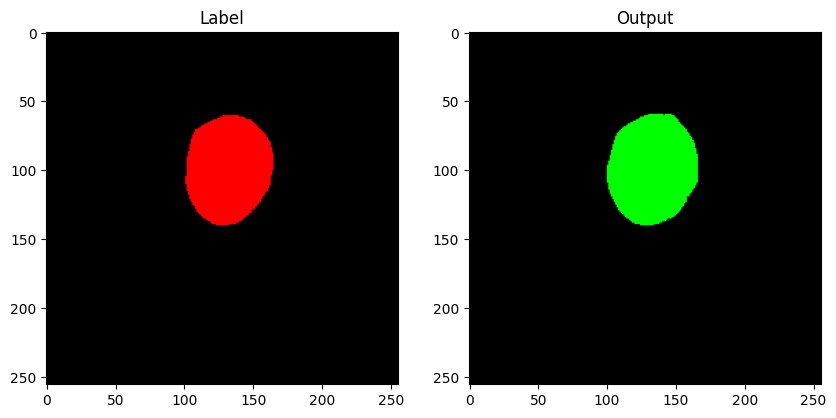

Epoch [10/300], Loss: 0.1692890147


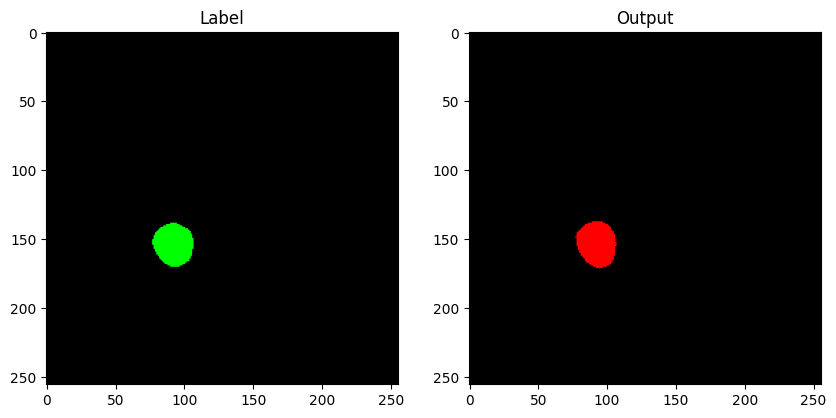

Epoch [11/300], Loss: 0.1651538516


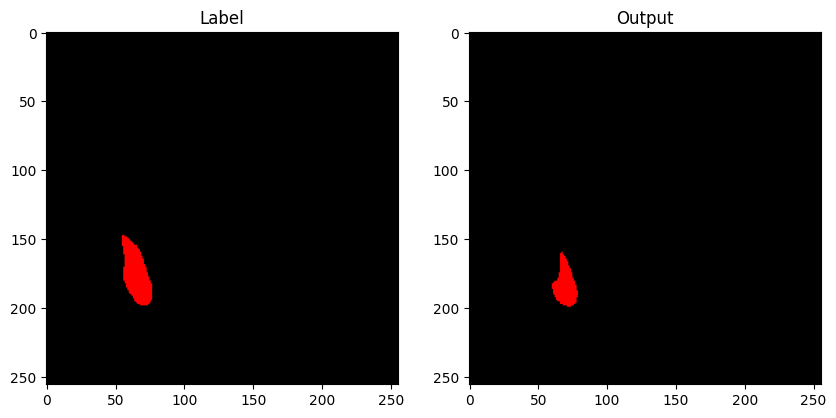

Epoch [12/300], Loss: 0.1659021891


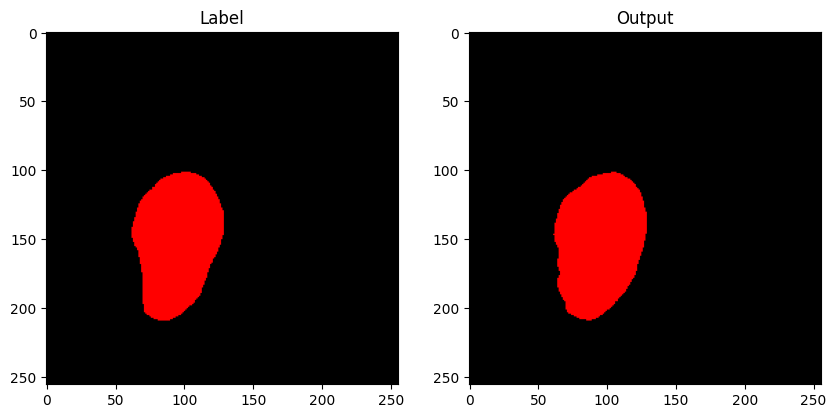

Epoch [13/300], Loss: 0.1472262127
Save new model


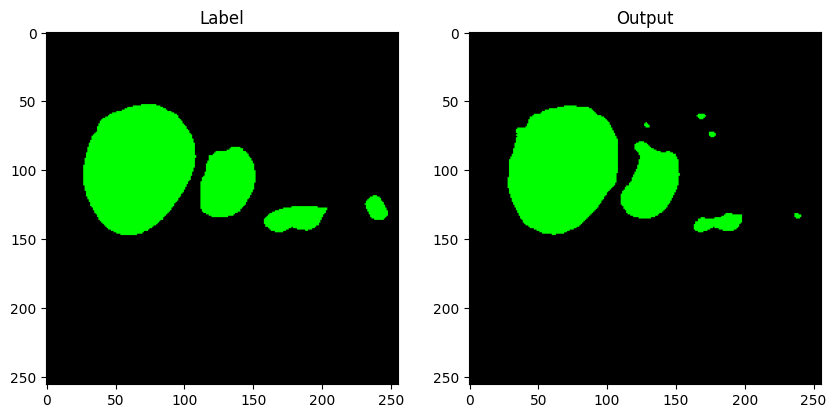

Epoch [14/300], Loss: 0.1523943973


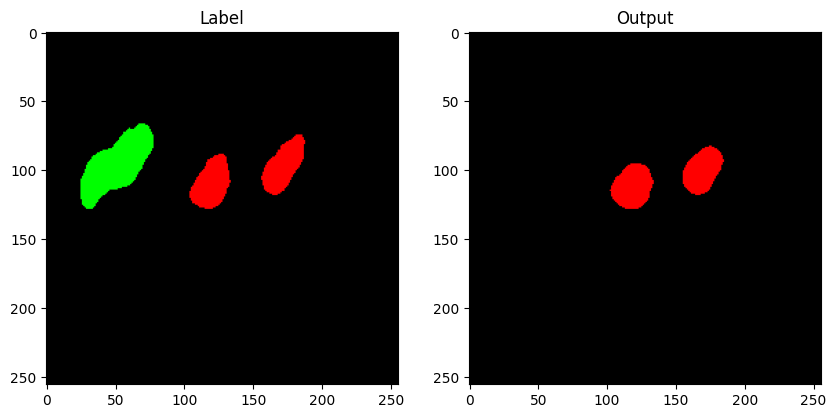

Epoch [15/300], Loss: 0.1526510091


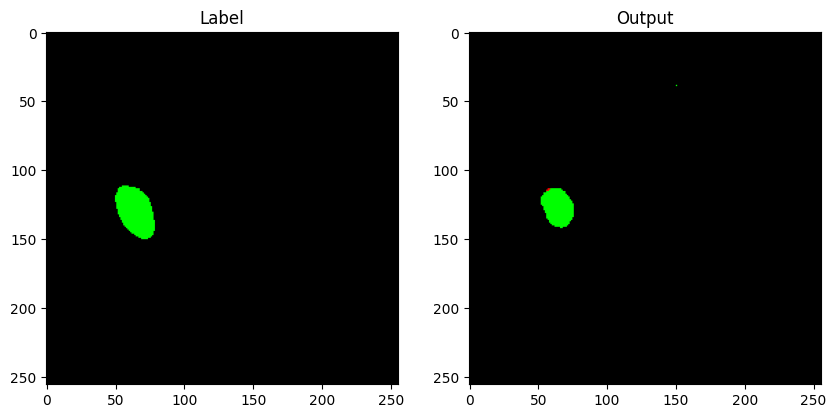

Epoch [16/300], Loss: 0.1850173611


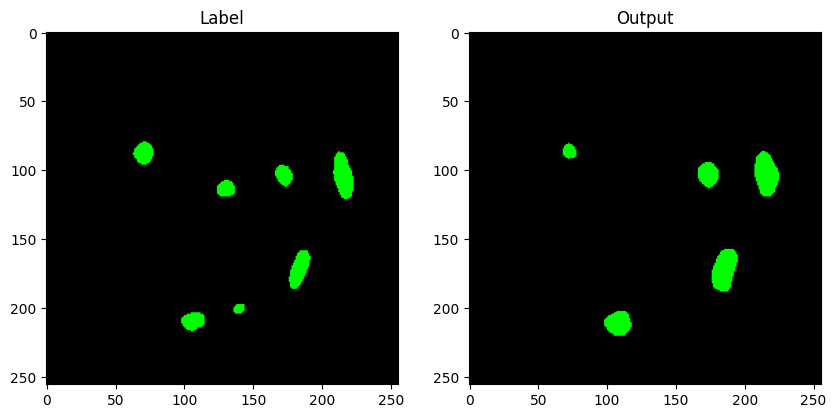

Epoch [17/300], Loss: 0.1395271624
Save new model


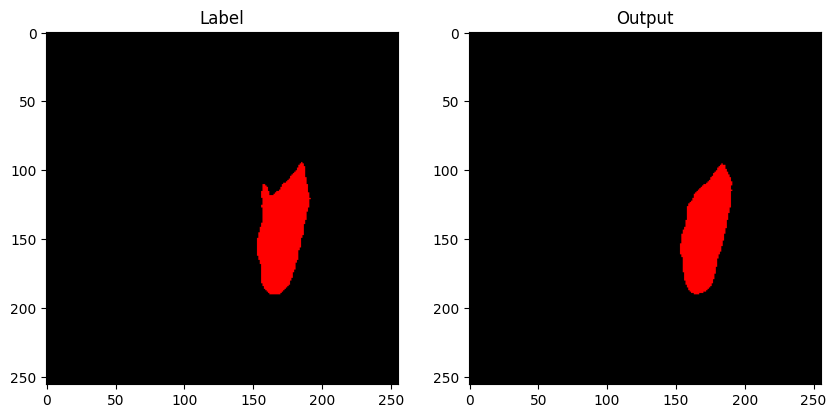

Epoch [18/300], Loss: 0.1584549377


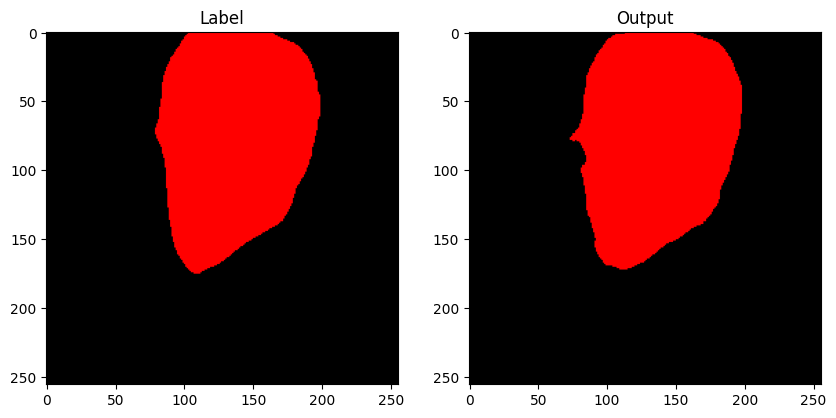

Epoch [19/300], Loss: 0.1605965103


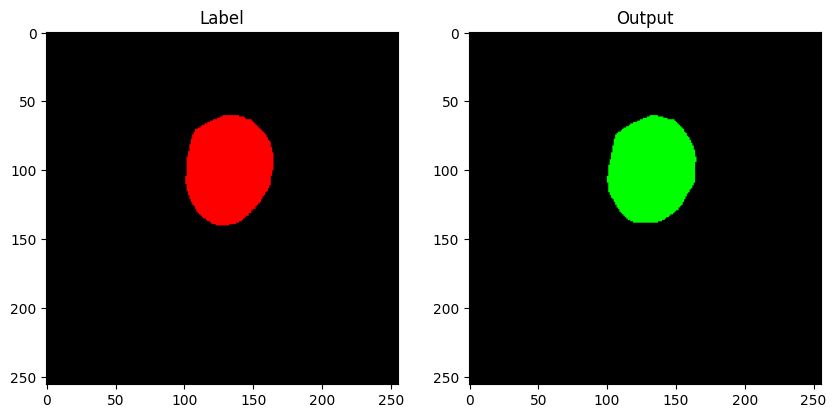

Epoch [20/300], Loss: 0.1406151202


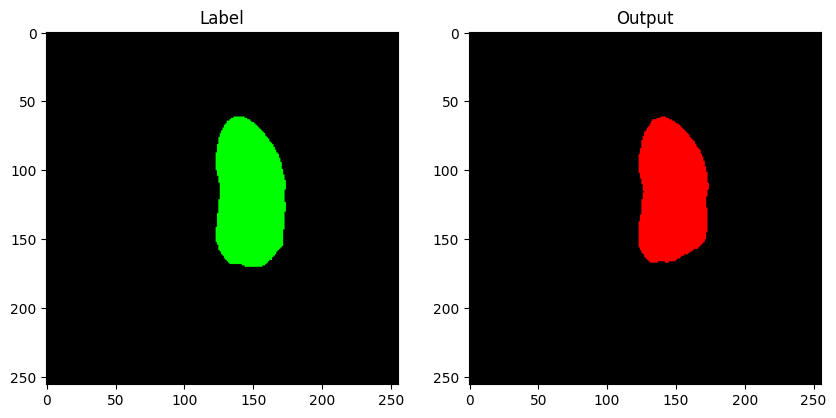

Epoch [21/300], Loss: 0.1435697468


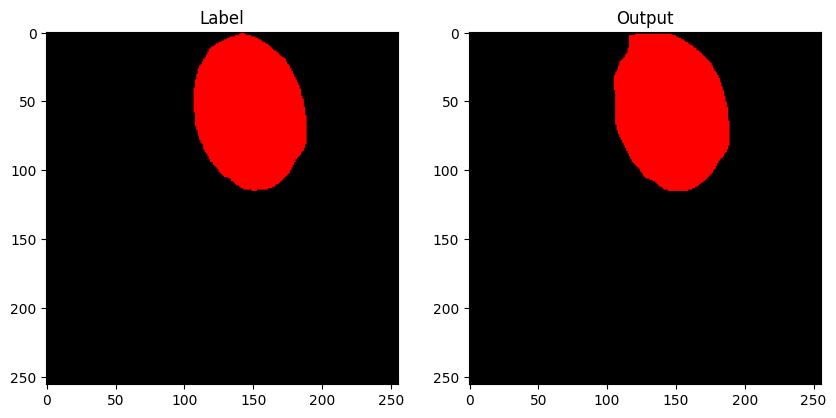

Epoch [22/300], Loss: 0.1341098960
Save new model


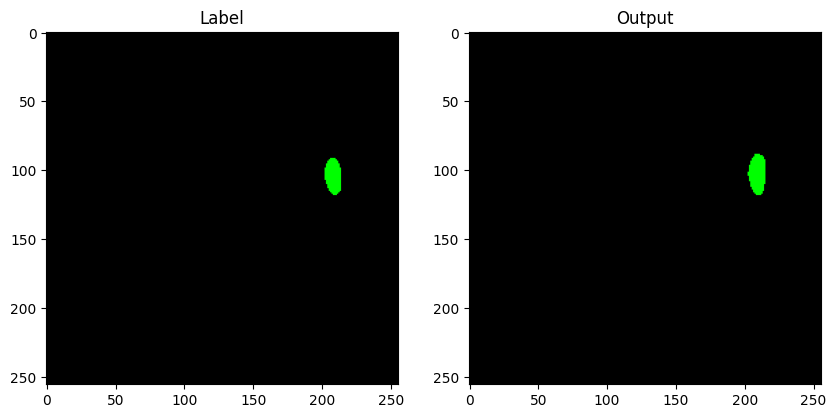

Epoch [23/300], Loss: 0.1401068413


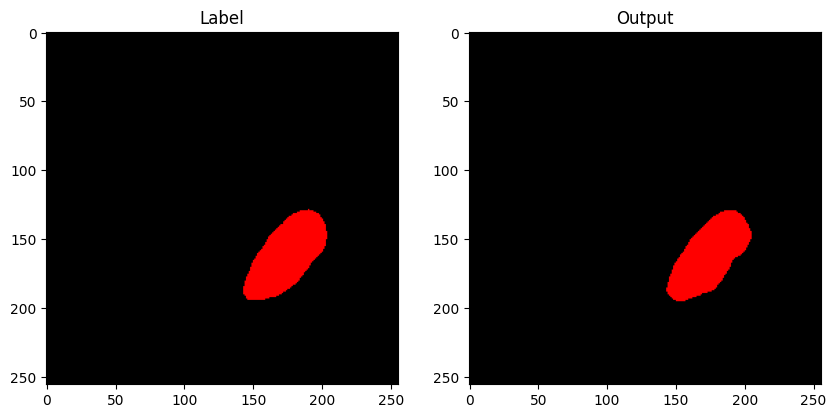

Epoch [24/300], Loss: 0.1150995547
Save new model


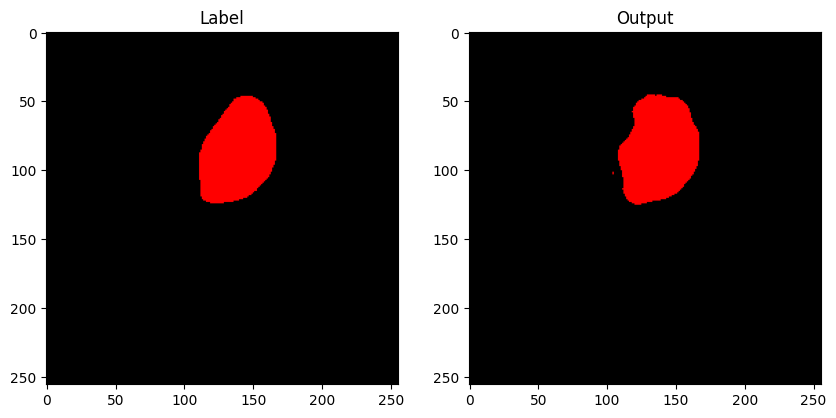

Epoch [25/300], Loss: 0.1416667625


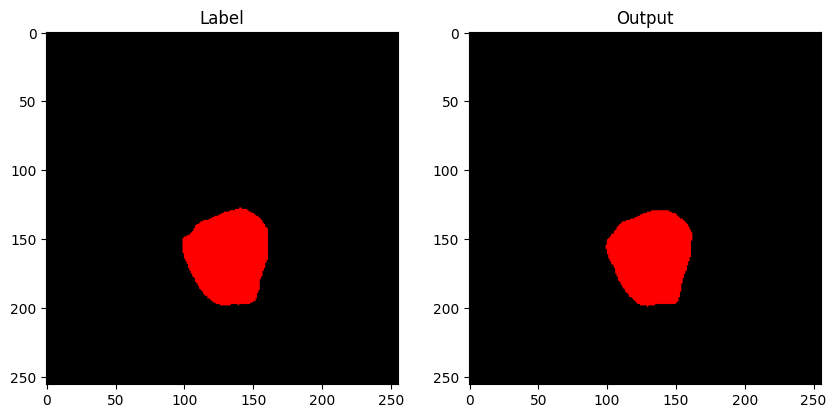

Epoch [26/300], Loss: 0.1755853129


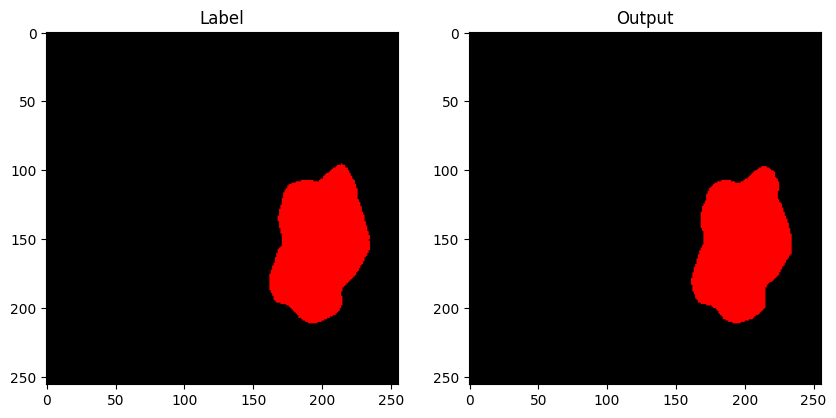

Epoch [27/300], Loss: 0.1453665842


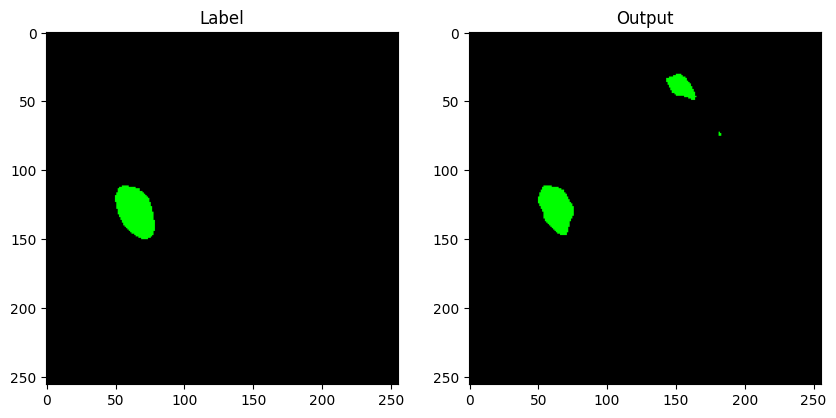

Epoch [28/300], Loss: 0.1511697139


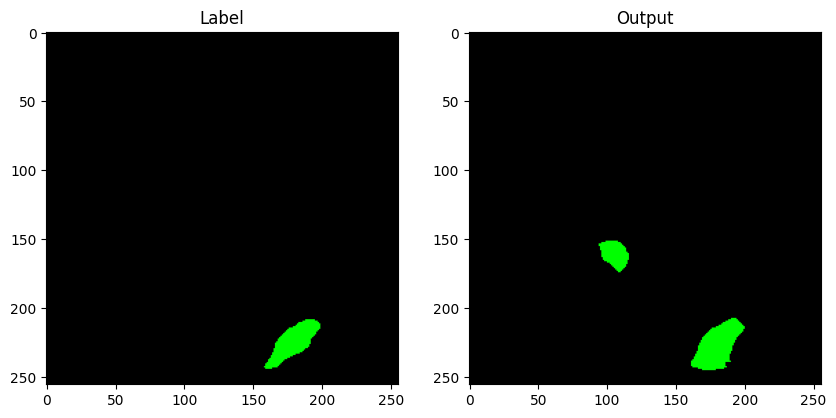

Epoch [29/300], Loss: 0.1619113129


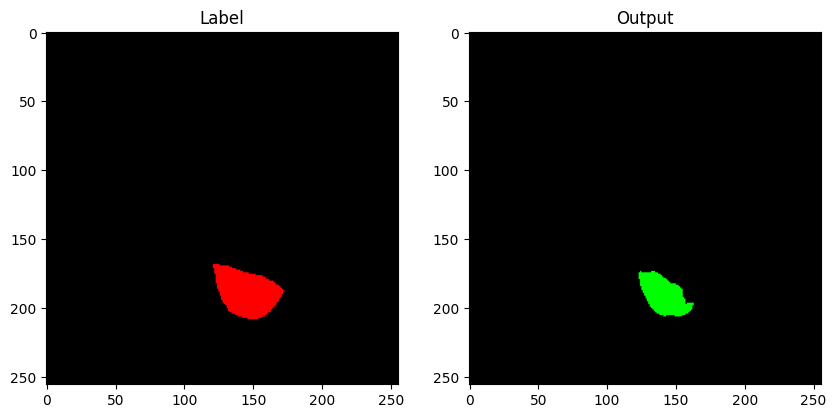

Epoch [30/300], Loss: 0.1669170123


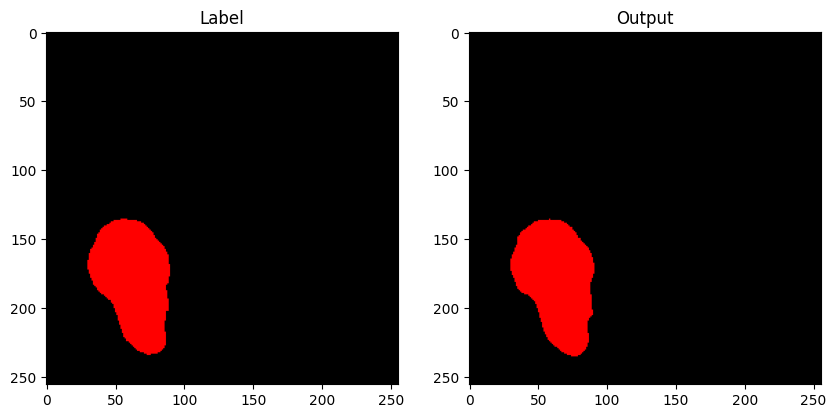

Epoch [31/300], Loss: 0.1518680069


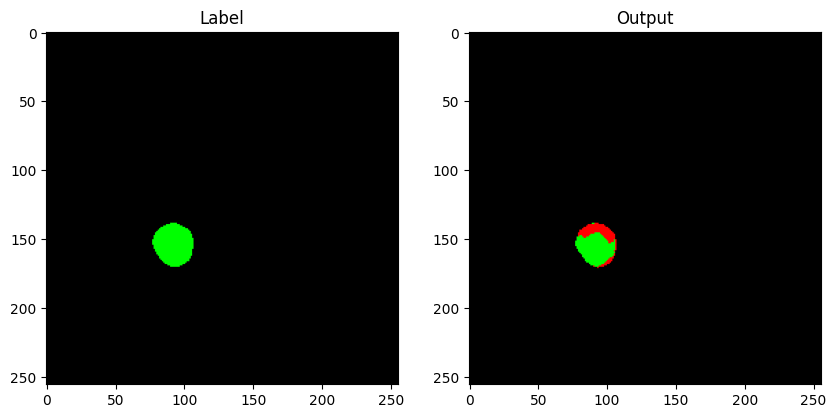

Epoch [32/300], Loss: 0.1424108964


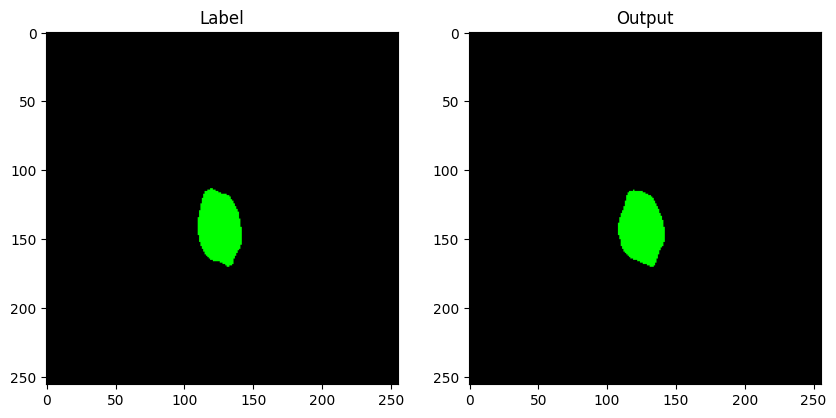

Epoch [33/300], Loss: 0.1525374860


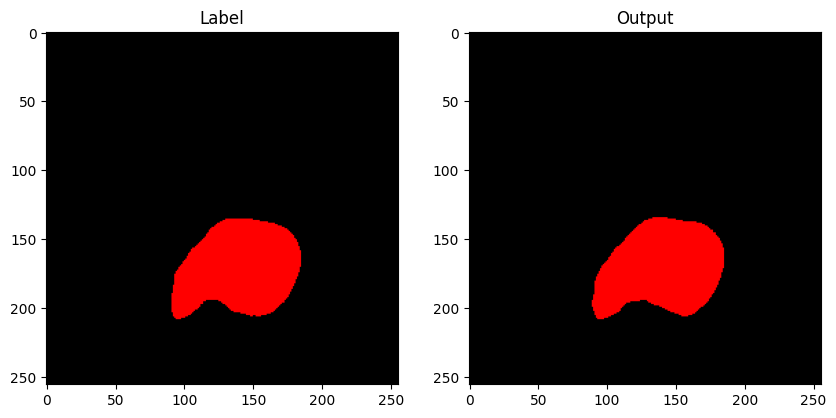

Epoch [34/300], Loss: 0.1514874582


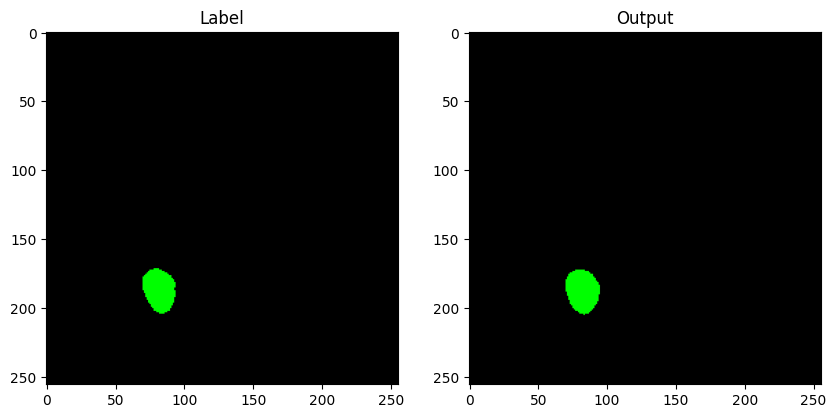

Epoch [35/300], Loss: 0.1441927326


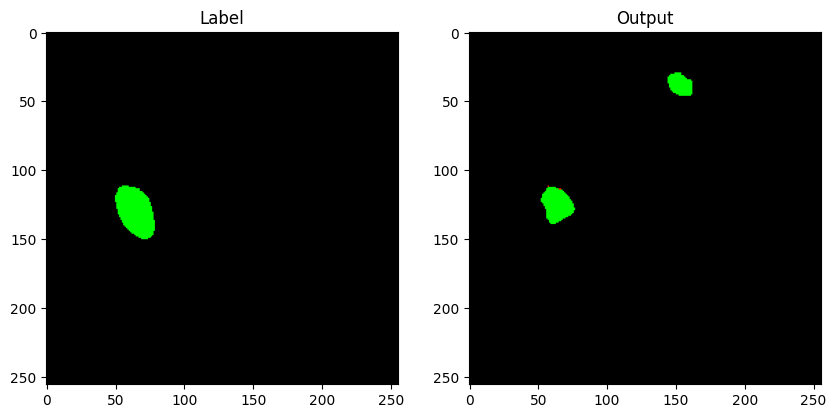

Epoch [36/300], Loss: 0.1397920540


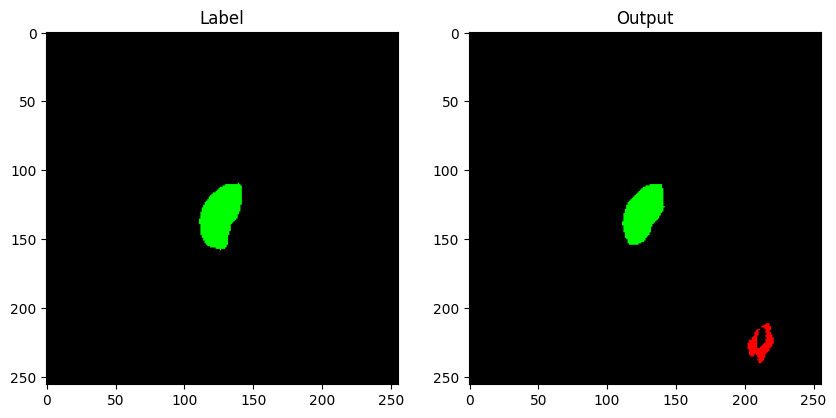

Epoch [37/300], Loss: 0.1310870986


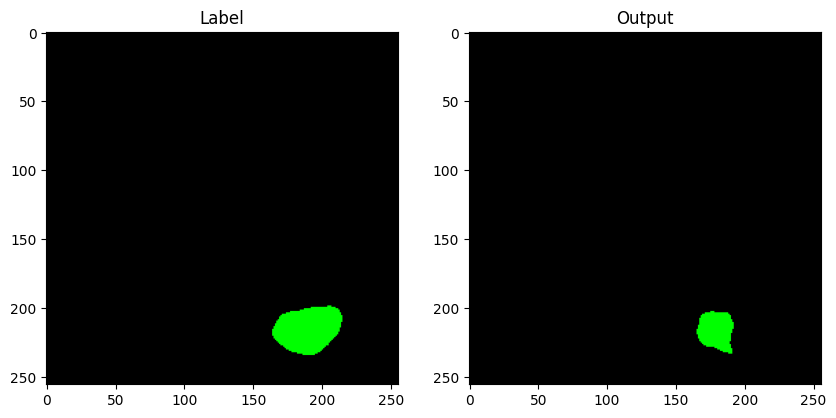

Epoch [38/300], Loss: 0.1589689424


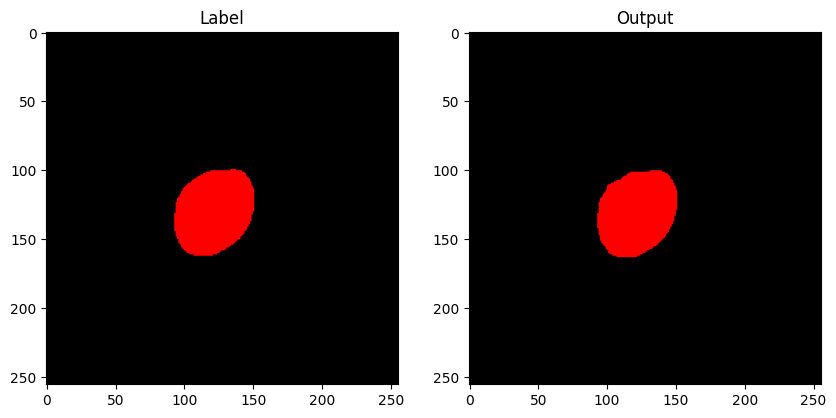

Epoch [39/300], Loss: 0.1552580030


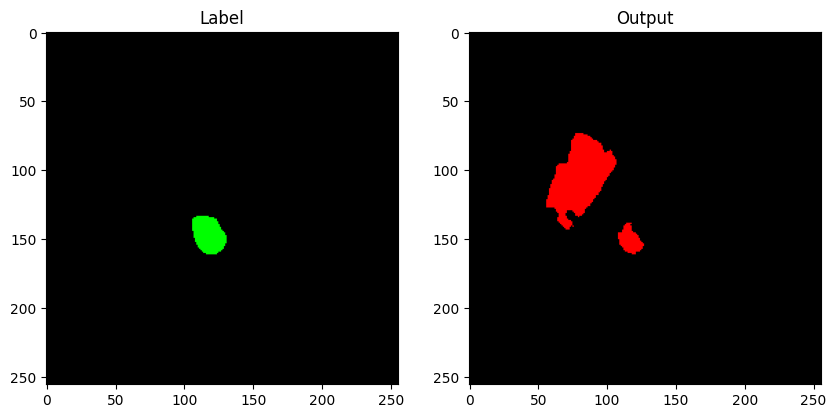

Epoch [40/300], Loss: 0.1464621608


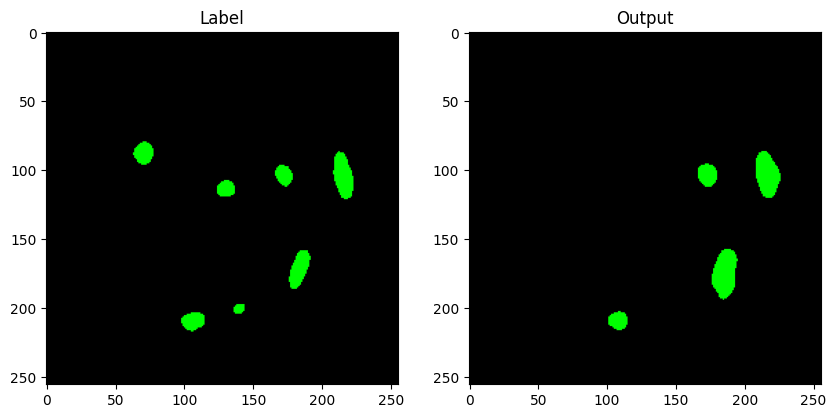

Epoch [41/300], Loss: 0.1658226097


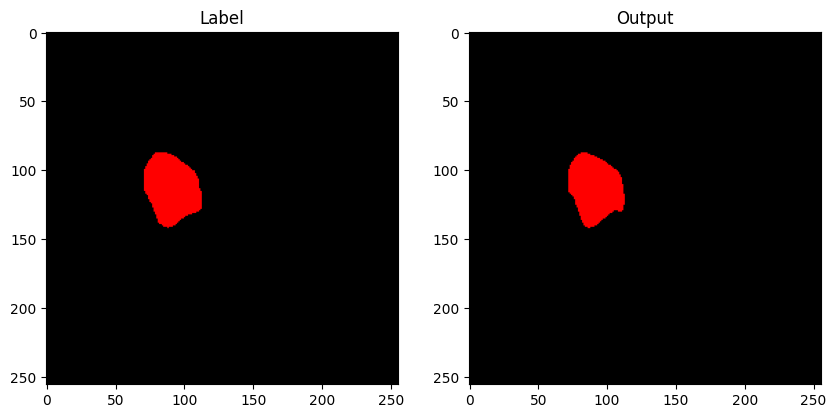

Epoch [42/300], Loss: 0.1761395924


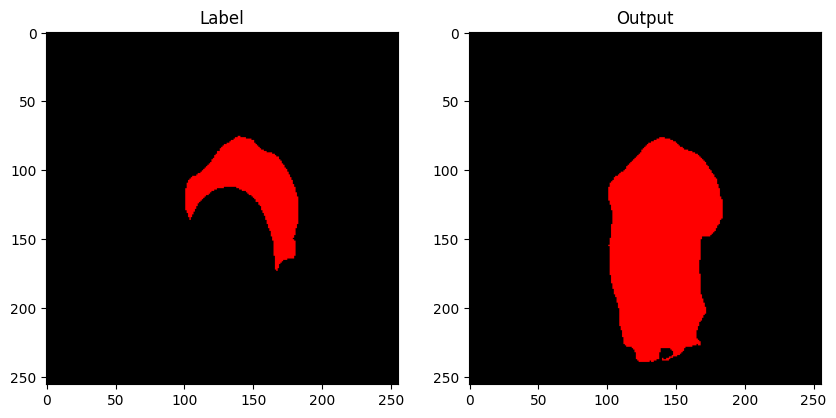

Epoch [43/300], Loss: 0.1439184701


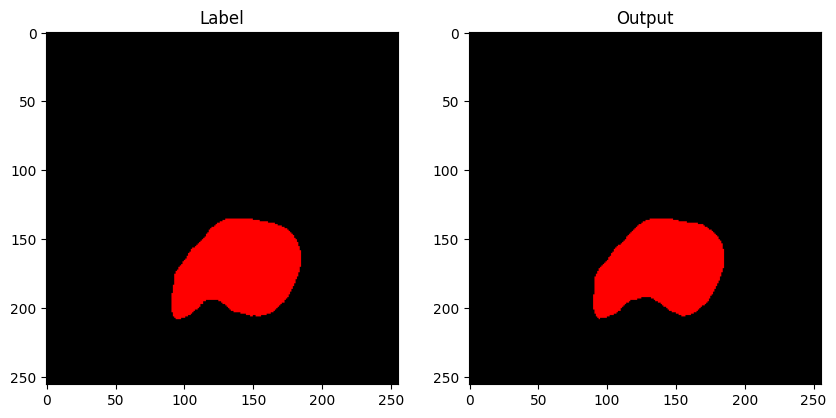

Epoch [44/300], Loss: 0.1606125614


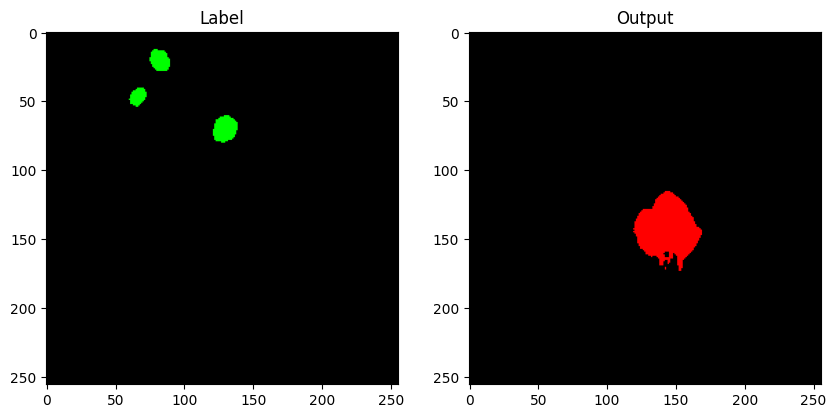

Epoch [45/300], Loss: 0.1646117385


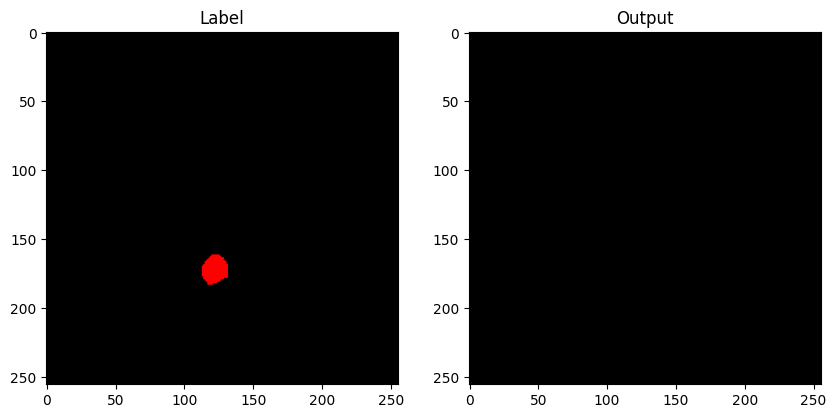

Epoch [46/300], Loss: 0.1503494101


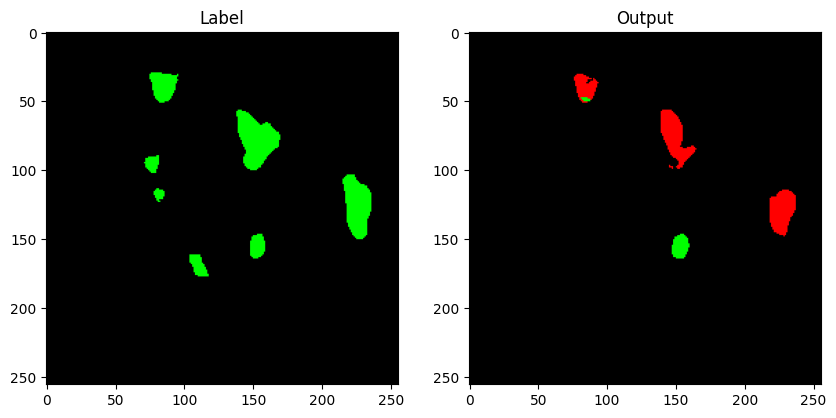

Epoch [47/300], Loss: 0.1180705200


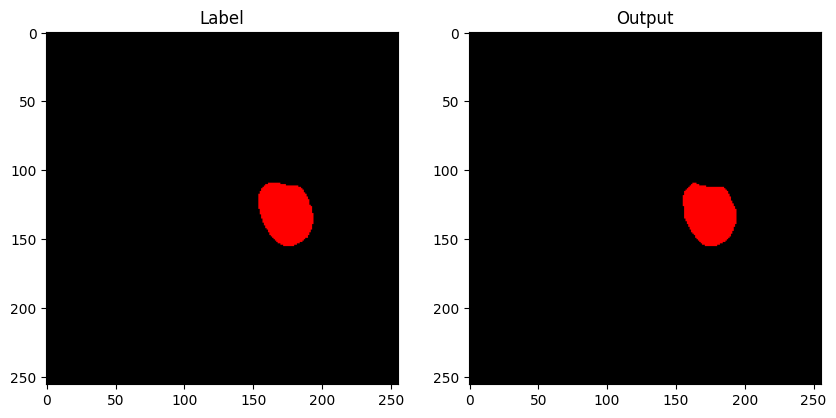

Epoch [48/300], Loss: 0.1248744162


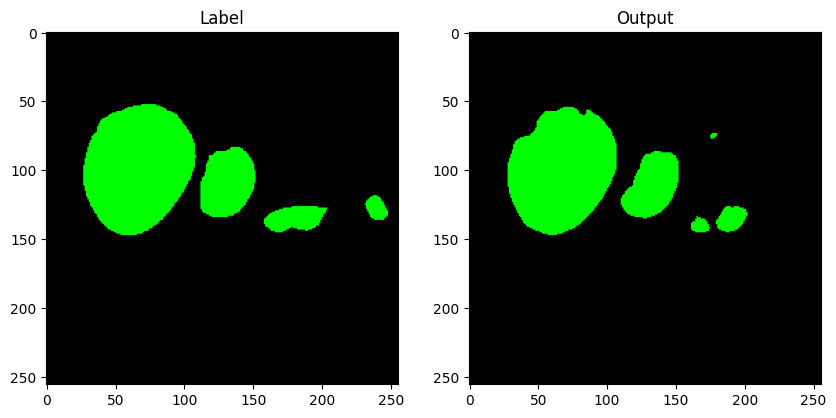

Epoch [49/300], Loss: 0.1228210386


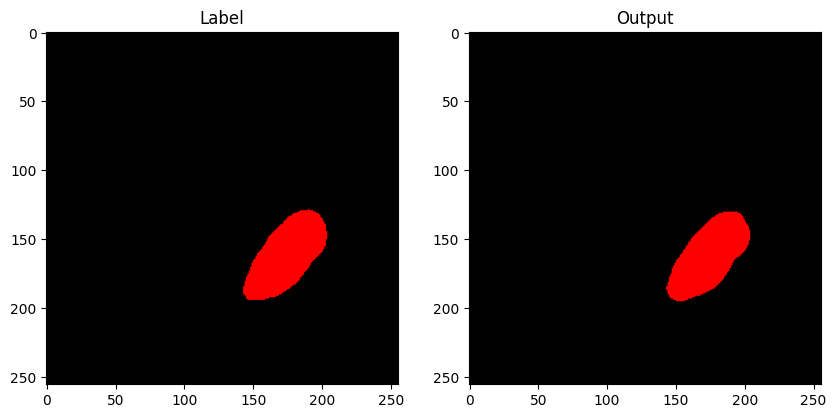

Epoch [50/300], Loss: 0.1428335074


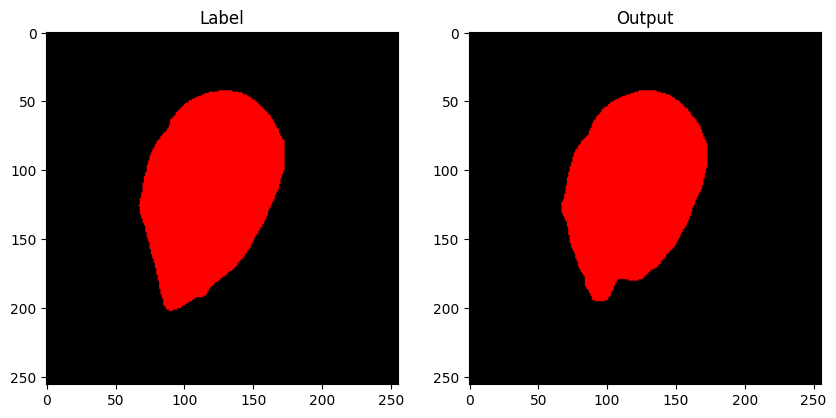

Epoch [51/300], Loss: 0.1386224227


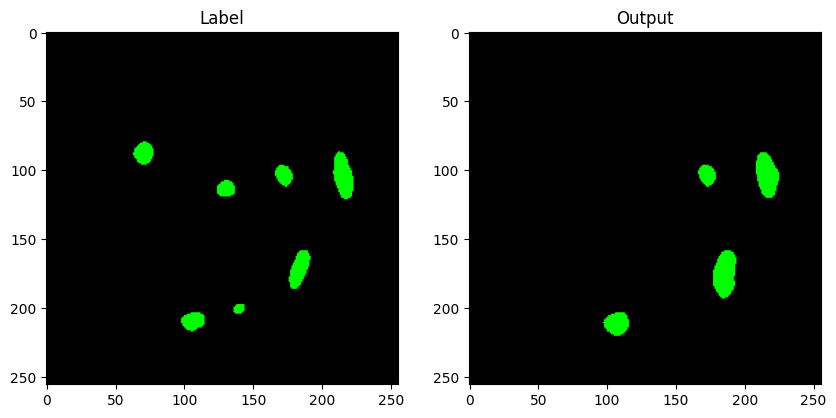

Epoch [52/300], Loss: 0.1337346518


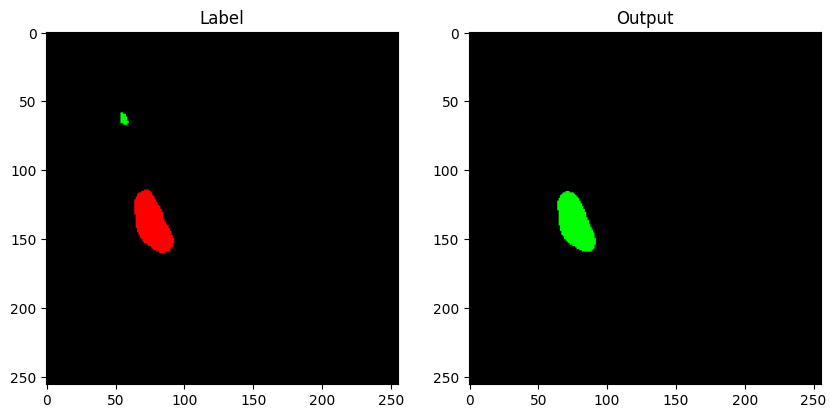

Epoch [53/300], Loss: 0.1334254684


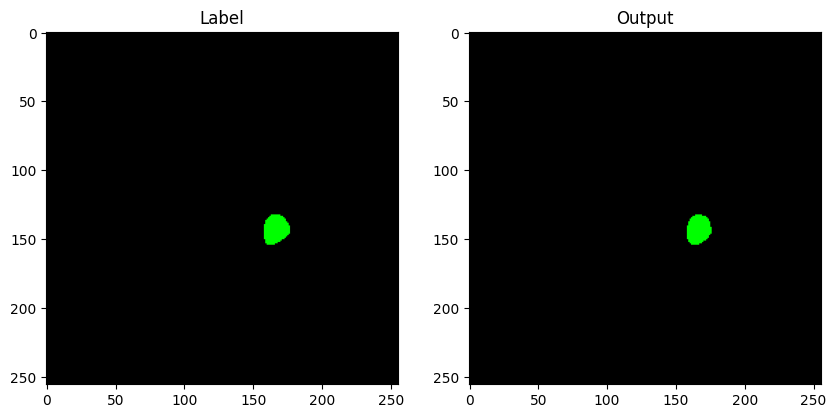

Epoch [54/300], Loss: 0.1375494182


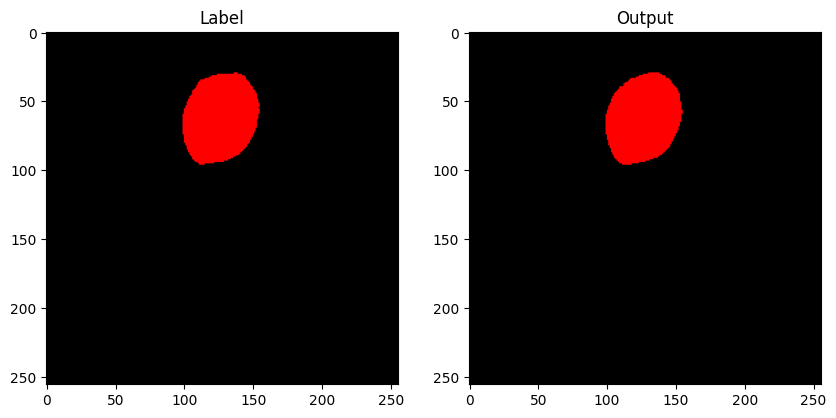

Epoch [55/300], Loss: 0.1294218303


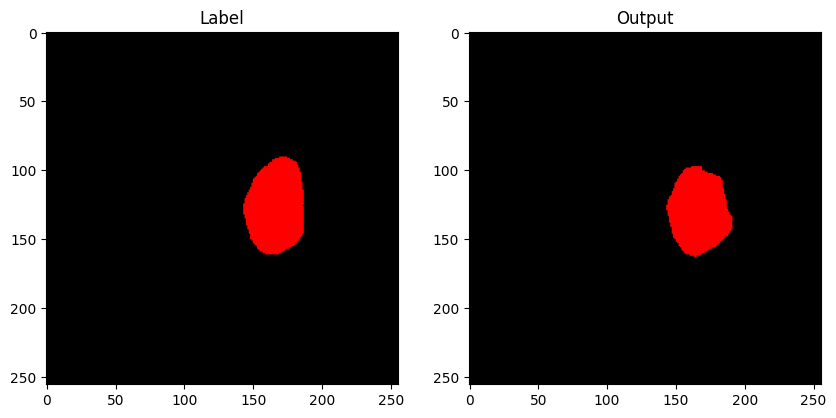

Epoch [56/300], Loss: 0.1529965040


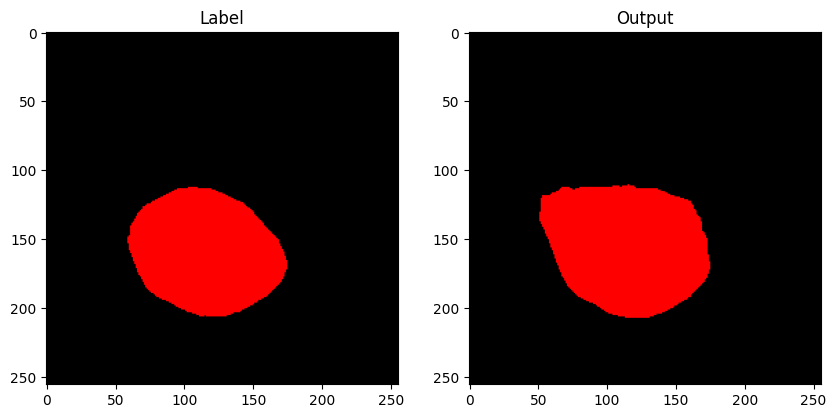

Epoch [57/300], Loss: 0.1219935924


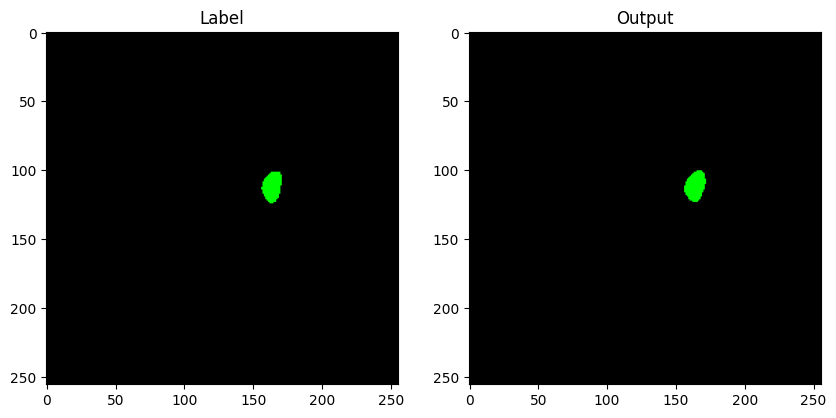

Epoch [58/300], Loss: 0.1191584893


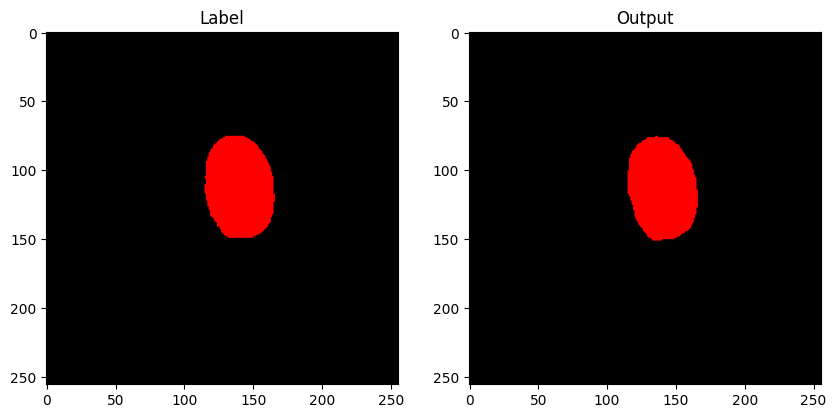

Epoch [59/300], Loss: 0.1396284036


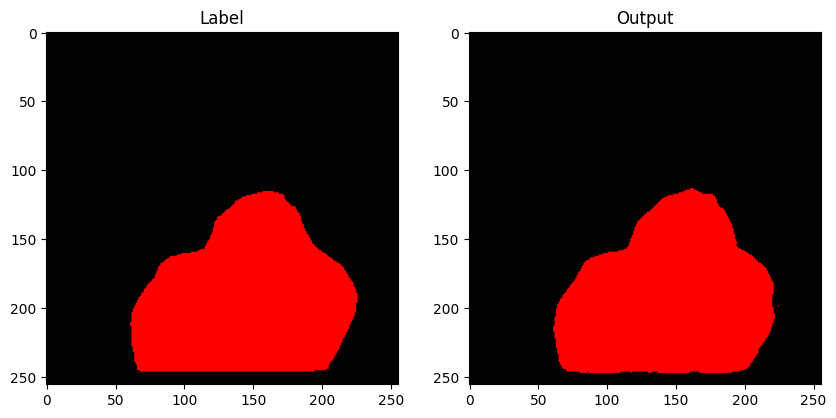

Epoch [60/300], Loss: 0.1486969481


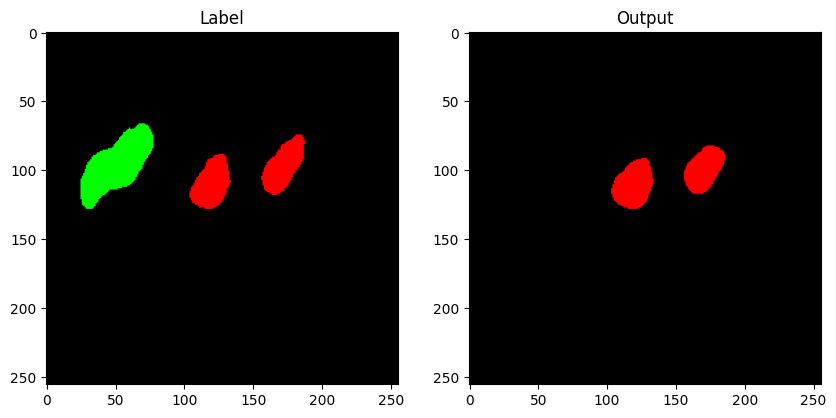

Epoch [61/300], Loss: 0.1201376019


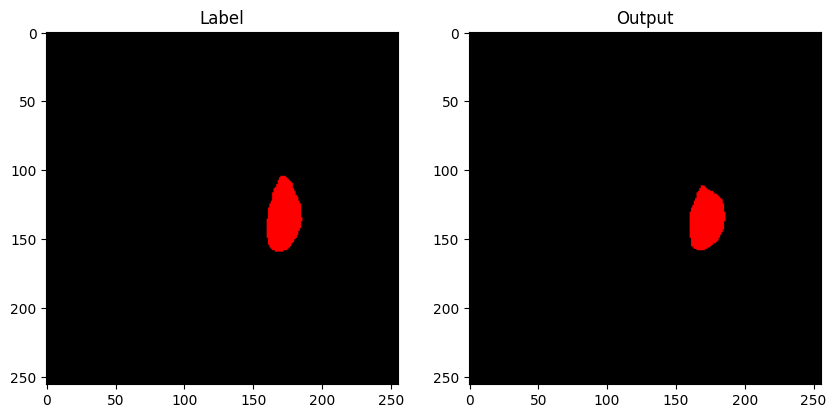

Epoch [62/300], Loss: 0.1352085262


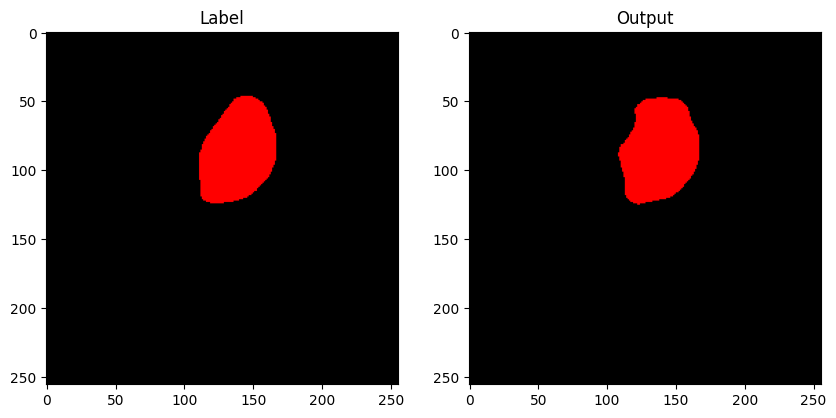

Epoch [63/300], Loss: 0.1447334605


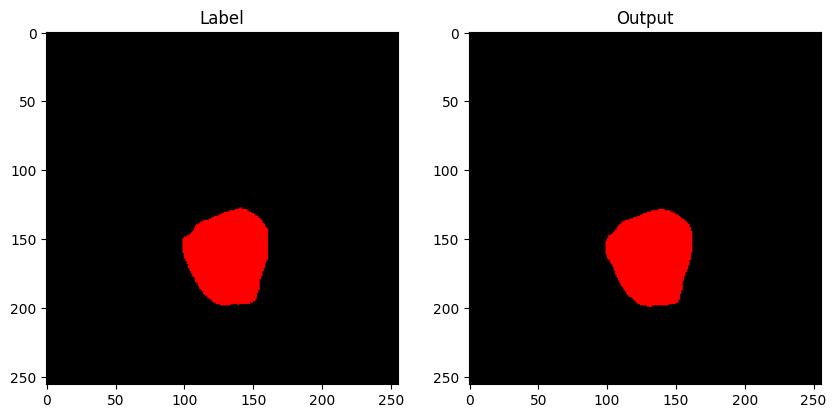

Epoch [64/300], Loss: 0.1432215695


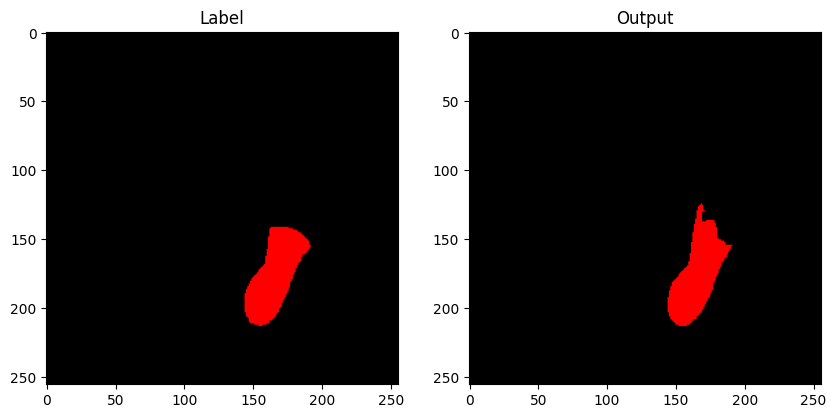

Epoch [65/300], Loss: 0.1506105823


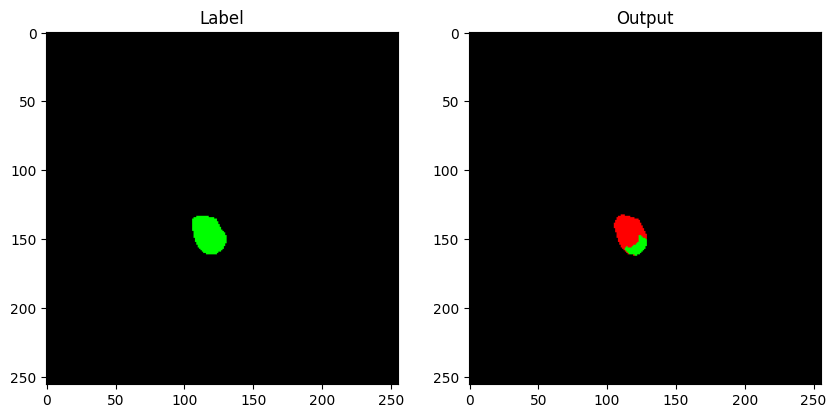

Epoch [66/300], Loss: 0.1418976027


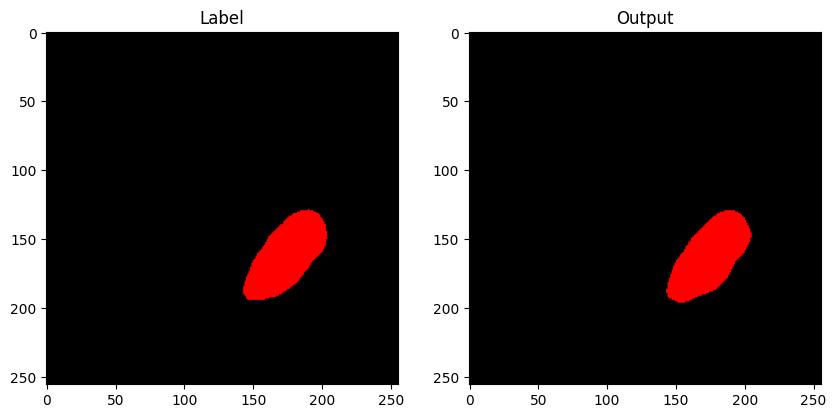

Epoch [67/300], Loss: 0.1395392564


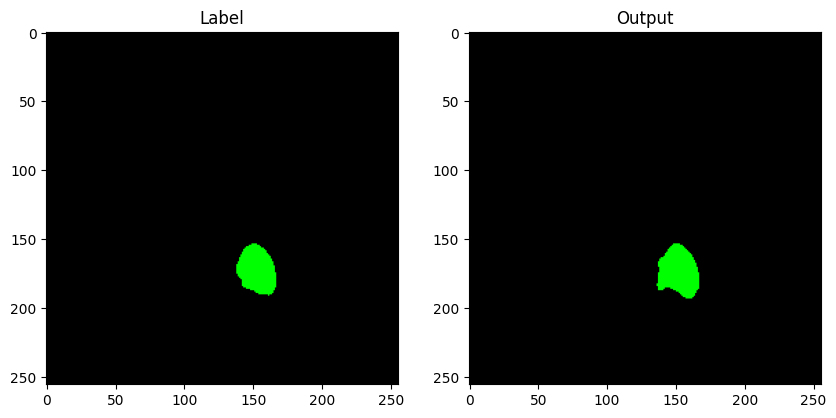

Epoch [68/300], Loss: 0.1443109664


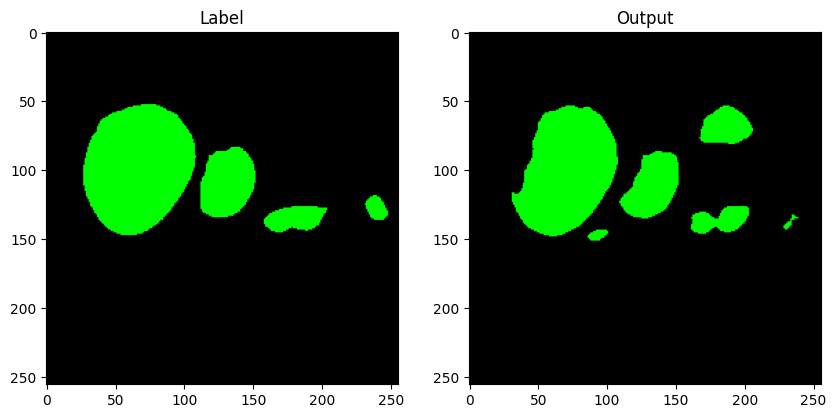

Epoch [69/300], Loss: 0.1444180976


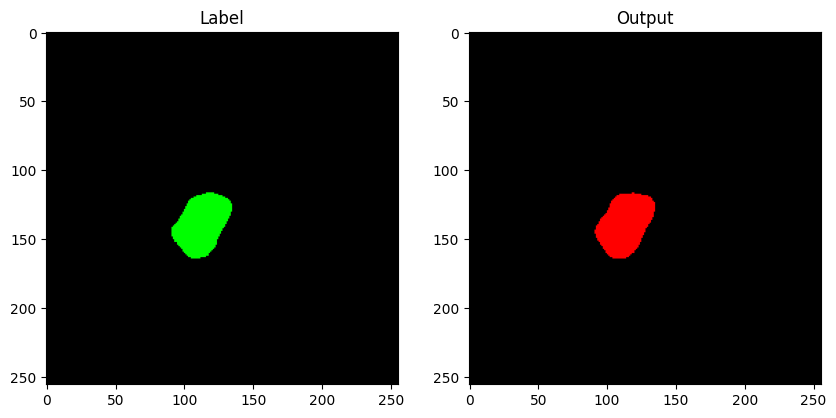

Epoch [70/300], Loss: 0.1578715971


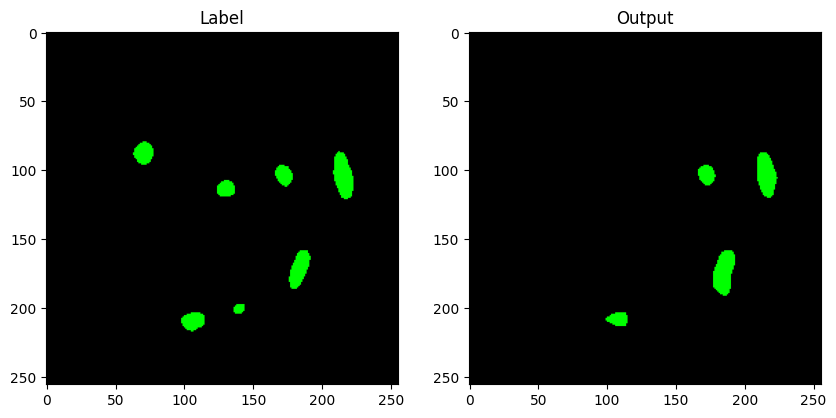

Epoch [71/300], Loss: 0.1487305782


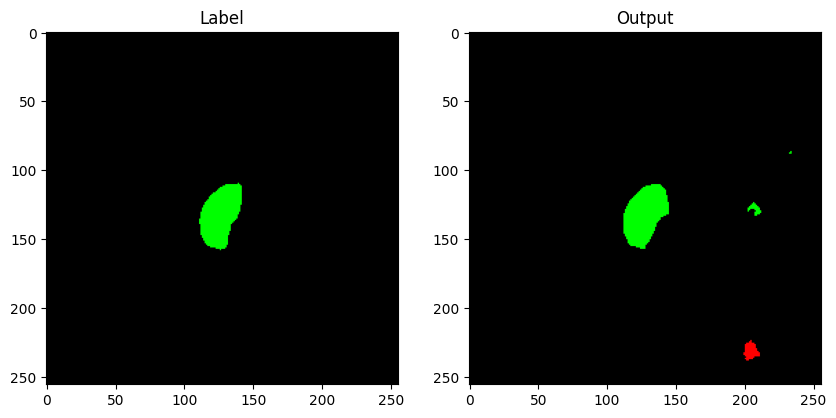

Epoch [72/300], Loss: 0.1435578680


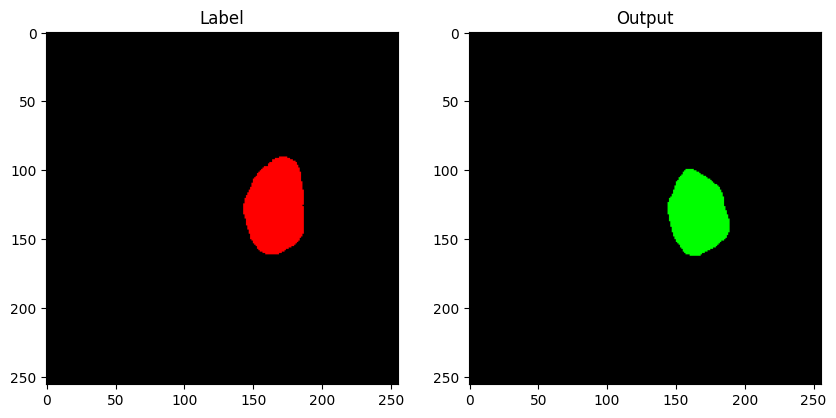

Epoch [73/300], Loss: 0.1094909276
Save new model


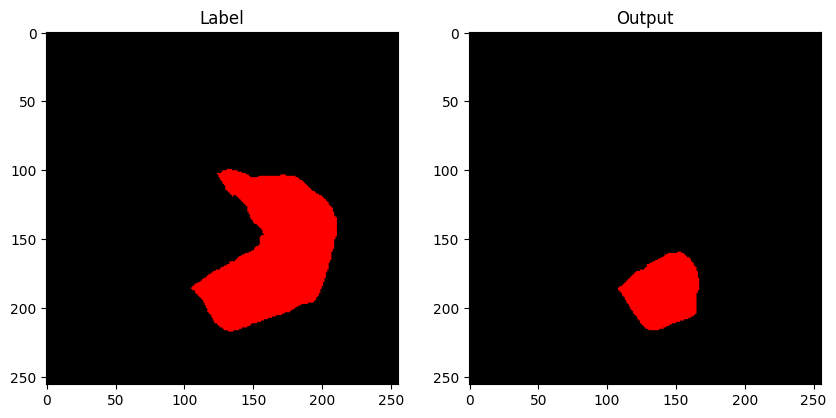

Epoch [74/300], Loss: 0.1199948531


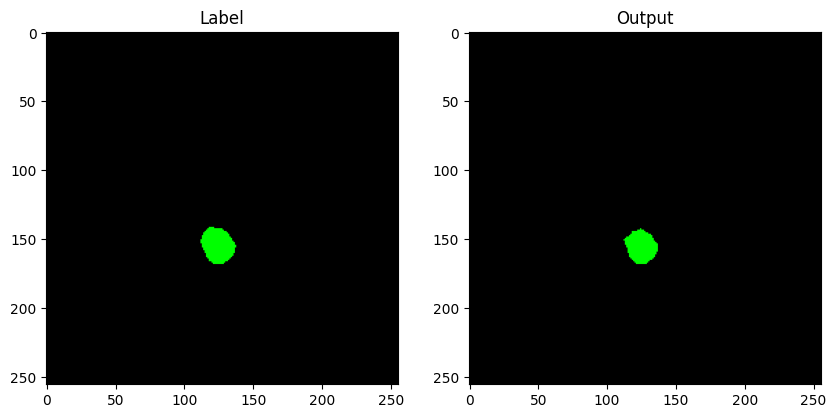

Epoch [75/300], Loss: 0.1405245106


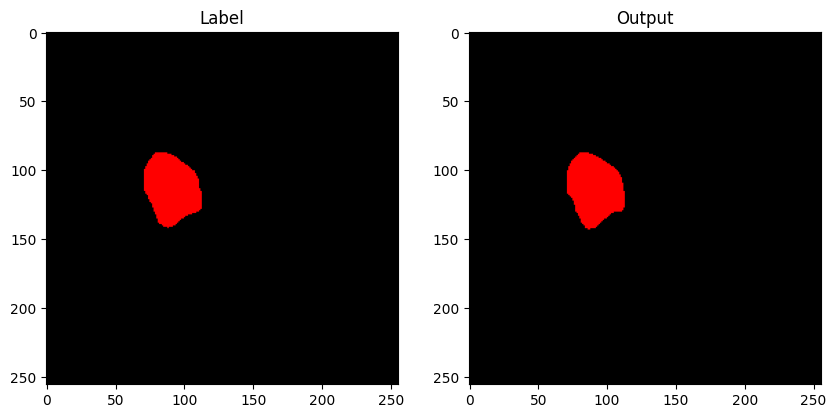

Epoch [76/300], Loss: 0.1267677500


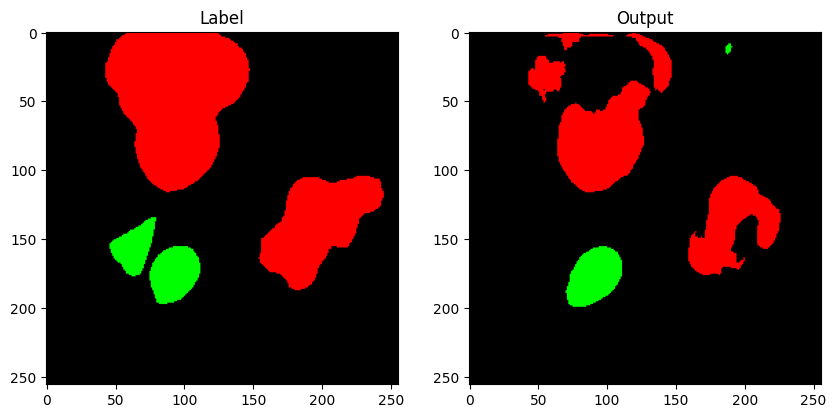

Epoch [77/300], Loss: 0.1266358297


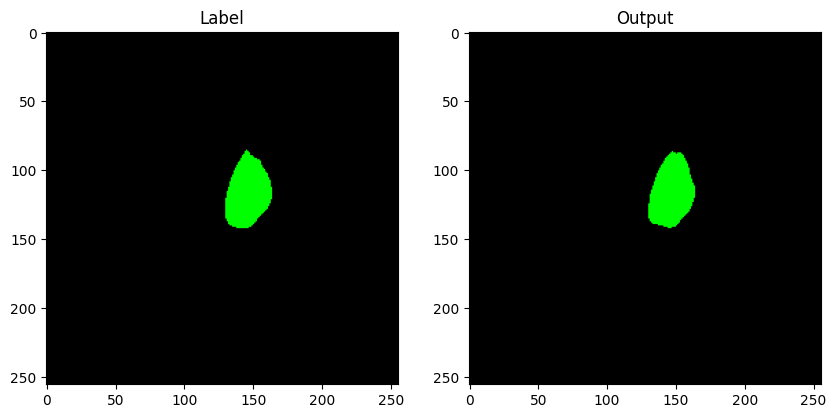

Epoch [78/300], Loss: 0.1550268062


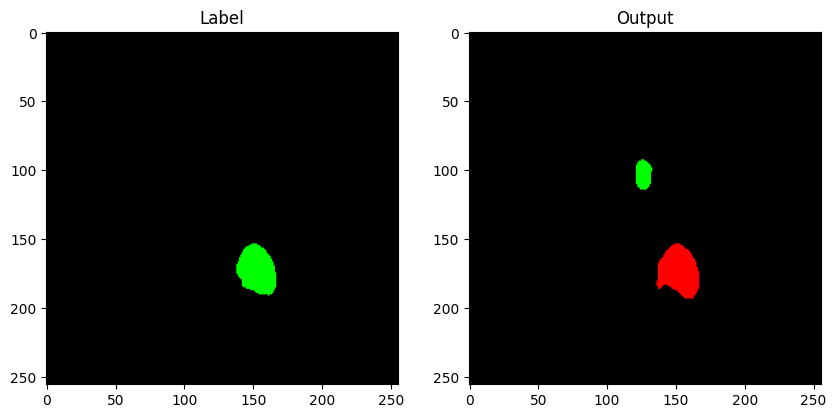

Epoch [79/300], Loss: 0.1499725552


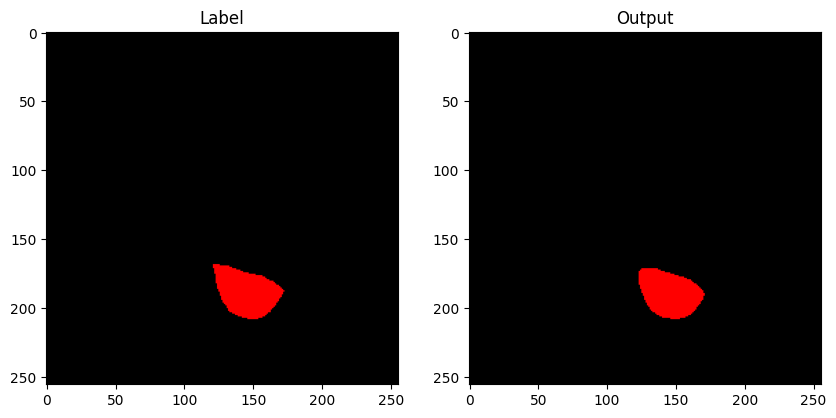

Epoch [80/300], Loss: 0.1180713560


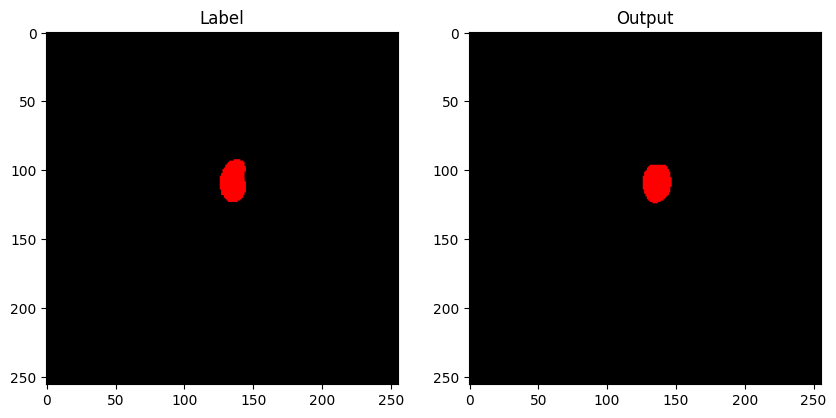

Epoch [81/300], Loss: 0.1256601858


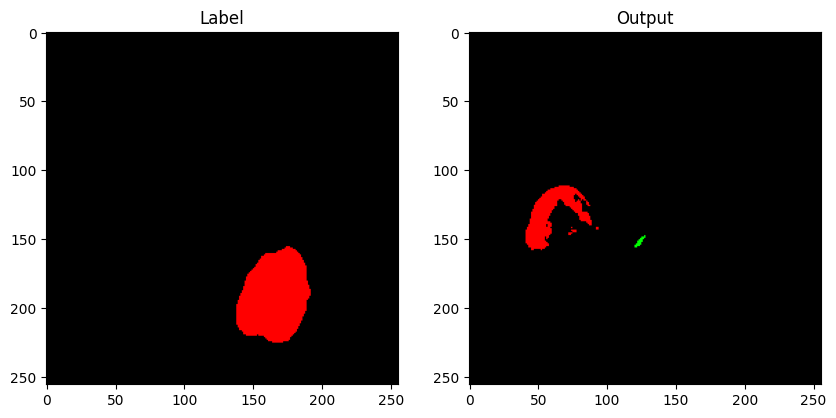

Epoch [82/300], Loss: 0.1589072842


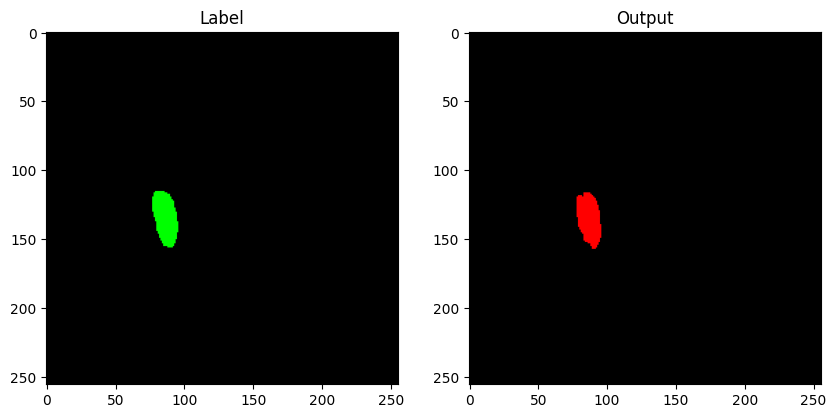

Epoch [83/300], Loss: 0.1474236716


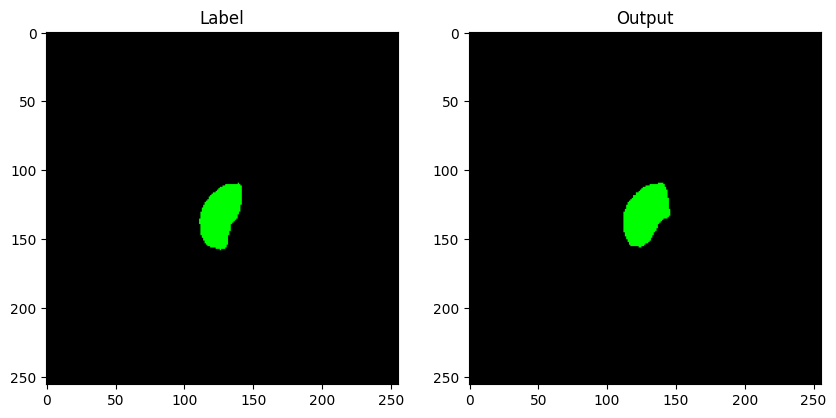

Epoch [84/300], Loss: 0.1455110486


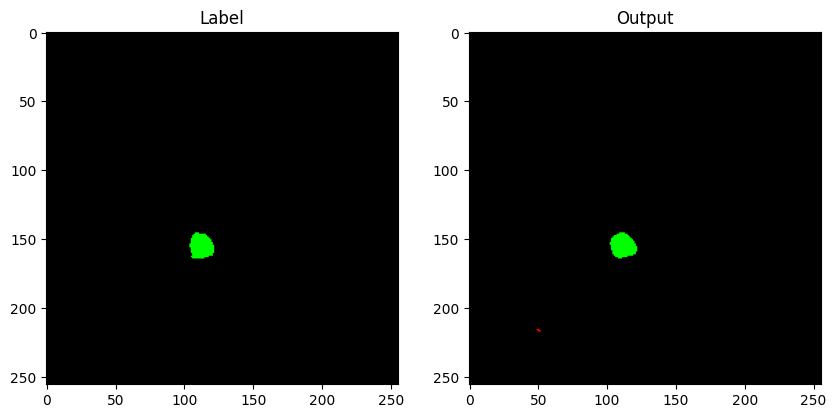

Epoch [85/300], Loss: 0.1296779230


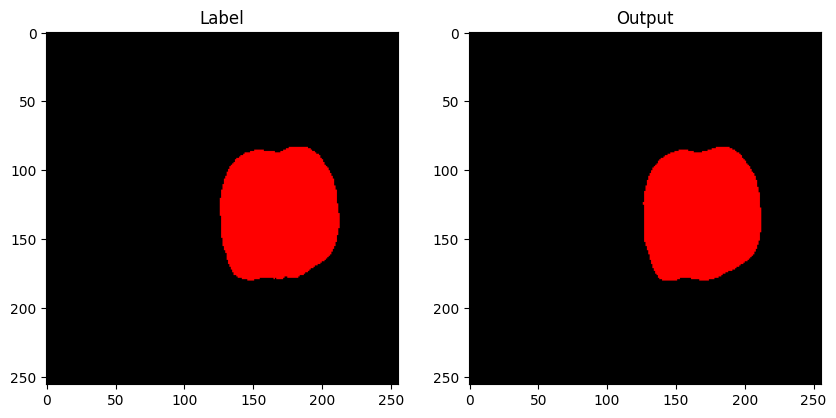

Epoch [86/300], Loss: 0.1293653993


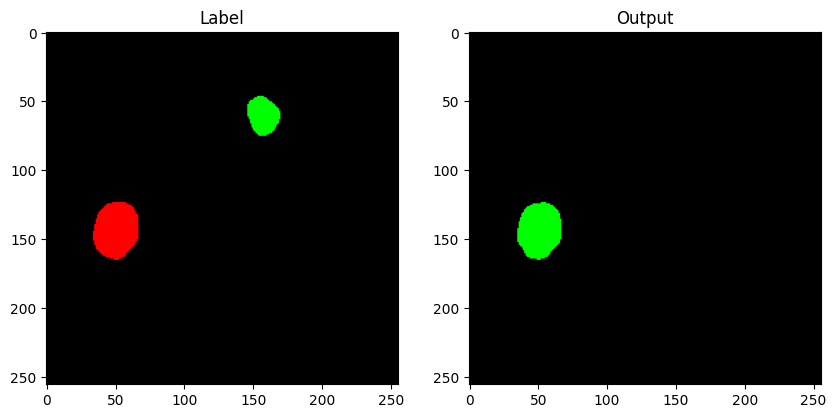

Epoch [87/300], Loss: 0.1363754889


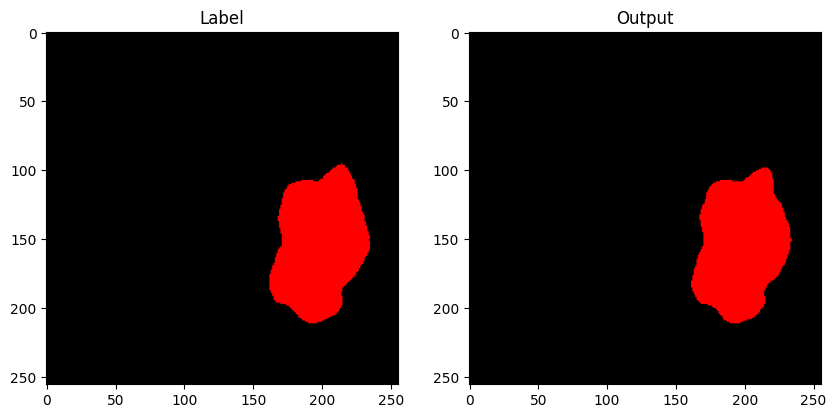

Epoch [88/300], Loss: 0.1335190265


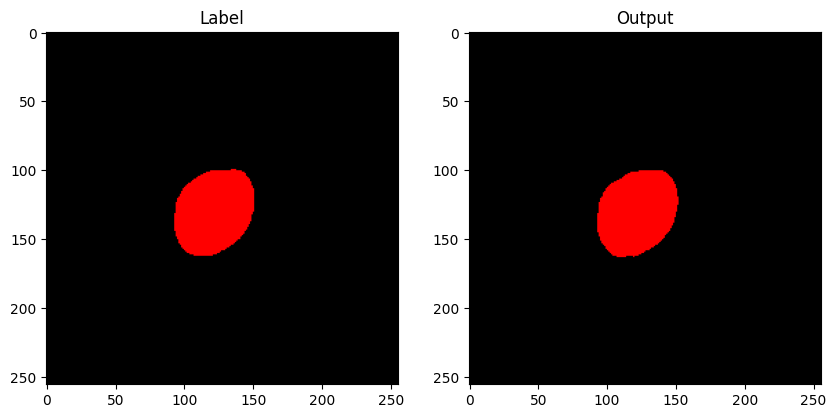

Epoch [89/300], Loss: 0.1171495691


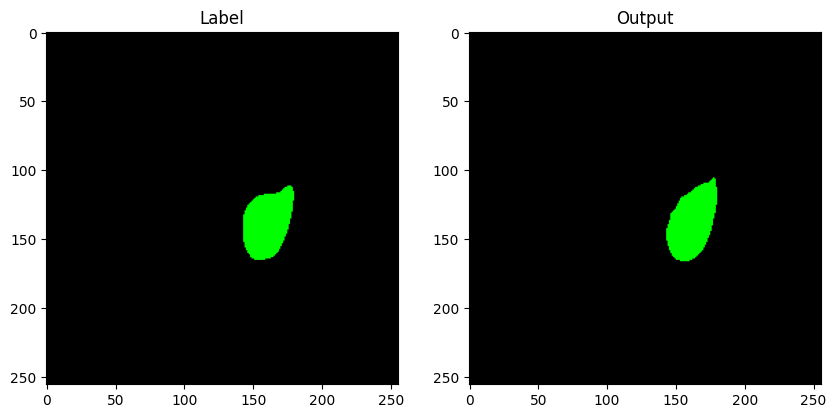

Epoch [90/300], Loss: 0.1117184817


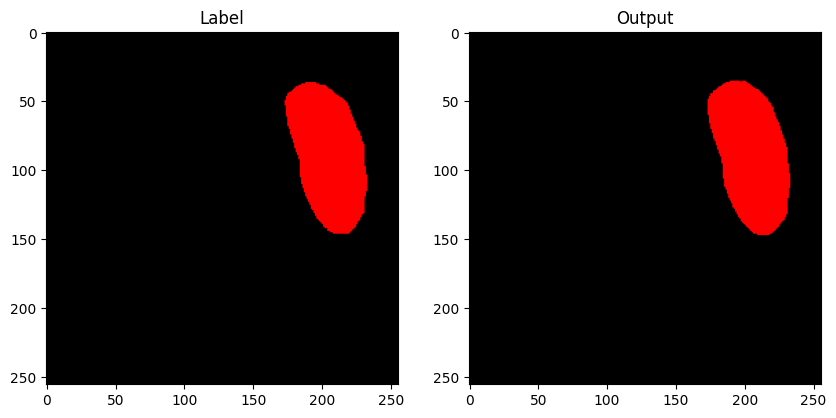

Epoch [91/300], Loss: 0.1243221975


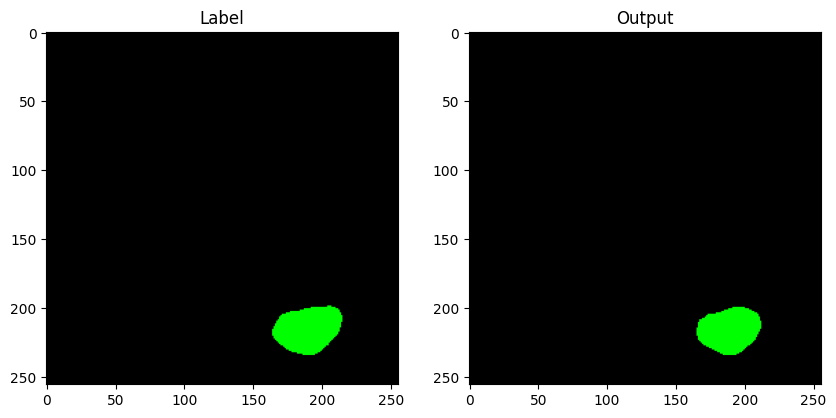

Epoch [92/300], Loss: 0.1259889542


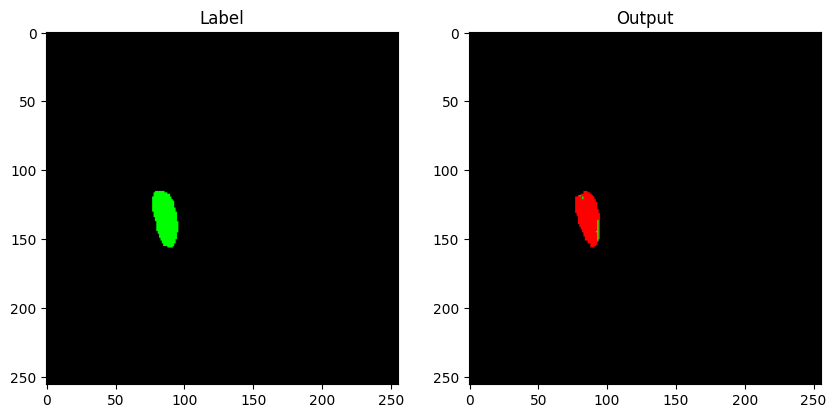

Epoch [93/300], Loss: 0.0999440894
Save new model


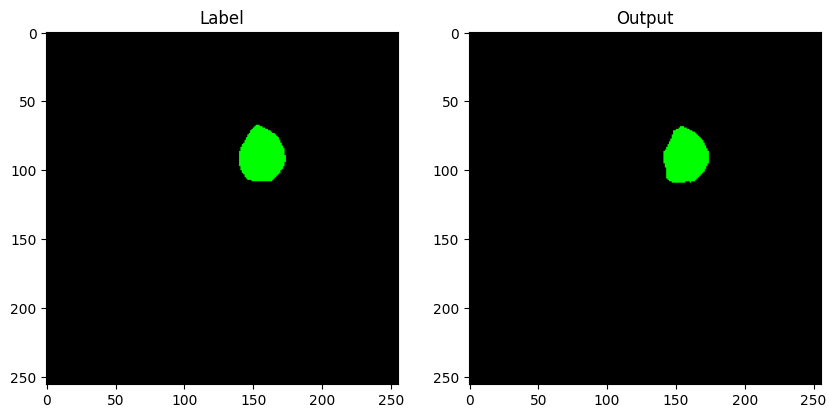

Epoch [94/300], Loss: 0.1179563760


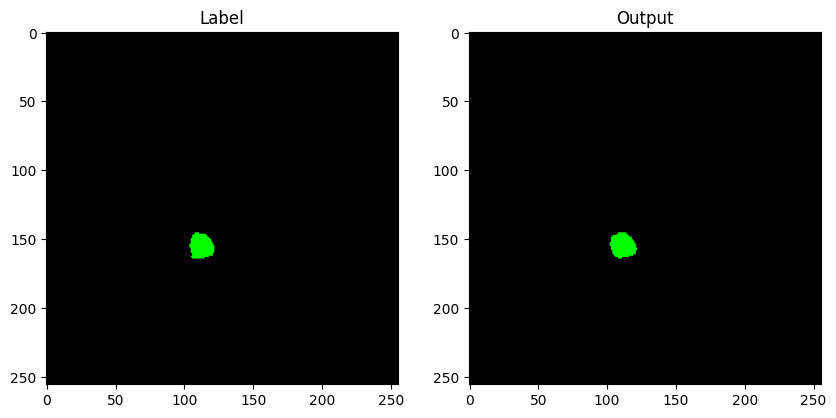

Epoch [95/300], Loss: 0.1295787577


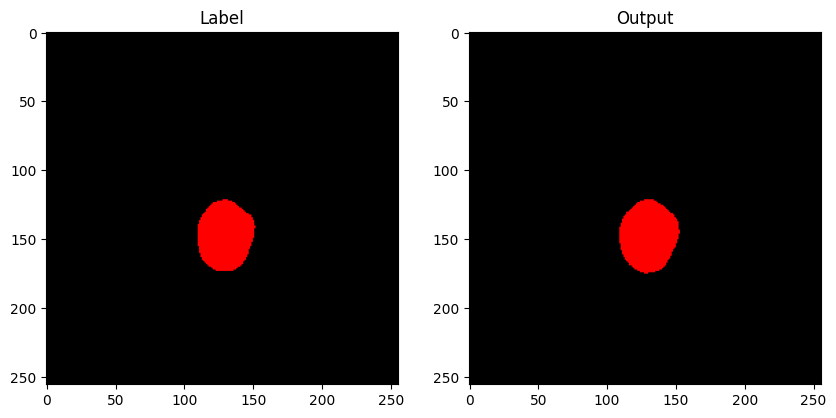

Epoch [96/300], Loss: 0.1042068457


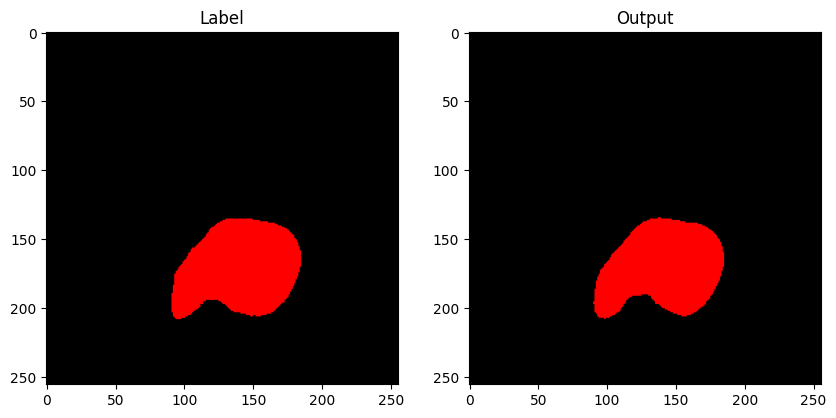

Epoch [97/300], Loss: 0.1050098246


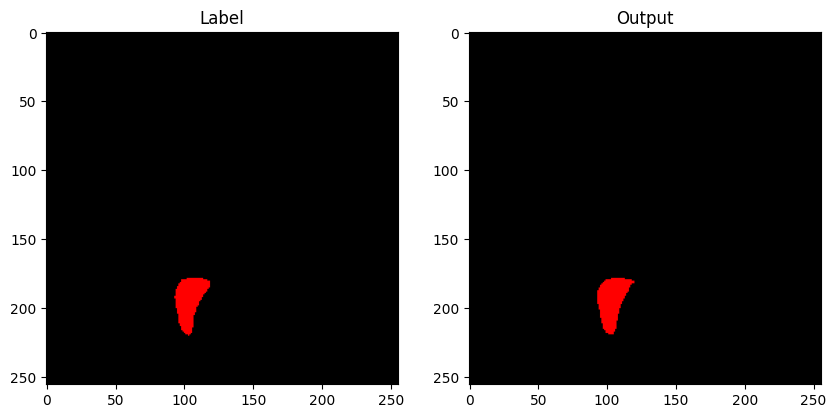

Epoch [98/300], Loss: 0.1136821164


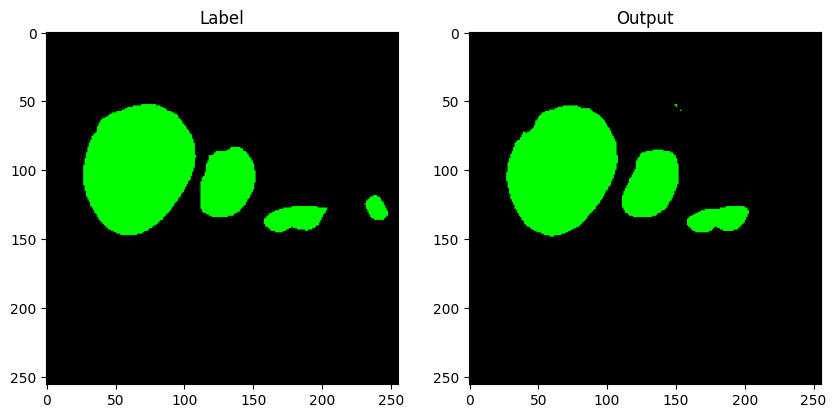

Epoch [99/300], Loss: 0.1026780484


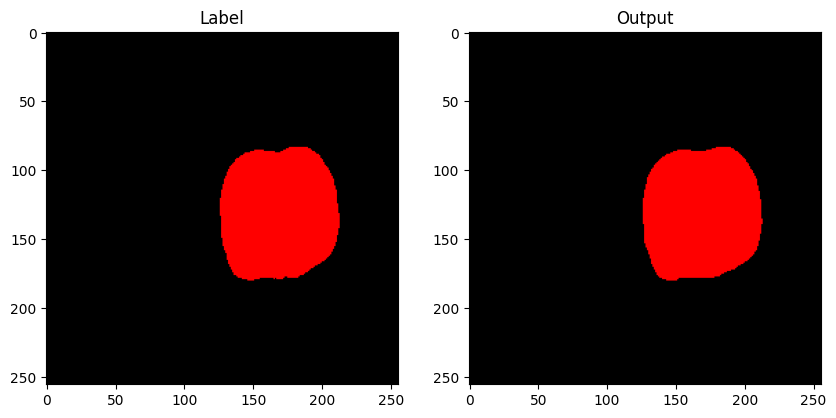

Epoch [100/300], Loss: 0.1202876387


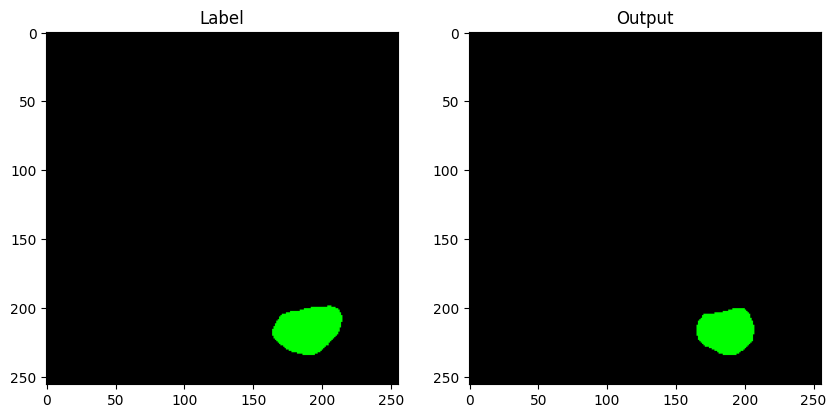

Epoch [101/300], Loss: 0.1303387271


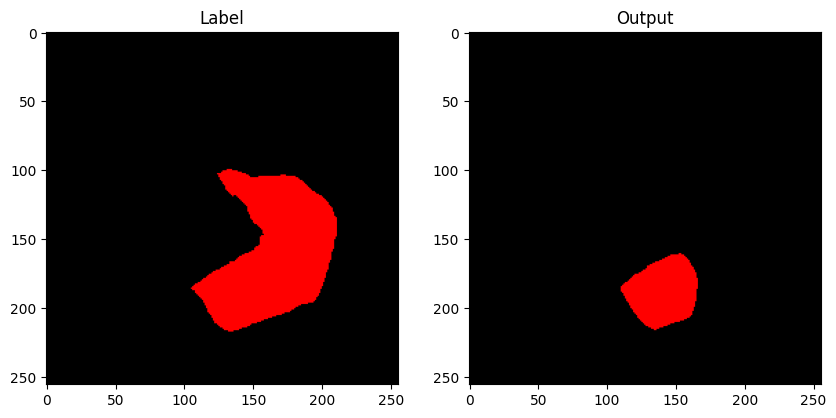

Epoch [102/300], Loss: 0.1233849371


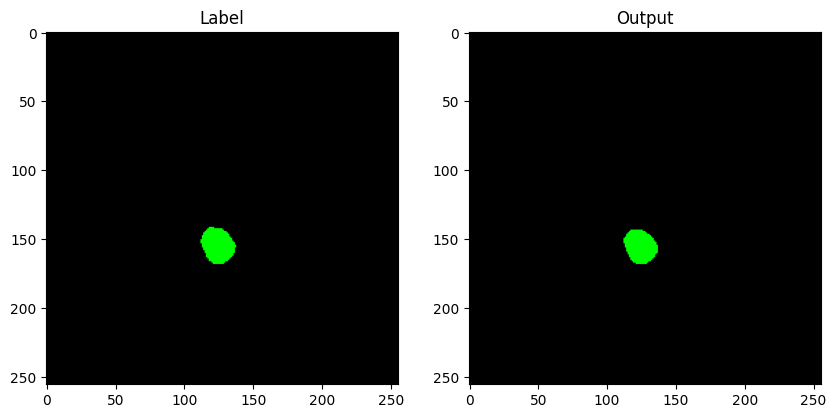

Epoch [103/300], Loss: 0.1390432254


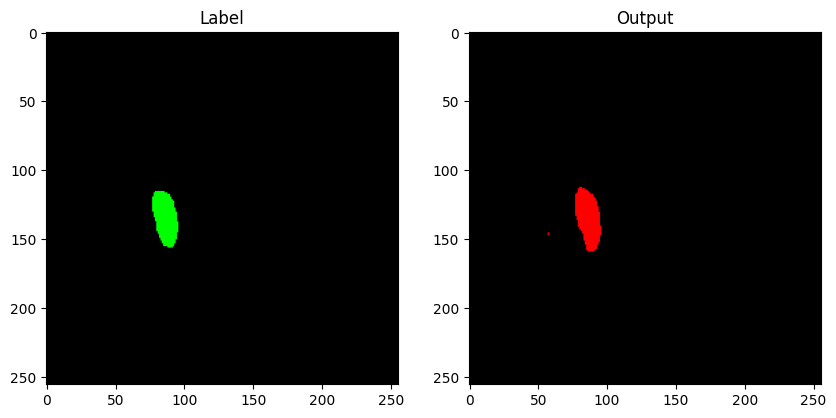

Epoch [104/300], Loss: 0.1545548903


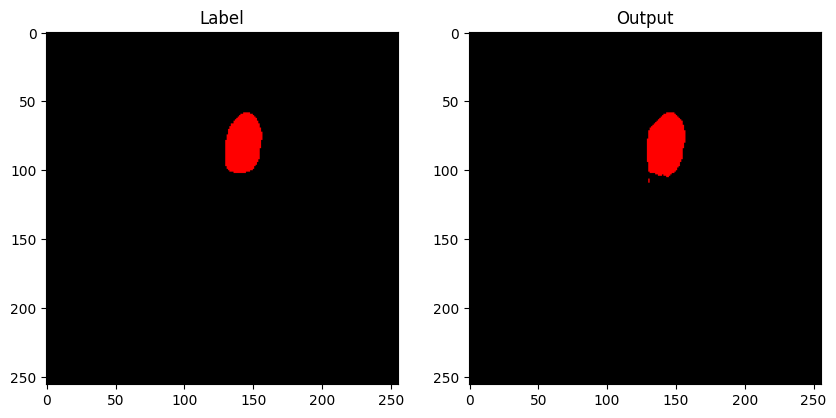

Epoch [105/300], Loss: 0.1298565458


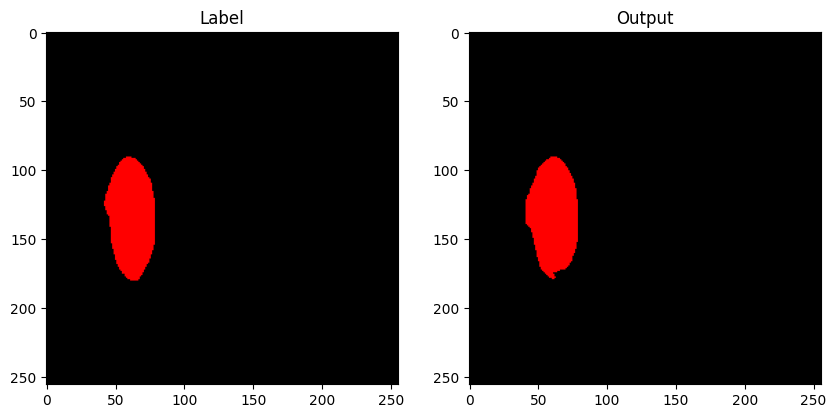

Epoch [106/300], Loss: 0.1342426156


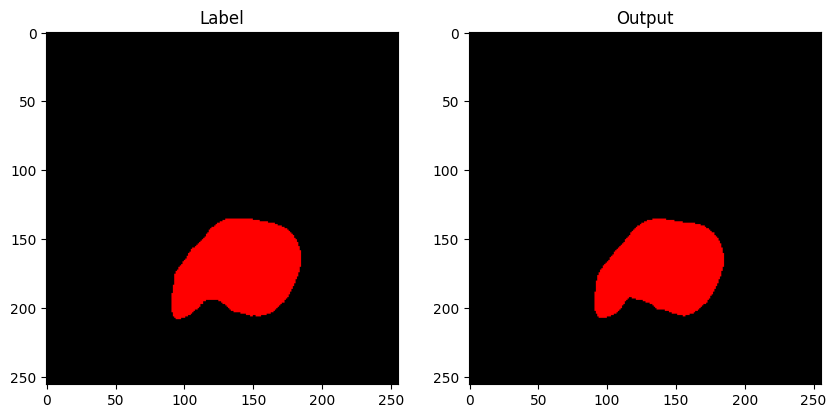

Epoch [107/300], Loss: 0.1193577312


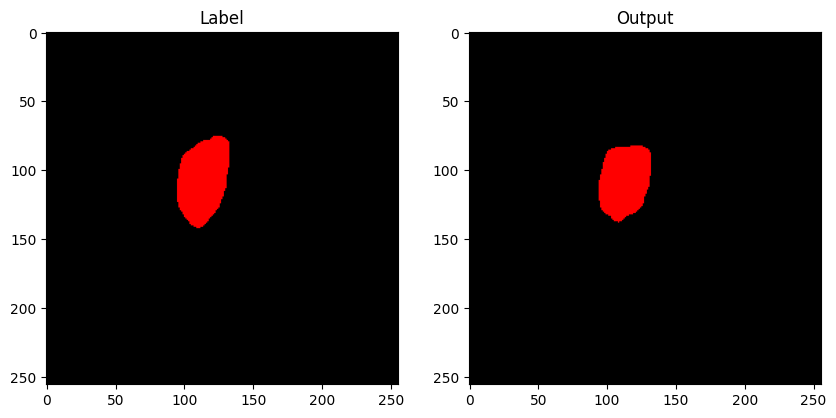

Epoch [108/300], Loss: 0.1371837859


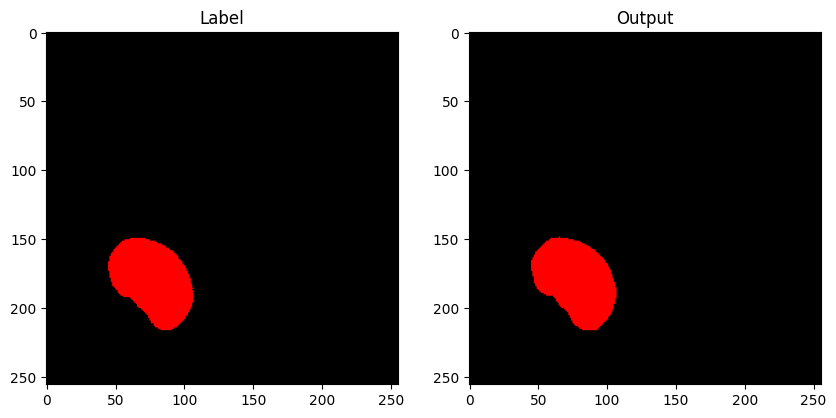

Epoch [109/300], Loss: 0.1302050007


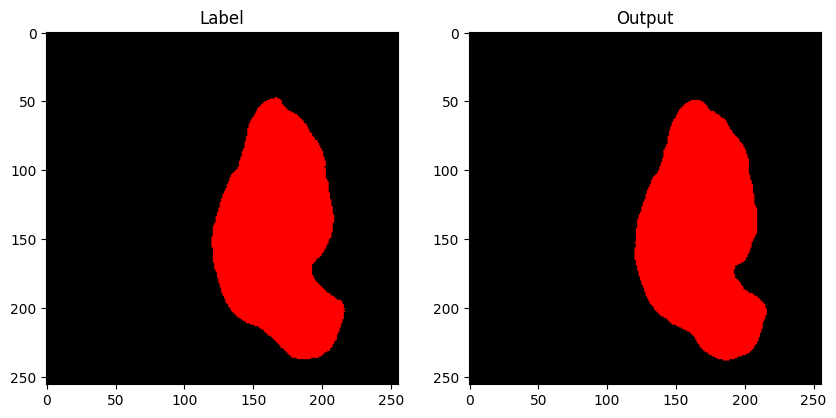

Epoch [110/300], Loss: 0.1358395233


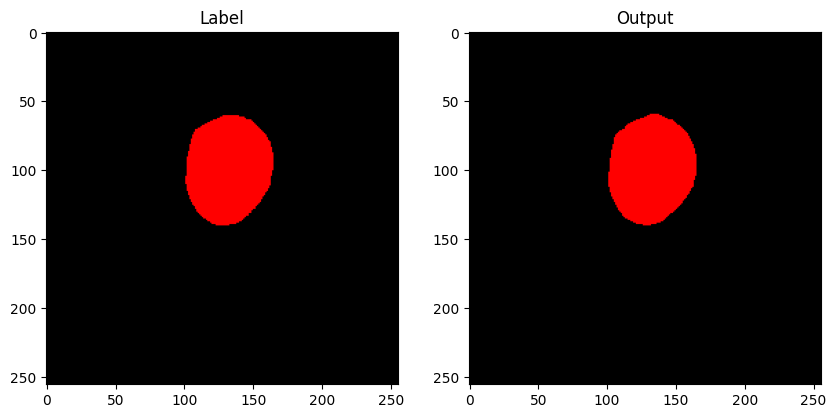

Epoch [111/300], Loss: 0.1376902553


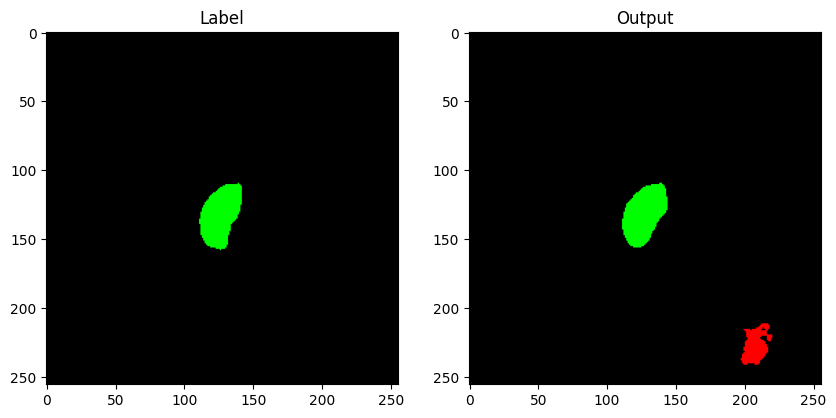

Epoch [112/300], Loss: 0.1229701710


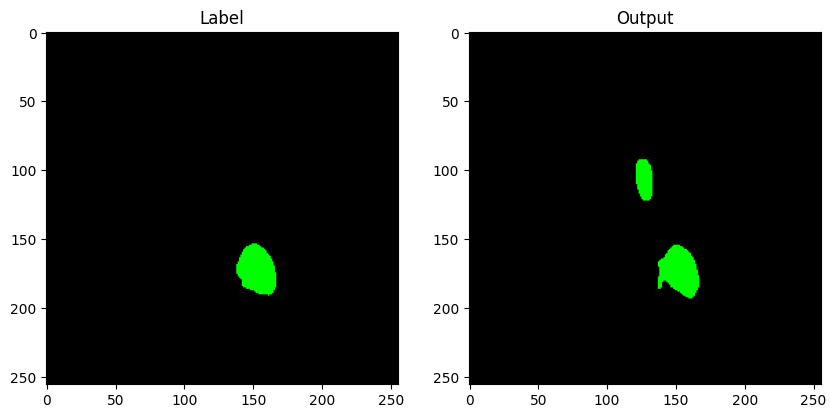

Epoch [113/300], Loss: 0.1680942622


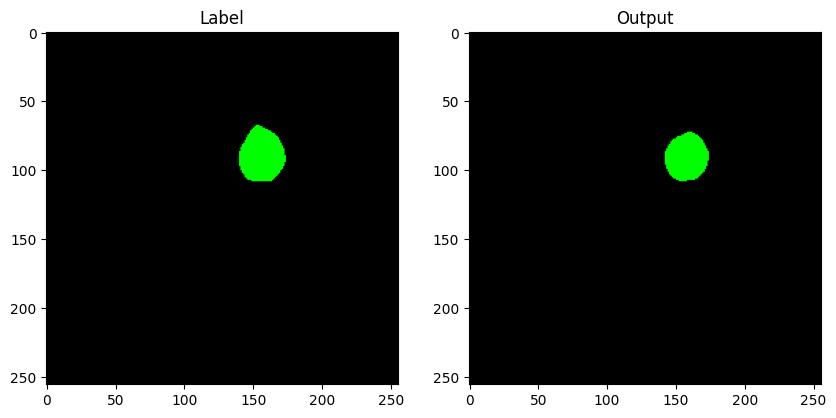

Epoch [114/300], Loss: 0.1386155882


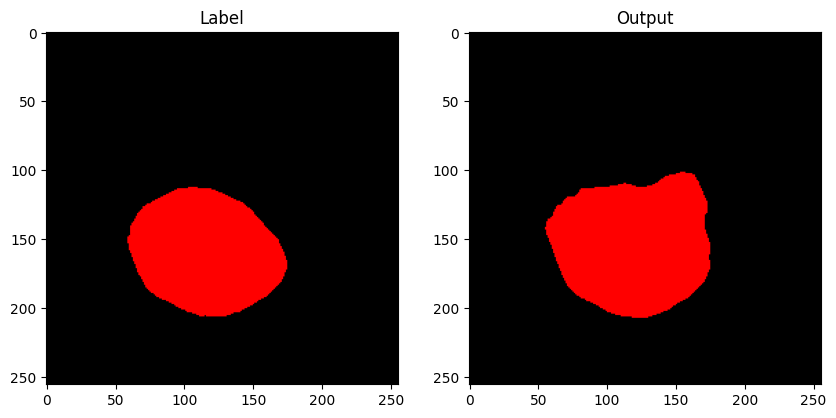

Epoch [115/300], Loss: 0.1282216710


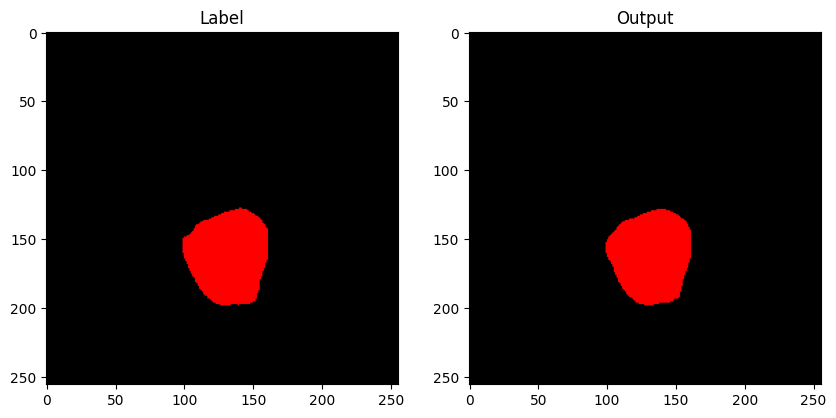

Epoch [116/300], Loss: 0.1311274397


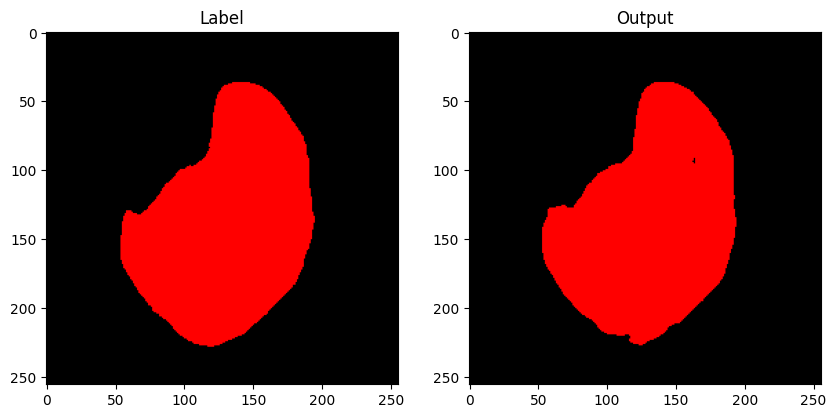

Epoch [117/300], Loss: 0.1423366031


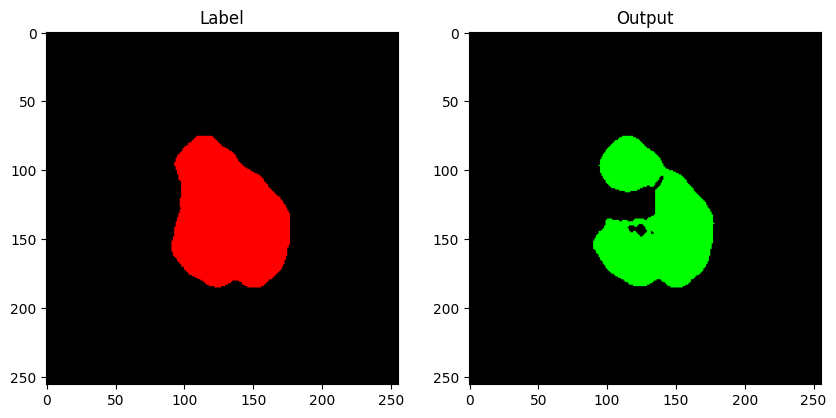

Epoch [118/300], Loss: 0.1236744923


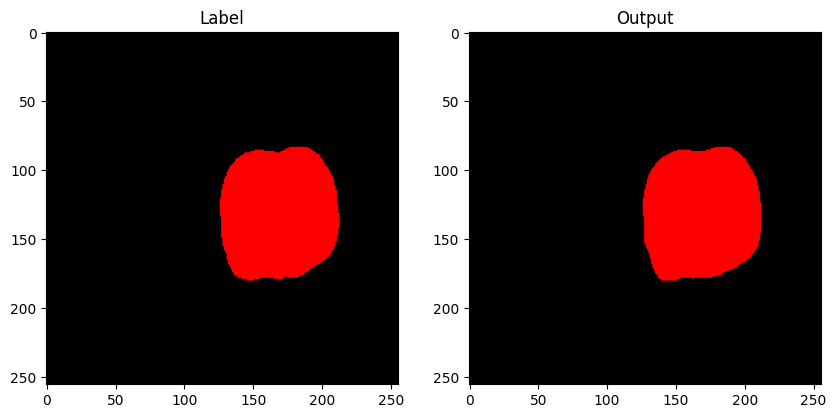

Epoch [119/300], Loss: 0.1317019182


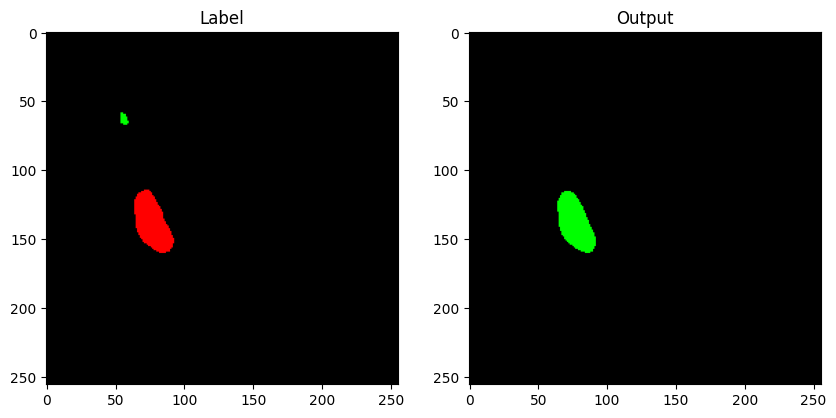

Epoch [120/300], Loss: 0.1393952668


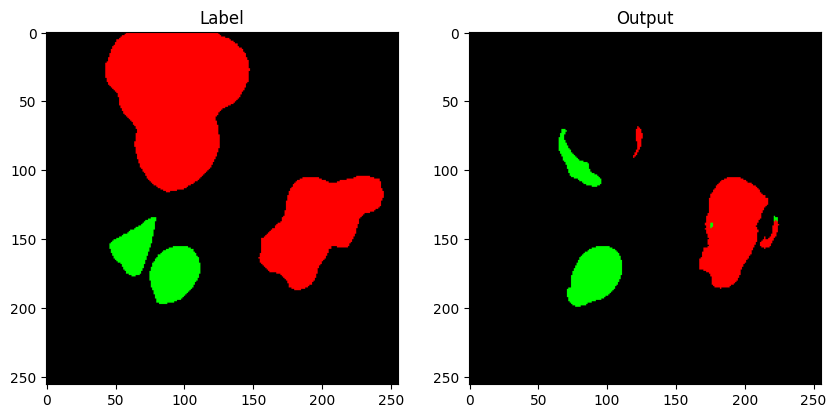

Epoch [121/300], Loss: 0.1293615851


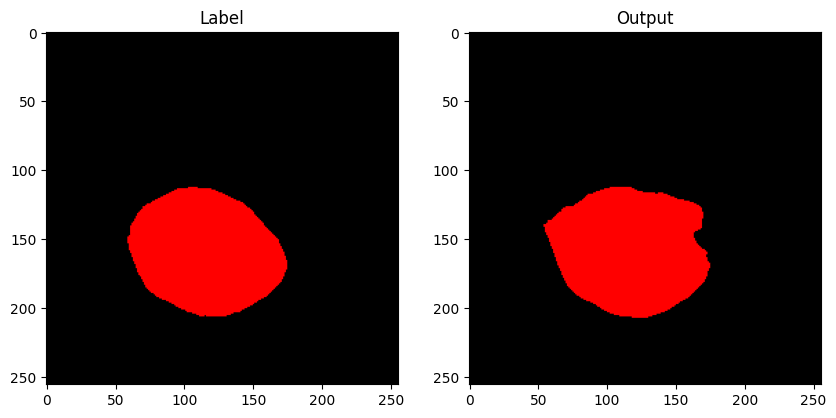

Epoch [122/300], Loss: 0.1633340413


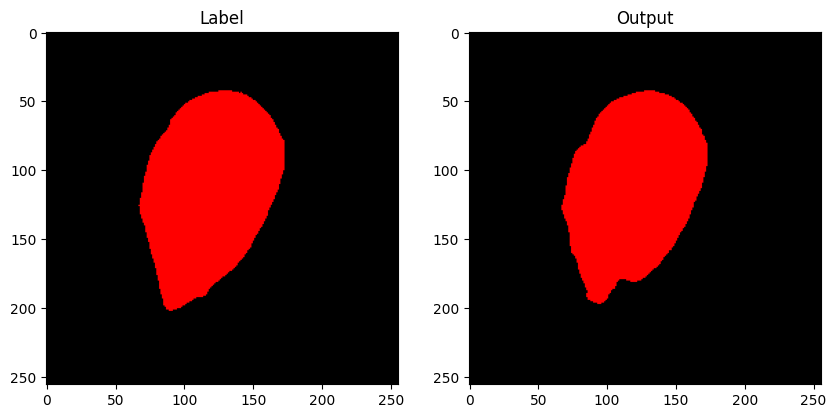

Epoch [123/300], Loss: 0.1186263172


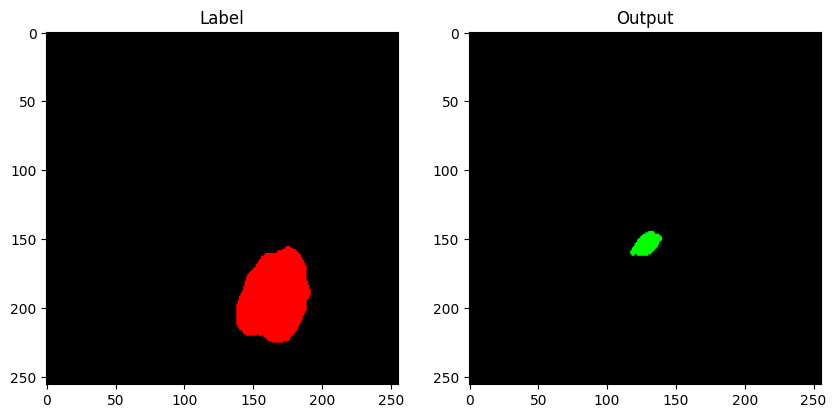

Epoch [124/300], Loss: 0.1355306147


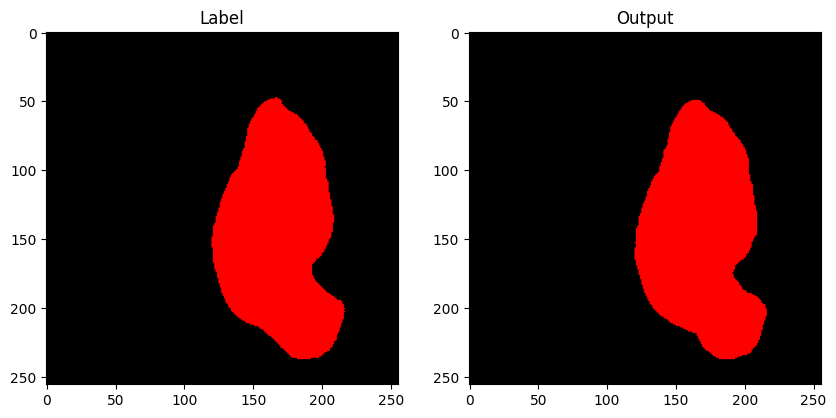

Epoch [125/300], Loss: 0.1536840751


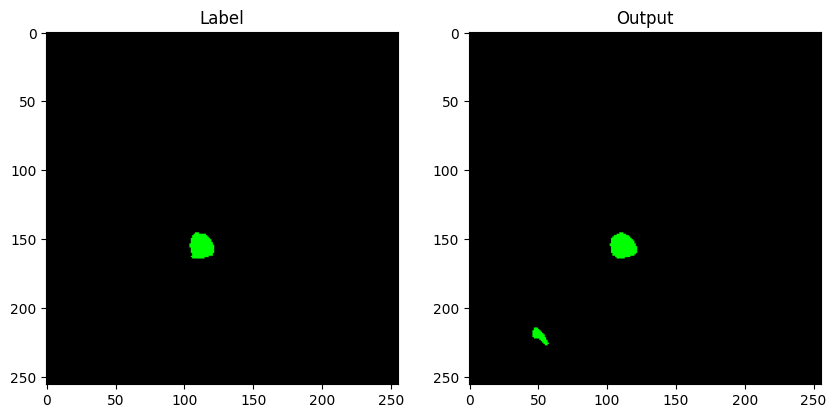

Epoch [126/300], Loss: 0.1184667118


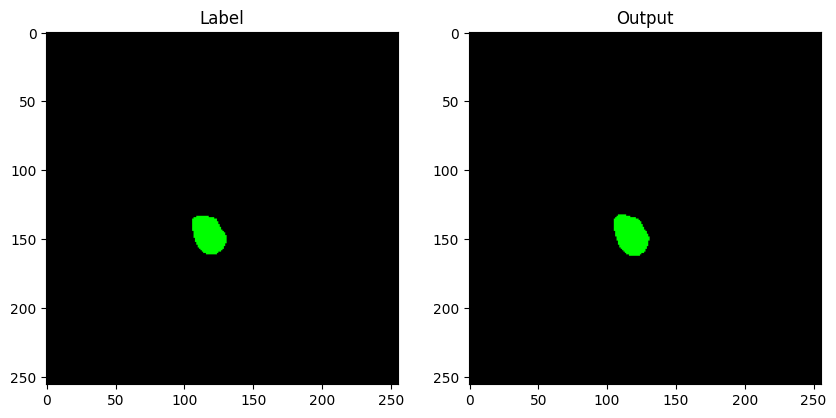

Epoch [127/300], Loss: 0.1149159176


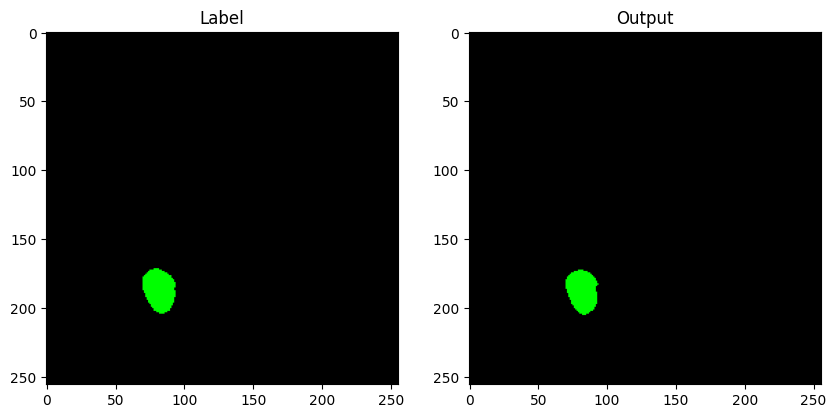

Epoch [128/300], Loss: 0.1311305200


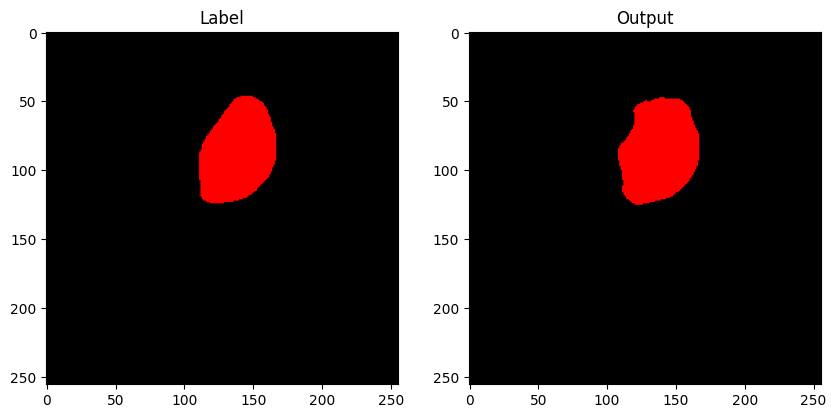

Epoch [129/300], Loss: 0.1182597949


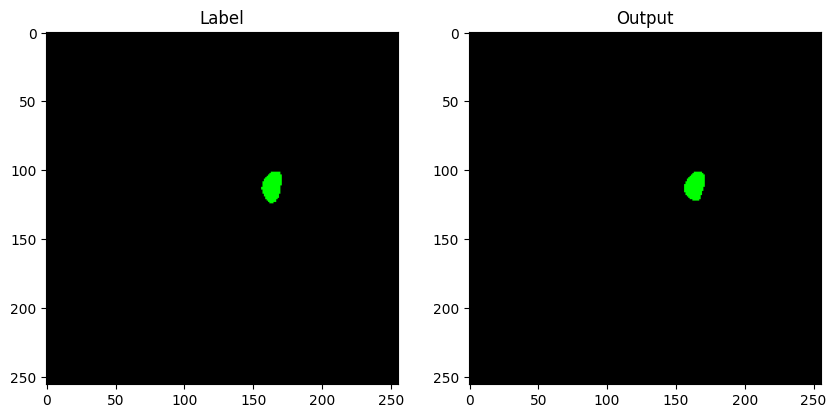

Epoch [130/300], Loss: 0.1308678816


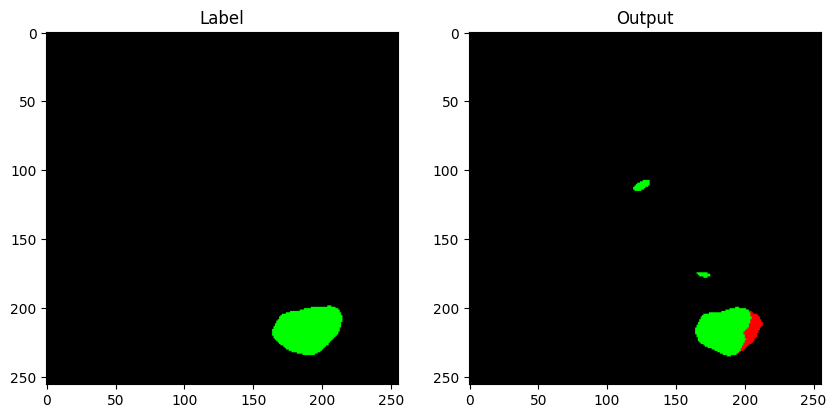

Epoch [131/300], Loss: 0.1305420115


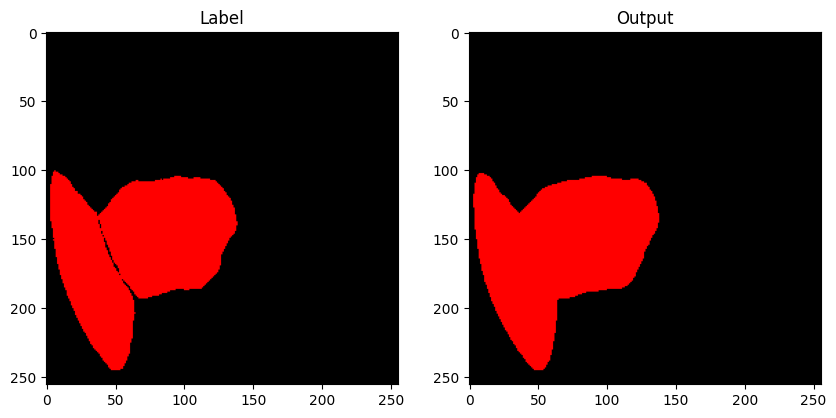

Epoch [132/300], Loss: 0.1432395978


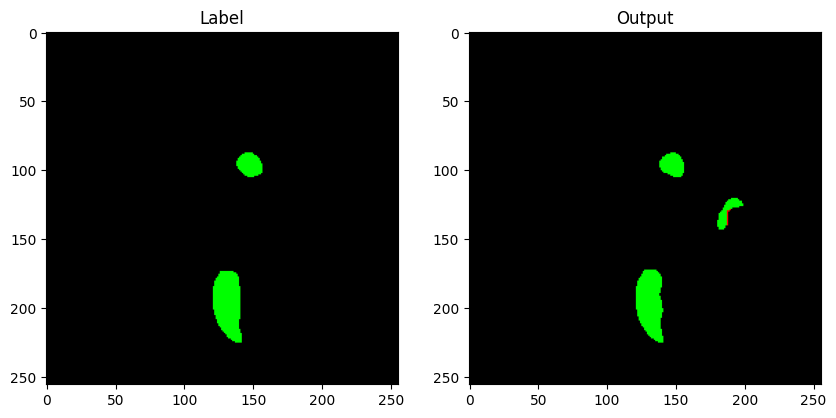

Epoch [133/300], Loss: 0.1530970839


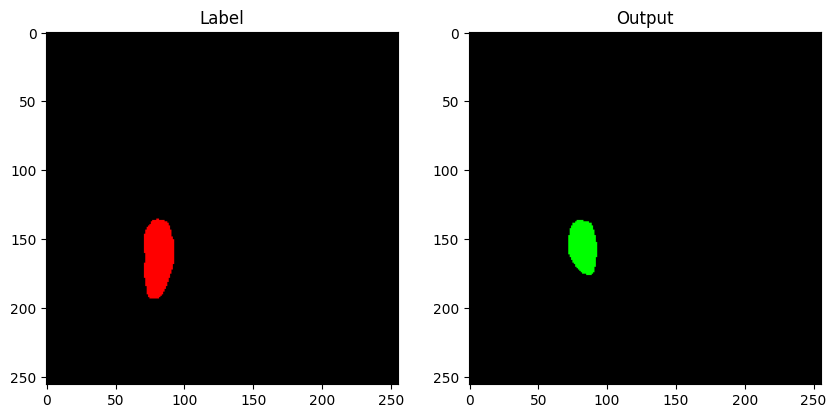

Epoch [134/300], Loss: 0.1259688748


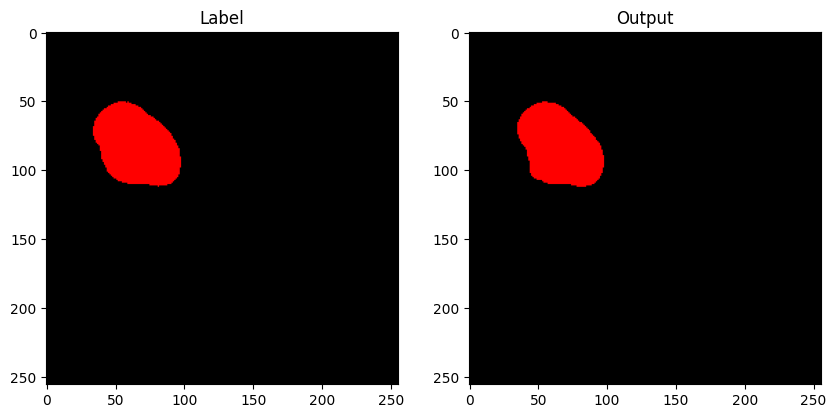

Epoch [135/300], Loss: 0.1434636403


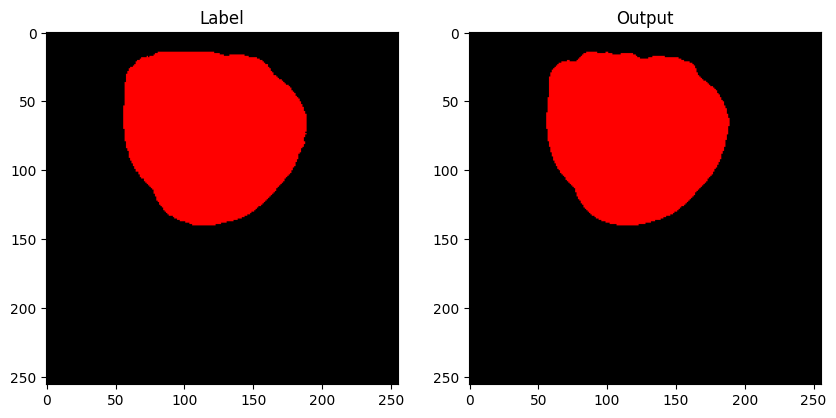

Epoch [136/300], Loss: 0.1494769093


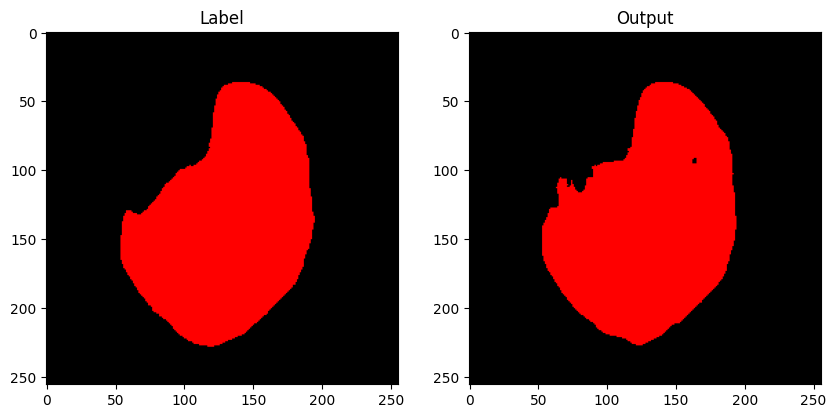

Epoch [137/300], Loss: 0.1461276840


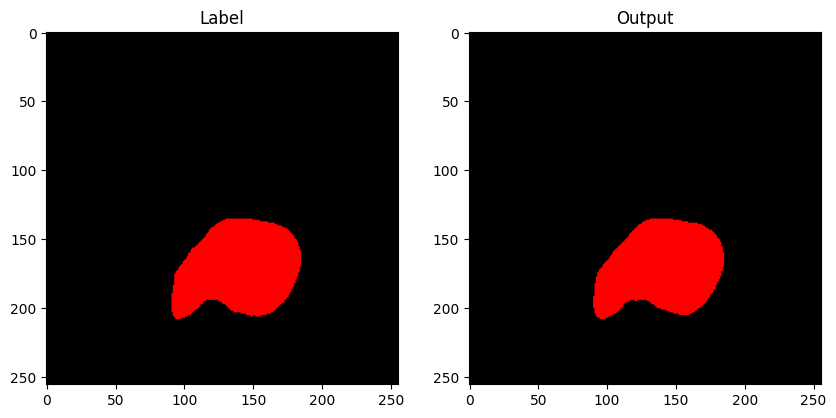

Epoch [138/300], Loss: 0.1435882931


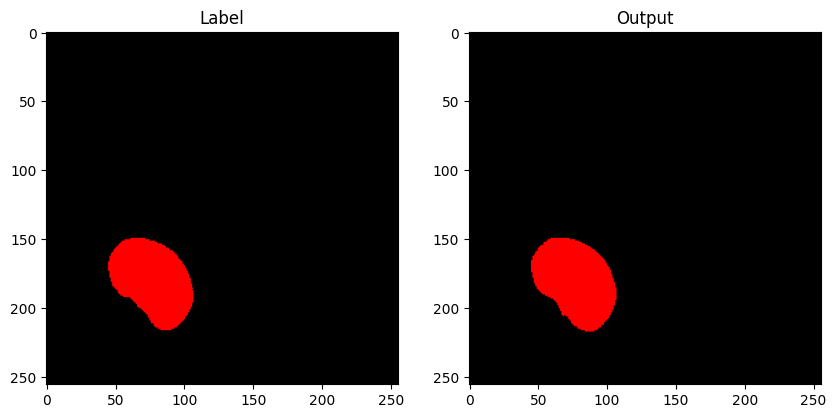

Epoch [139/300], Loss: 0.1663230238


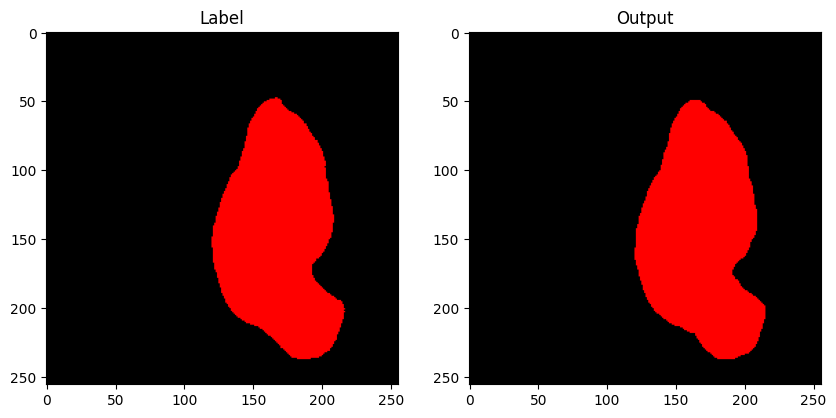

Epoch [140/300], Loss: 0.1572780437


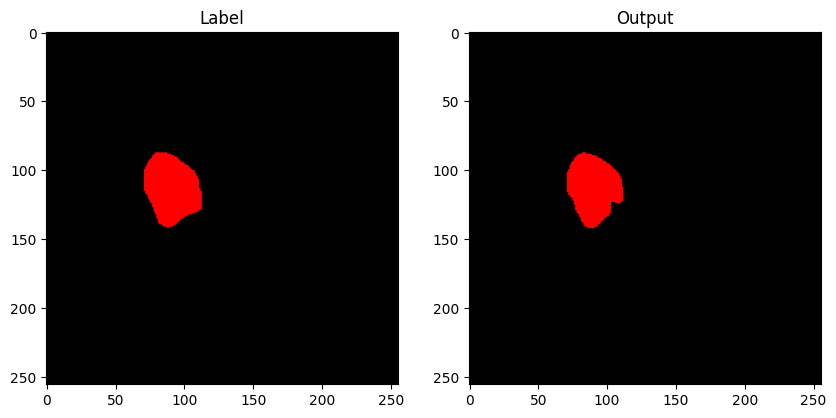

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


Epoch [141/300], Loss: 0.1079916540


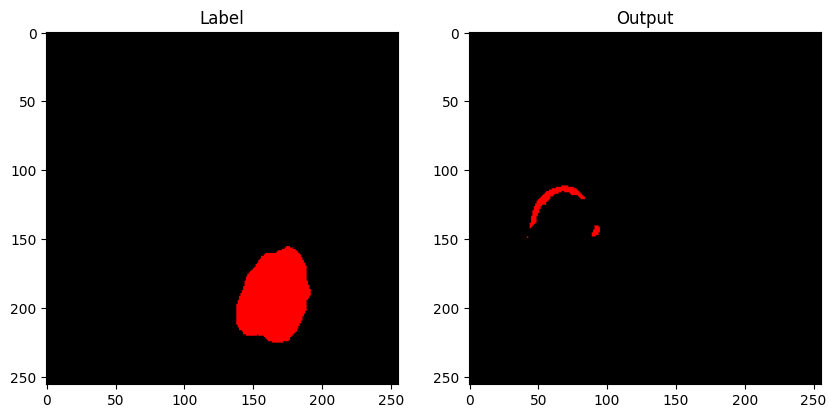

Epoch [142/300], Loss: 0.1319164654


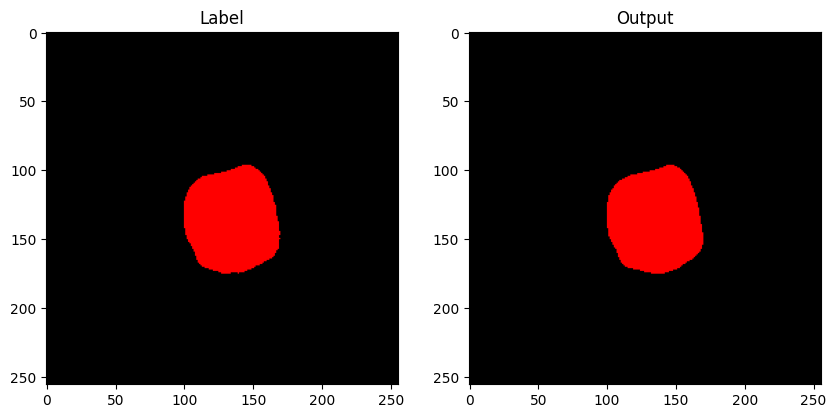

Epoch [143/300], Loss: 0.1347837359


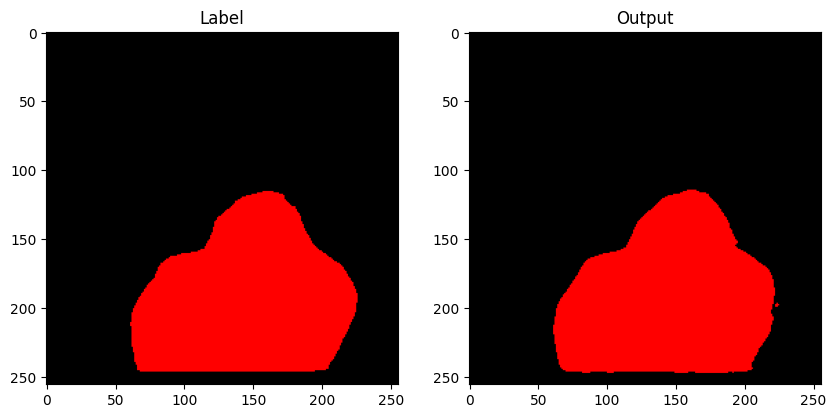

Epoch [144/300], Loss: 0.1164627946


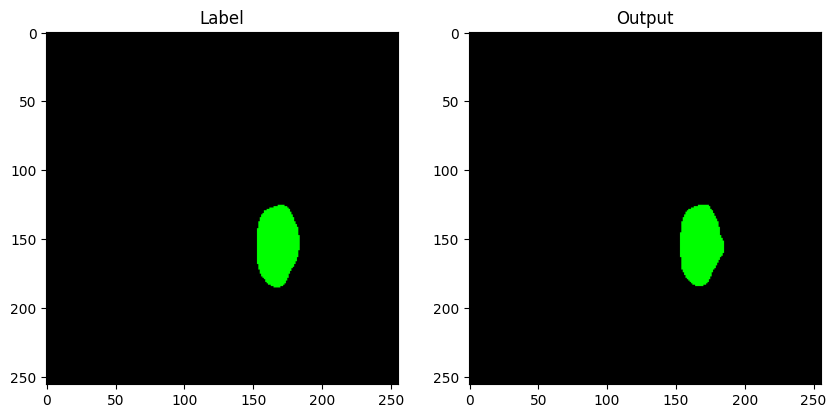

Epoch [145/300], Loss: 0.1221261090


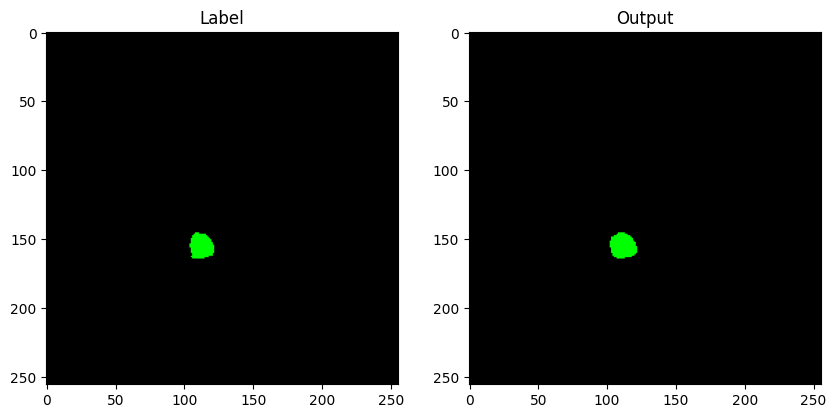

Epoch [146/300], Loss: 0.1467452986


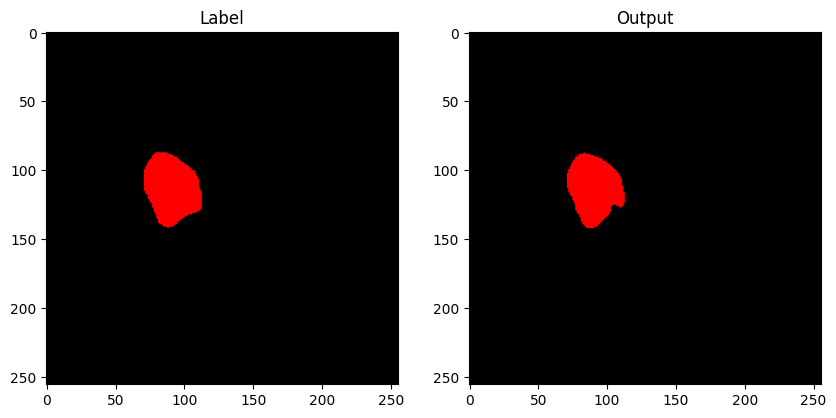

Epoch [147/300], Loss: 0.1359197777


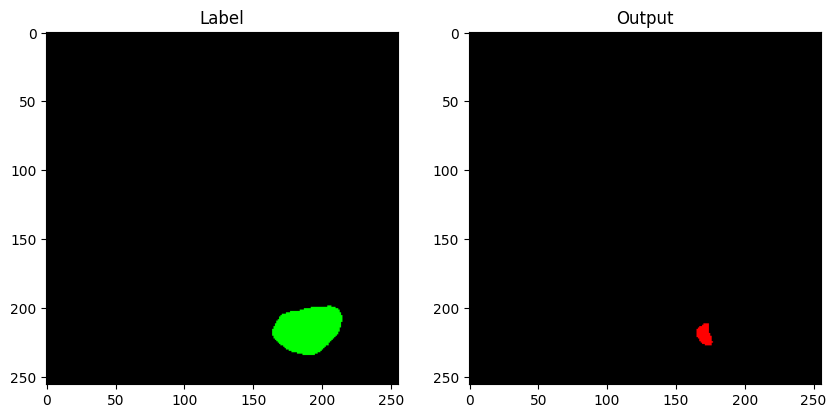

Epoch [148/300], Loss: 0.1264005106


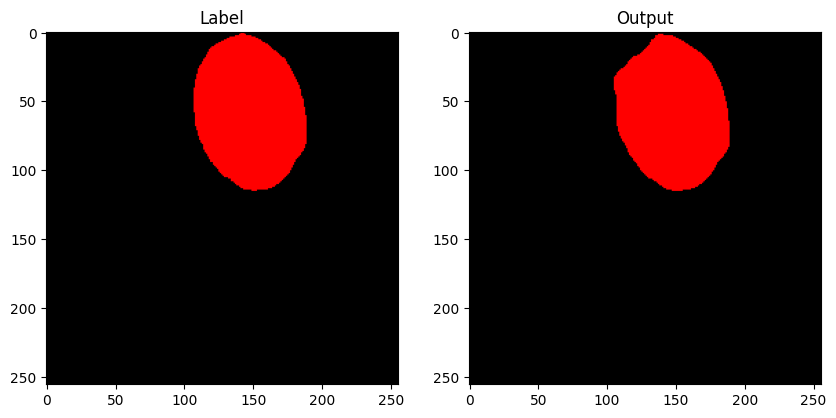

Epoch [149/300], Loss: 0.1068573369


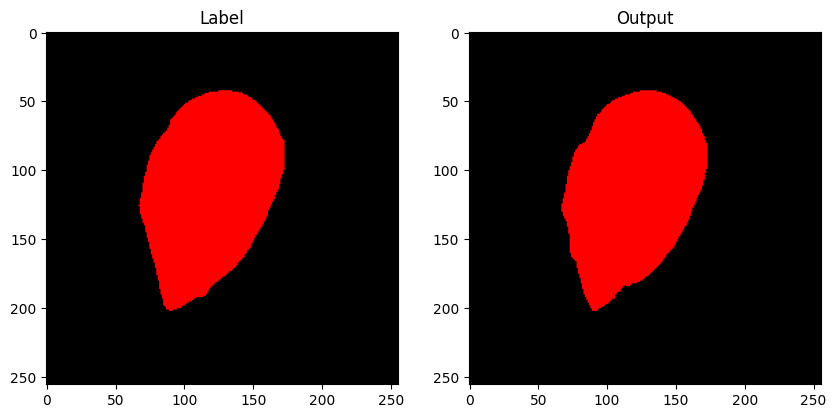

Epoch [150/300], Loss: 0.1130229804


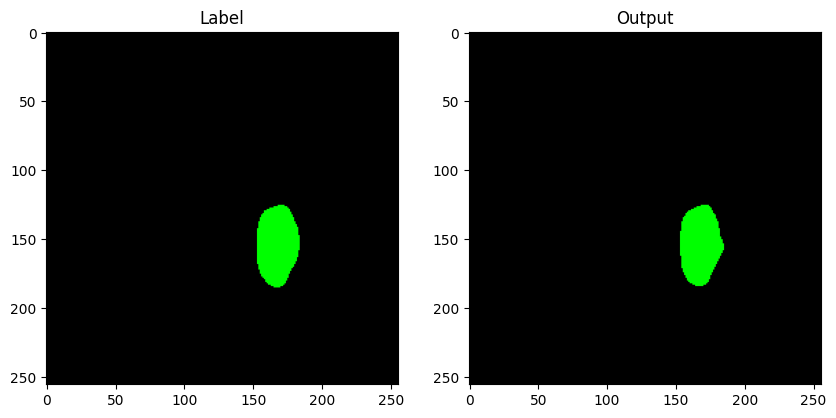

Epoch [151/300], Loss: 0.1186045836


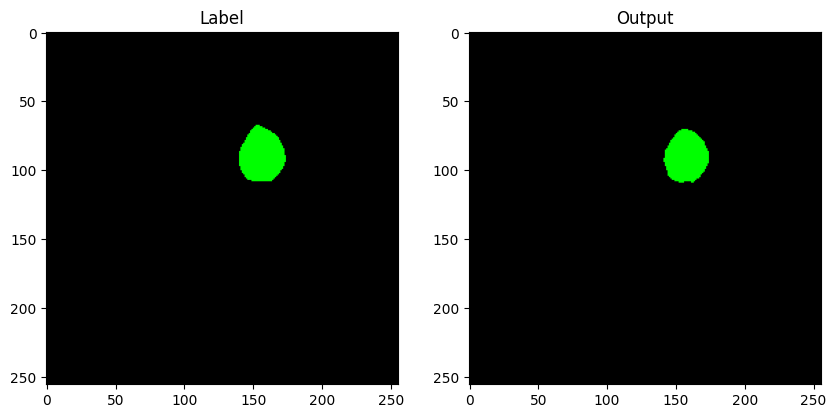

Epoch [152/300], Loss: 0.1392087272


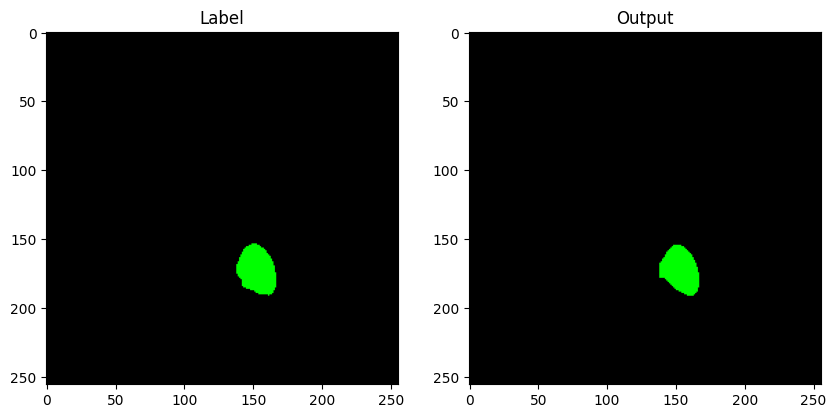

Epoch [153/300], Loss: 0.1142651784


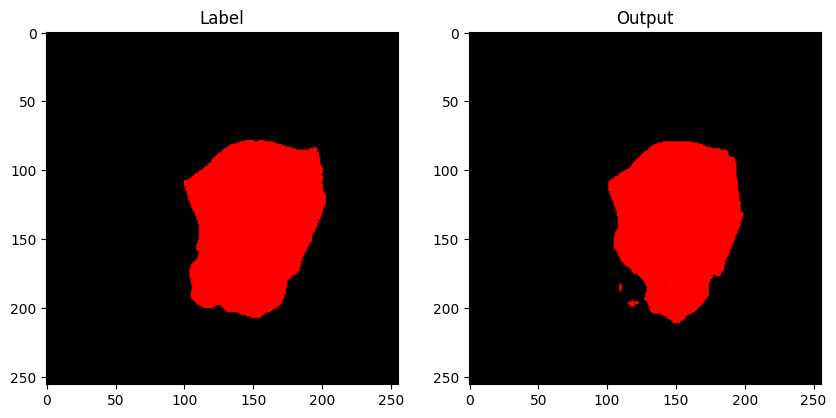

Epoch [154/300], Loss: 0.1146185273


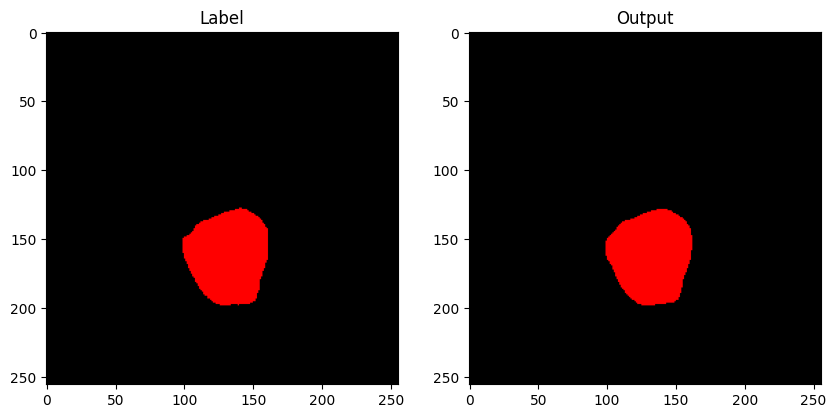

Epoch [155/300], Loss: 0.1171046149


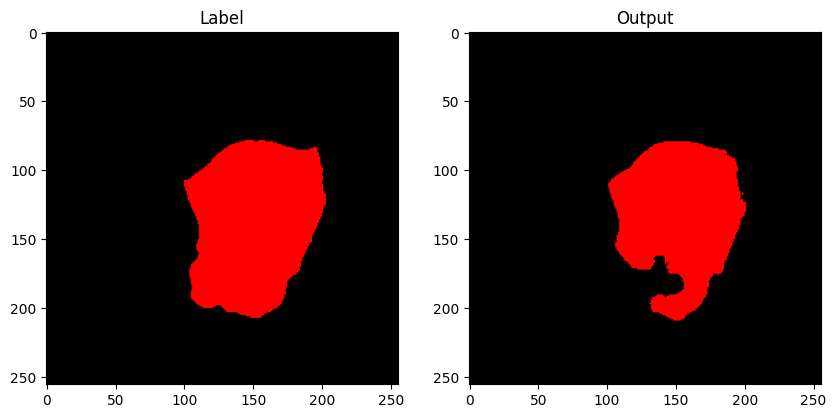

Epoch [156/300], Loss: 0.1251545589


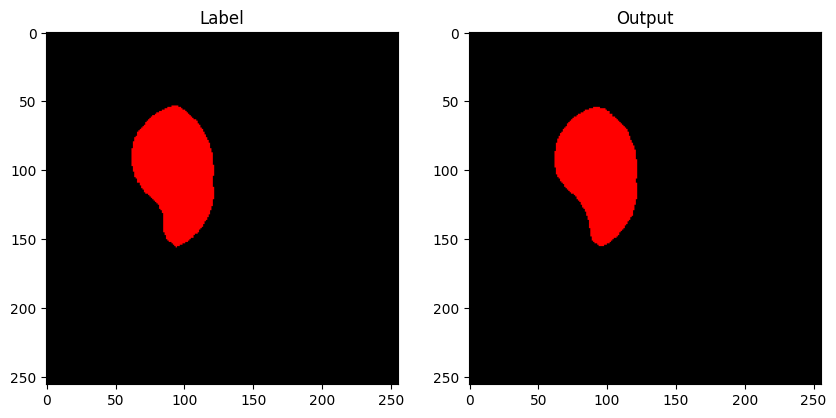

Epoch [157/300], Loss: 0.1228969940


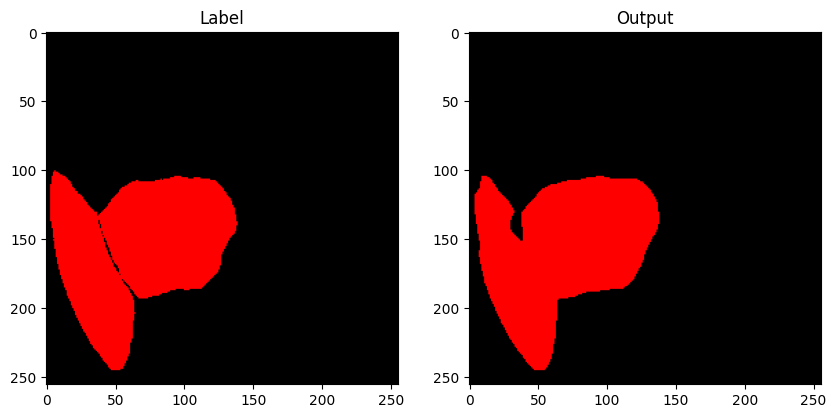

Epoch [158/300], Loss: 0.1207845005


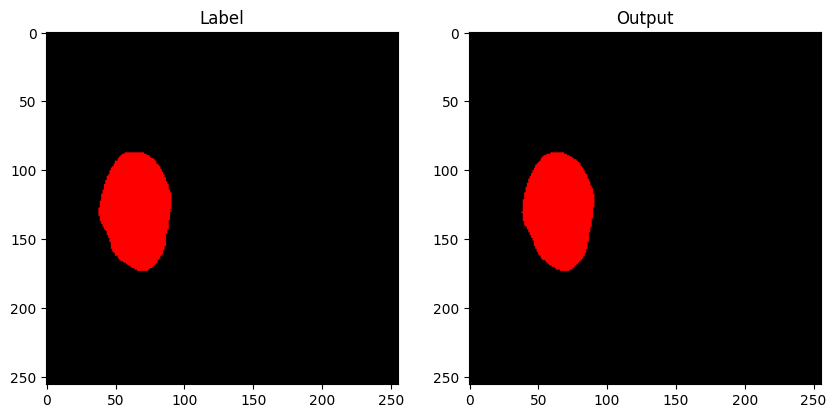

Epoch [159/300], Loss: 0.1211436796


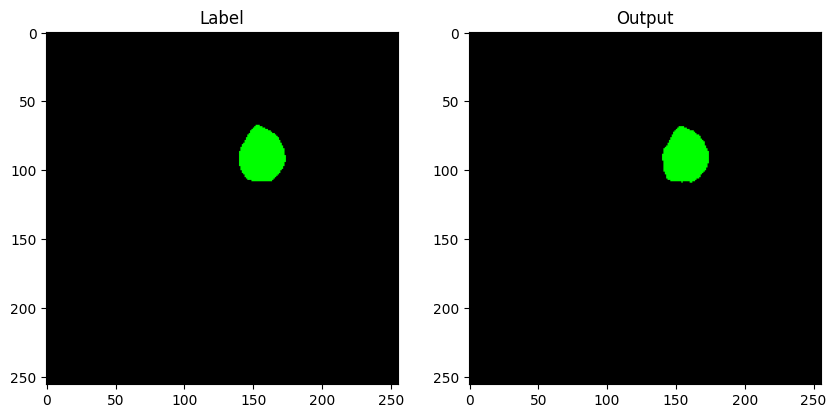

Epoch [160/300], Loss: 0.1344898214


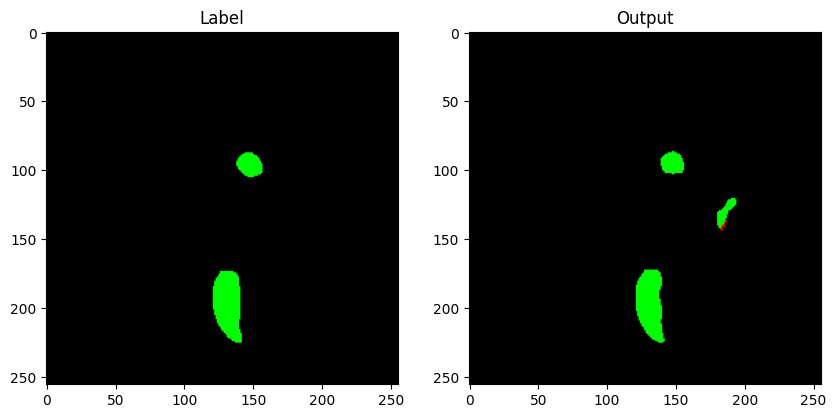

Epoch [161/300], Loss: 0.1611089016


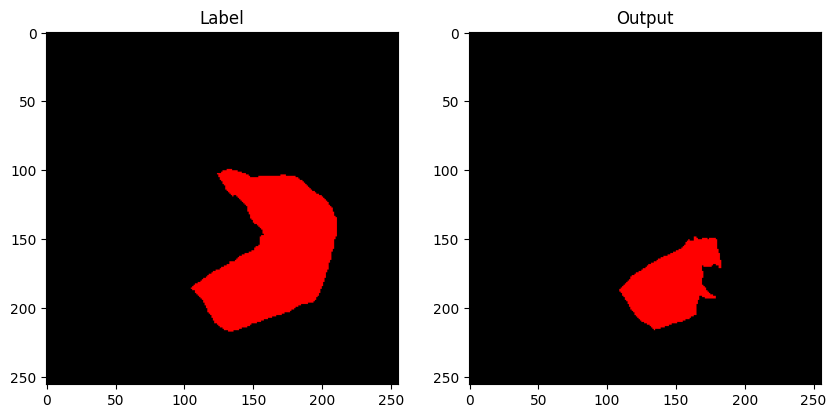

Epoch [162/300], Loss: 0.1631127544


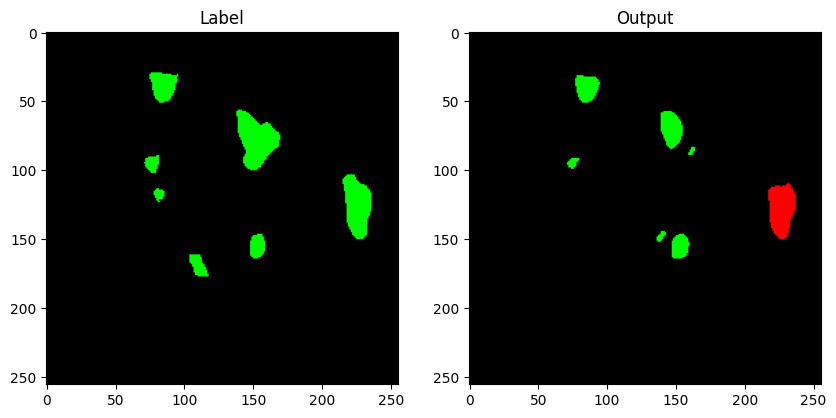

Epoch [163/300], Loss: 0.1358753593


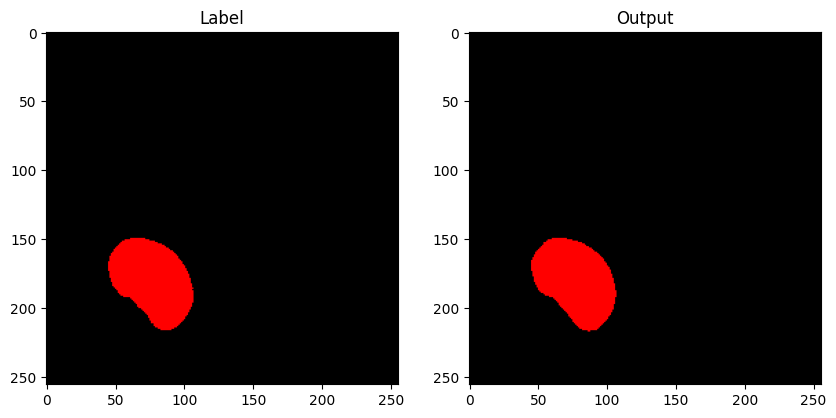

Epoch [164/300], Loss: 0.1346295214


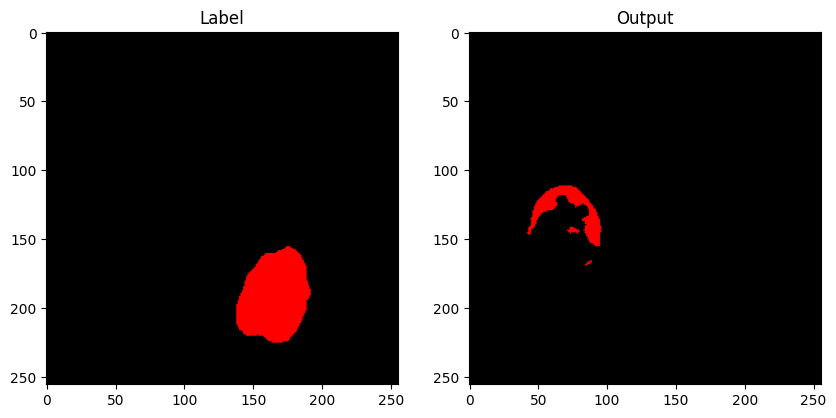

Epoch [165/300], Loss: 0.1588974025


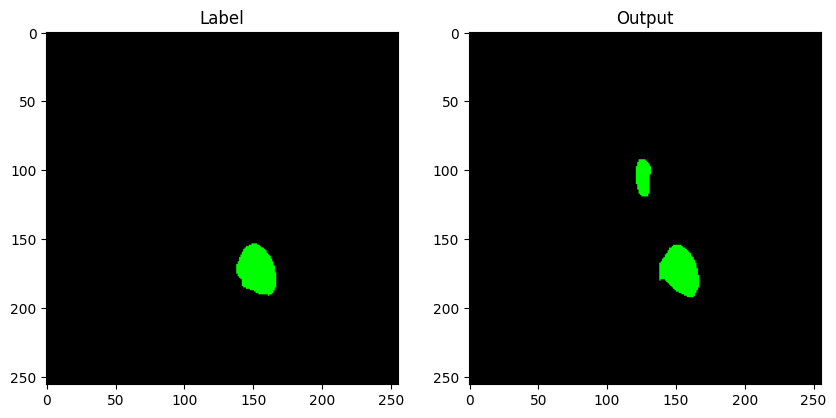

Epoch [166/300], Loss: 0.1447330074


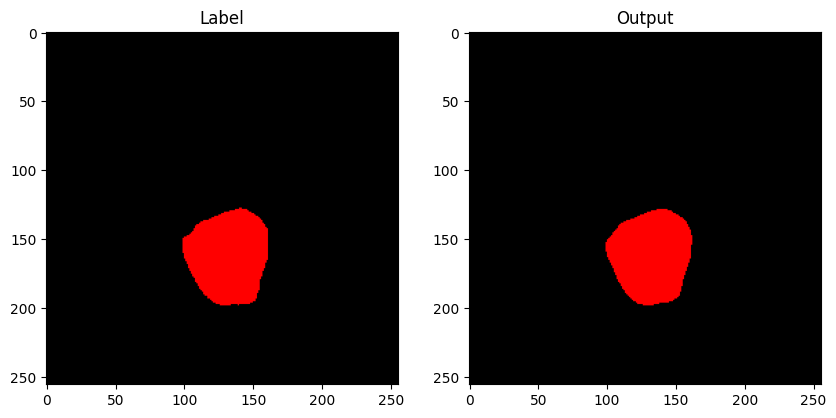

Epoch [167/300], Loss: 0.1490877964


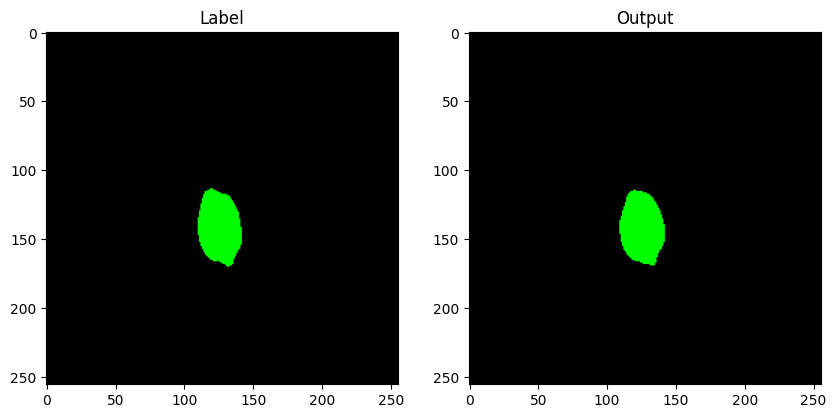

Epoch [168/300], Loss: 0.1346113169


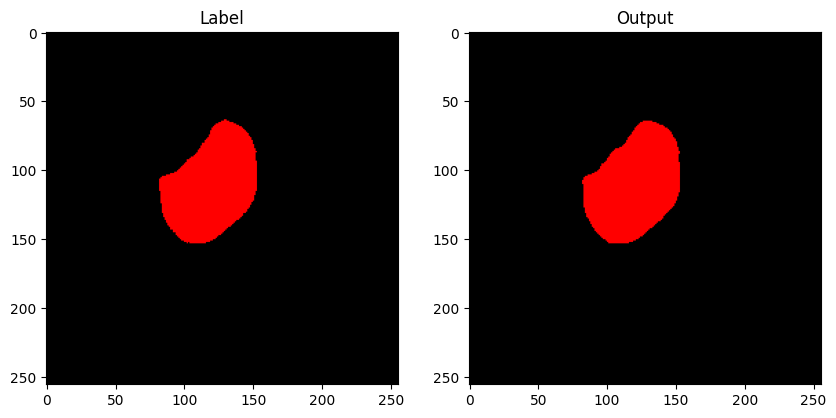

Epoch [169/300], Loss: 0.1200736586


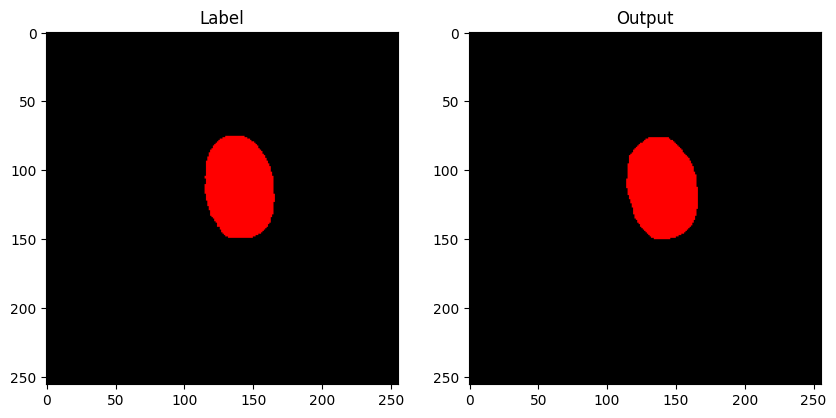

Epoch [170/300], Loss: 0.1248511070


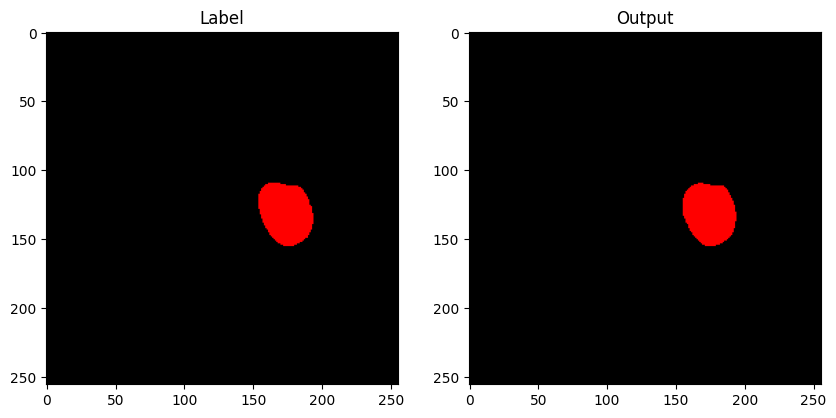

Epoch [171/300], Loss: 0.1287490794


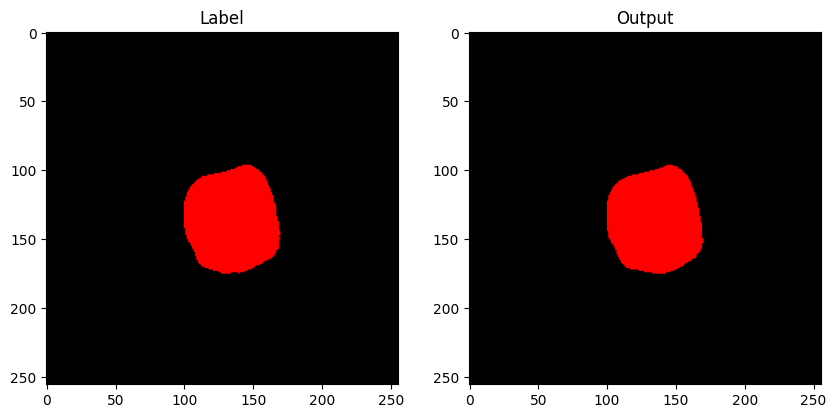

Epoch [172/300], Loss: 0.1094363450


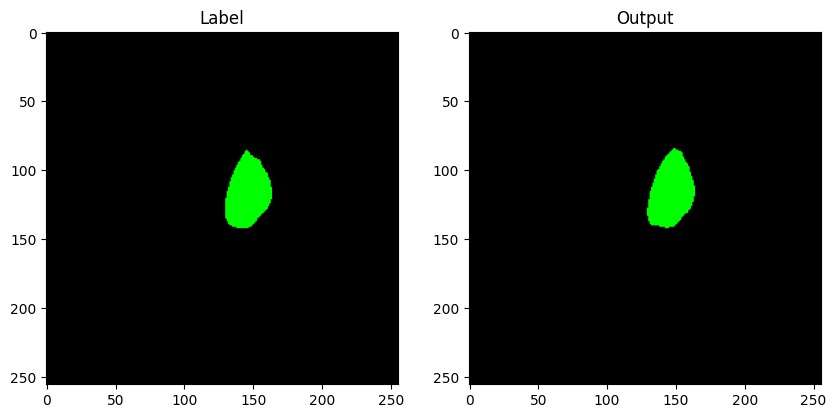

Epoch [173/300], Loss: 0.1361368783


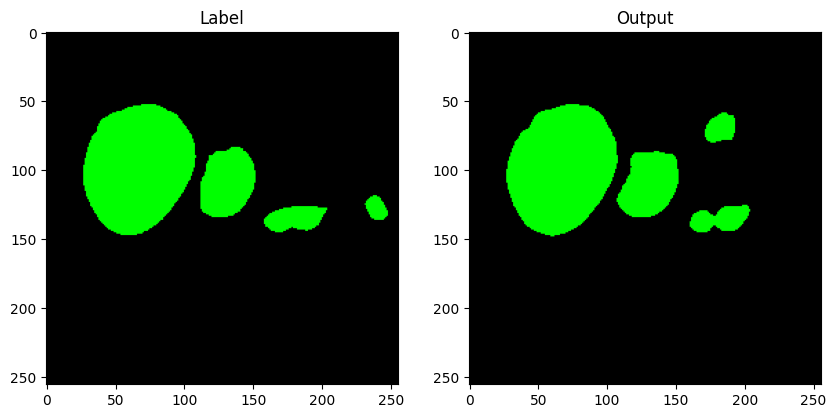

Epoch [174/300], Loss: 0.1386929575


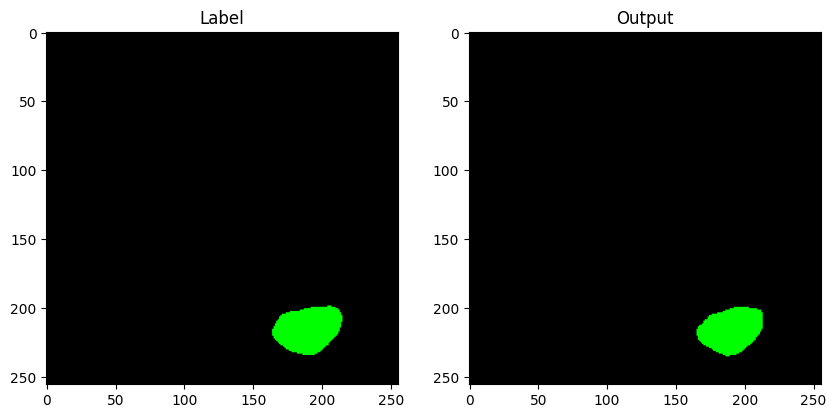

Epoch [175/300], Loss: 0.1095041915


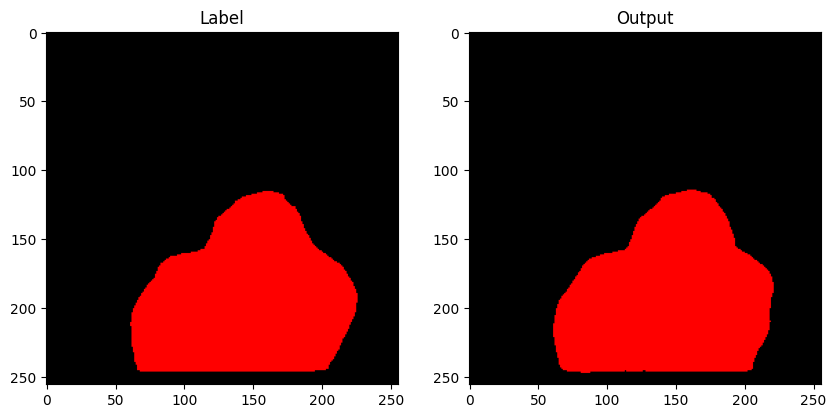

Epoch [176/300], Loss: 0.1186361860


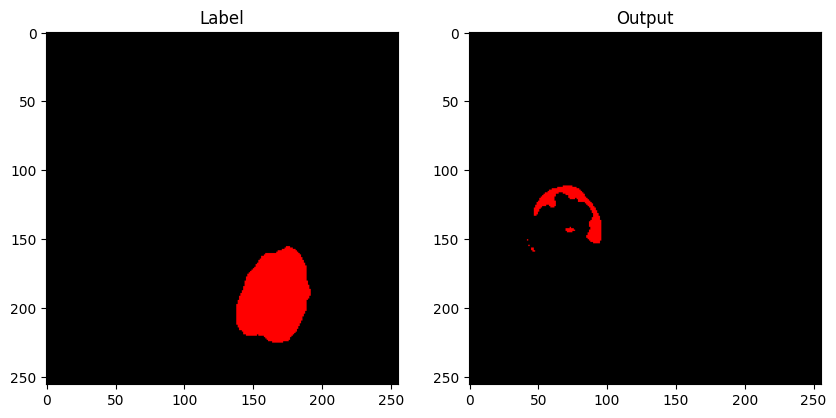

Epoch [177/300], Loss: 0.1140058598


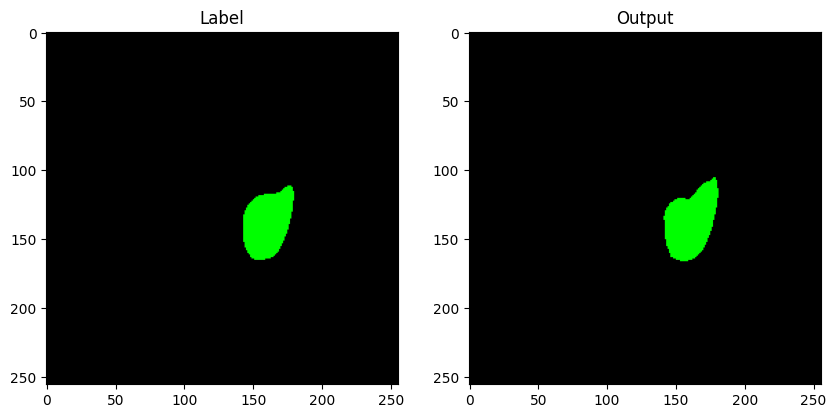

Epoch [178/300], Loss: 0.1171659032


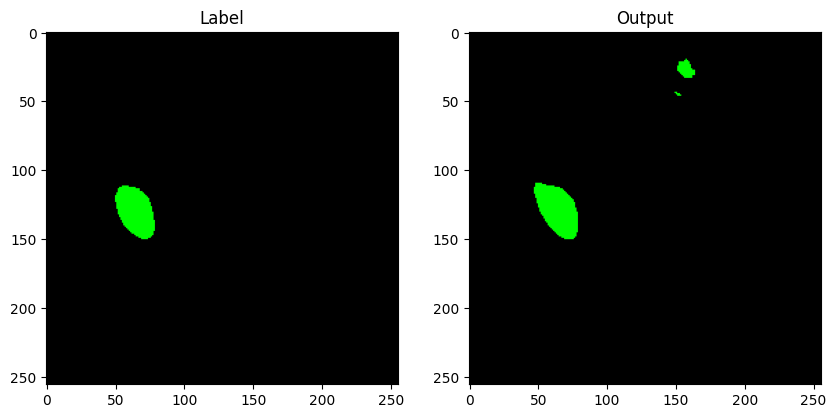

Epoch [179/300], Loss: 0.1361095643


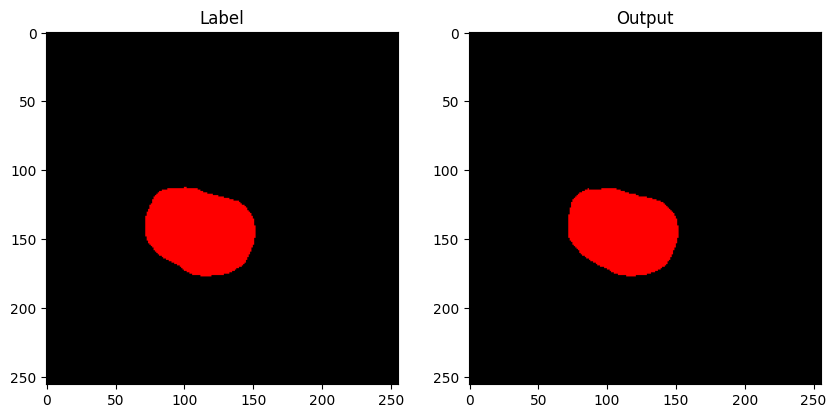

Epoch [180/300], Loss: 0.0990819066
Save new model


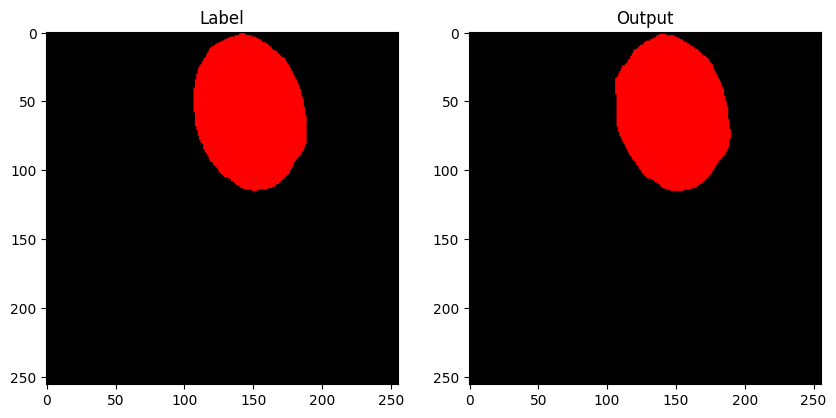

Epoch [181/300], Loss: 0.1046344168


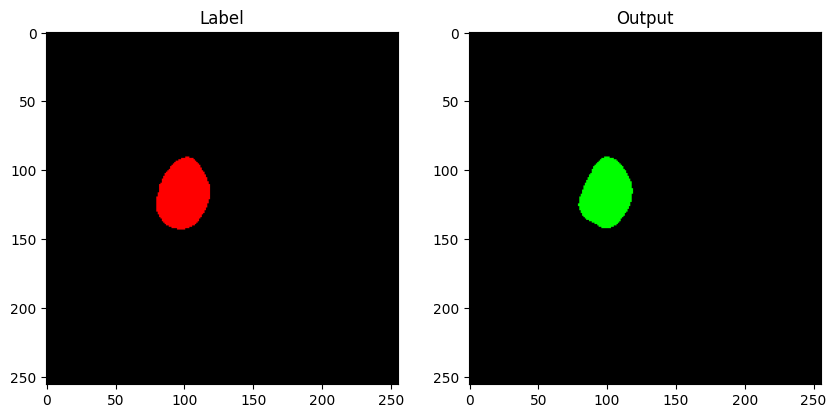

Epoch [182/300], Loss: 0.0890818817
Save new model


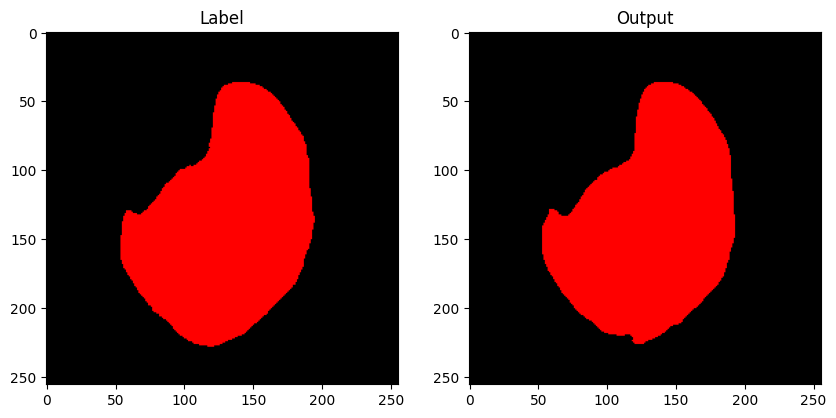

Epoch [183/300], Loss: 0.1053948090


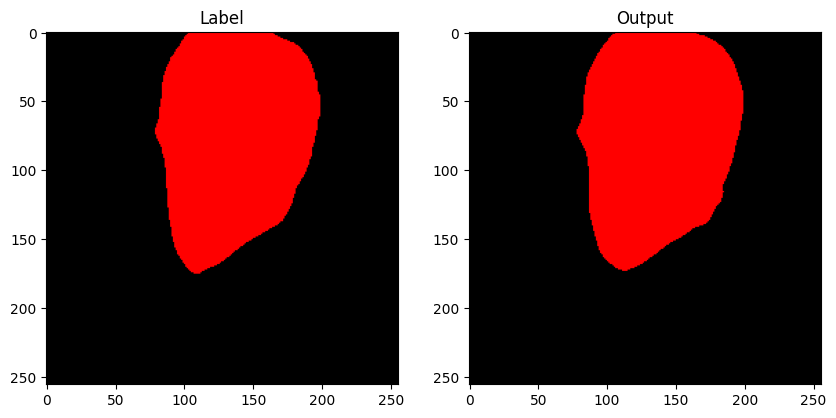

Epoch [184/300], Loss: 0.1255678320


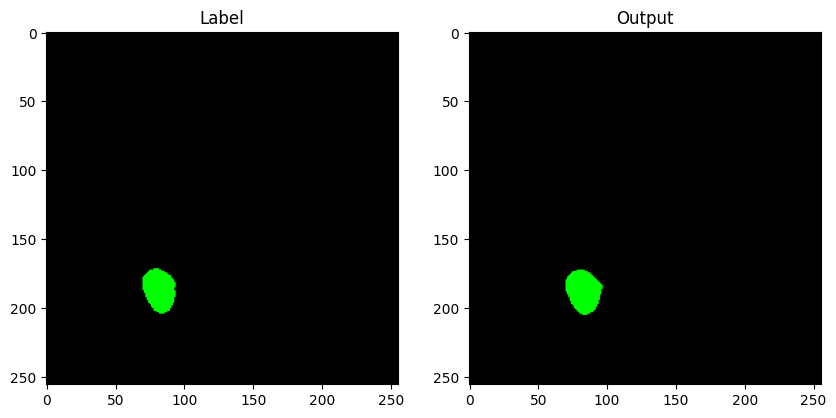

Epoch [185/300], Loss: 0.1530554620


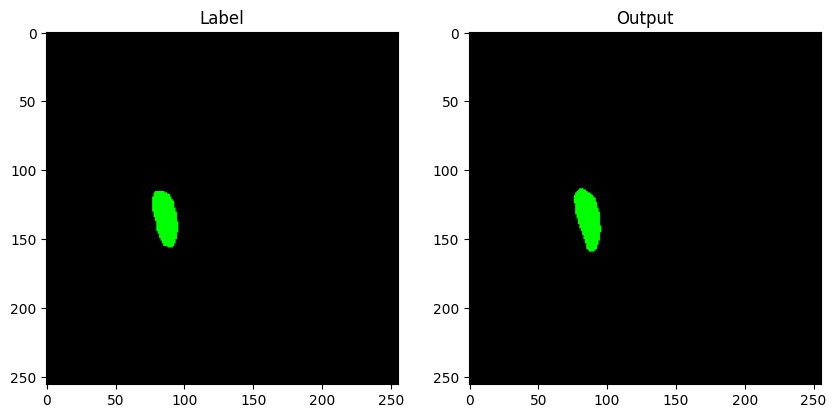

Epoch [186/300], Loss: 0.1544994907


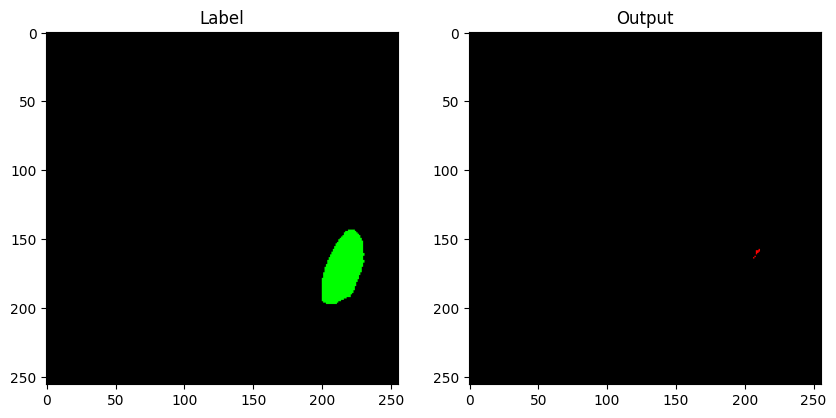

Epoch [187/300], Loss: 0.1343051495


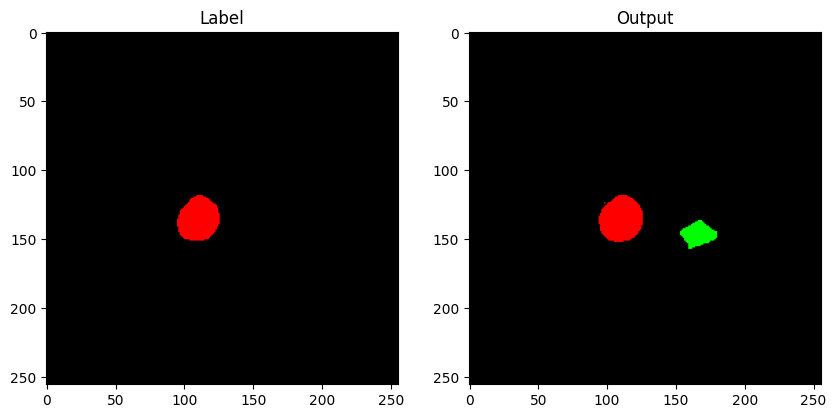

Epoch [188/300], Loss: 0.1391677874


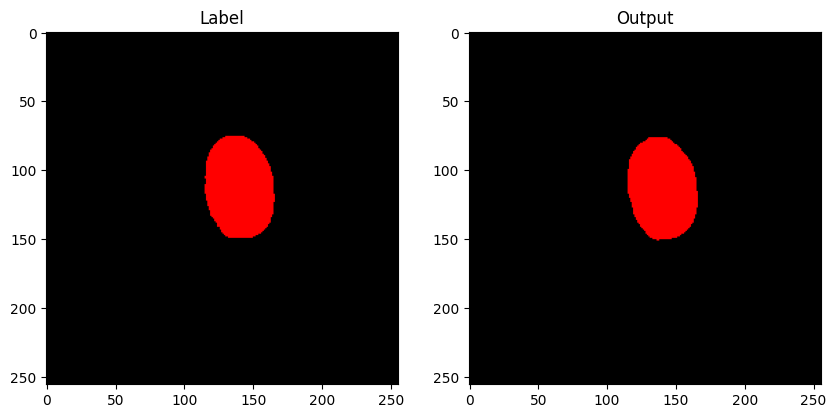

Epoch [189/300], Loss: 0.1283270706


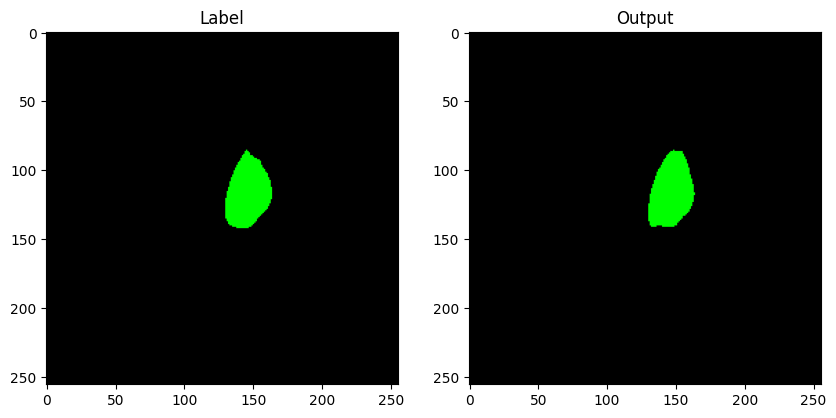

Epoch [190/300], Loss: 0.1422339361


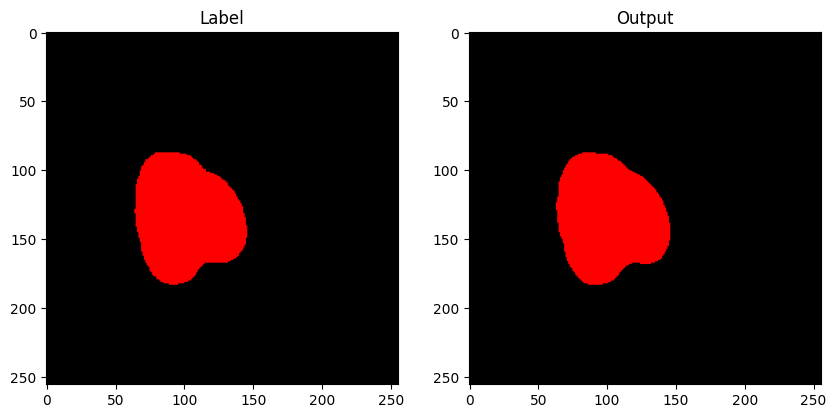

Epoch [191/300], Loss: 0.1351844706


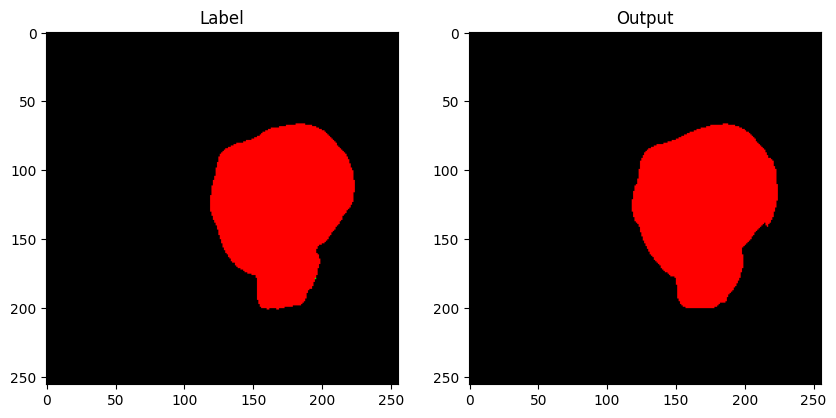

Epoch [192/300], Loss: 0.1508705231


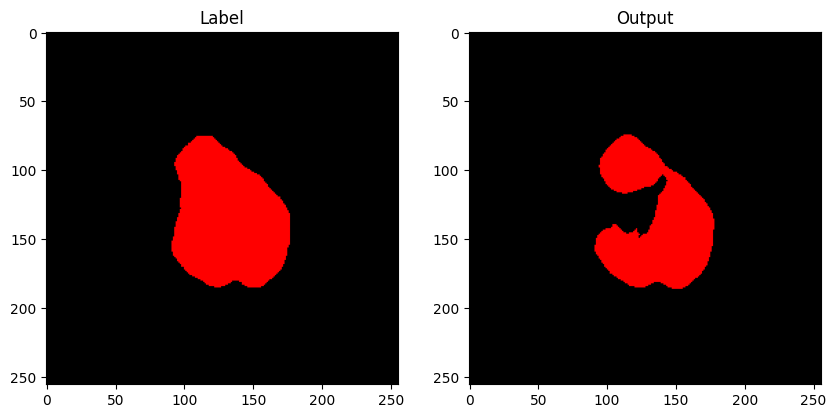

Epoch [193/300], Loss: 0.1405599477


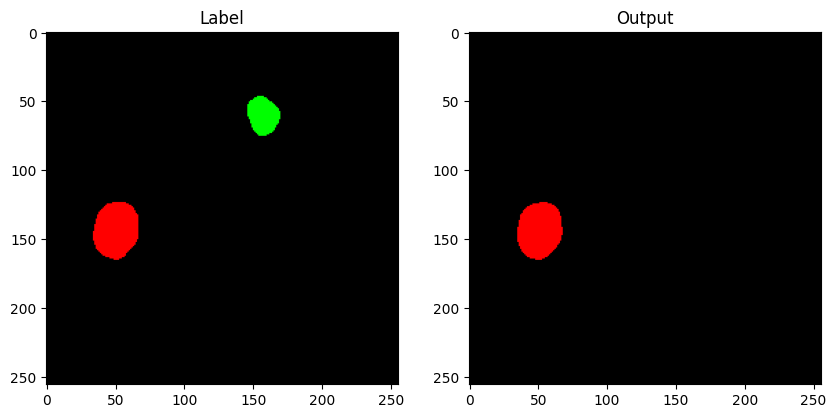

Epoch [194/300], Loss: 0.1210618813


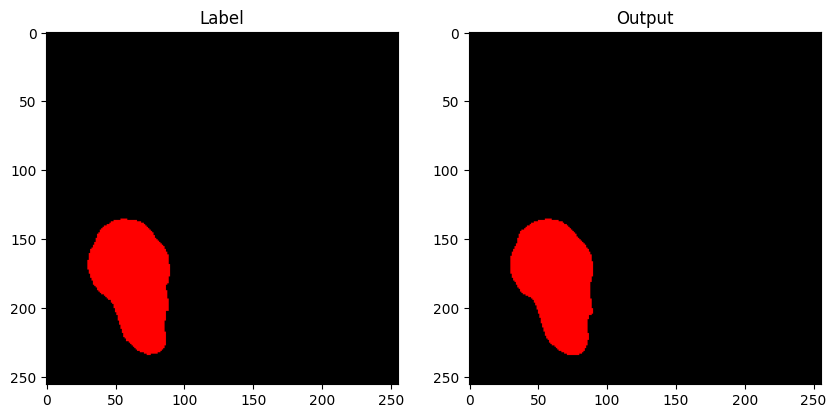

Epoch [195/300], Loss: 0.1324830883


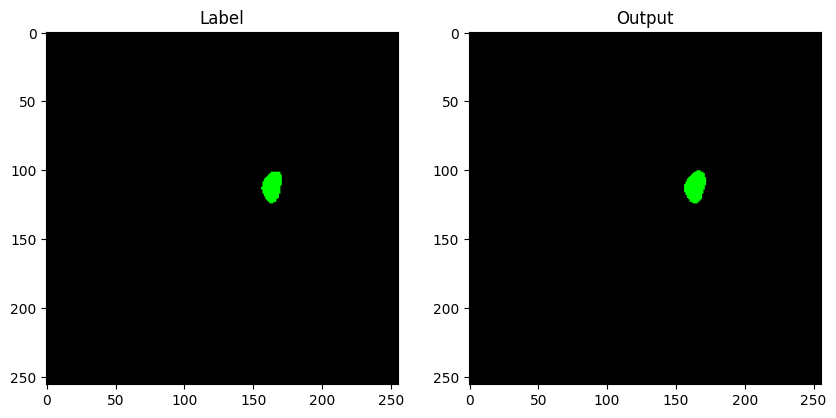

Epoch [196/300], Loss: 0.1252097465


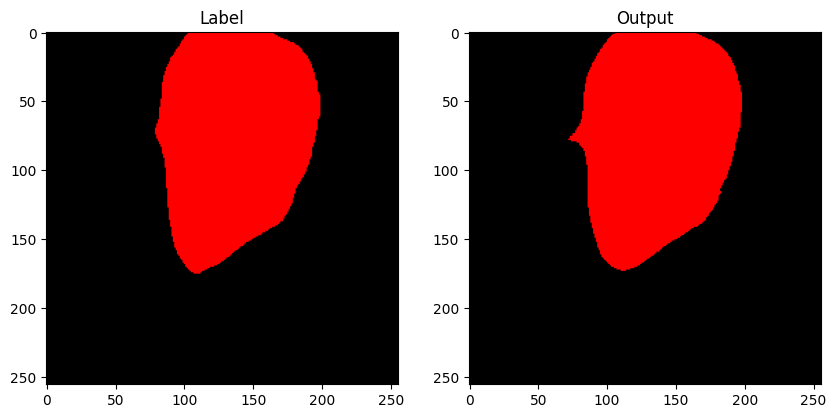

Epoch [197/300], Loss: 0.1407098107


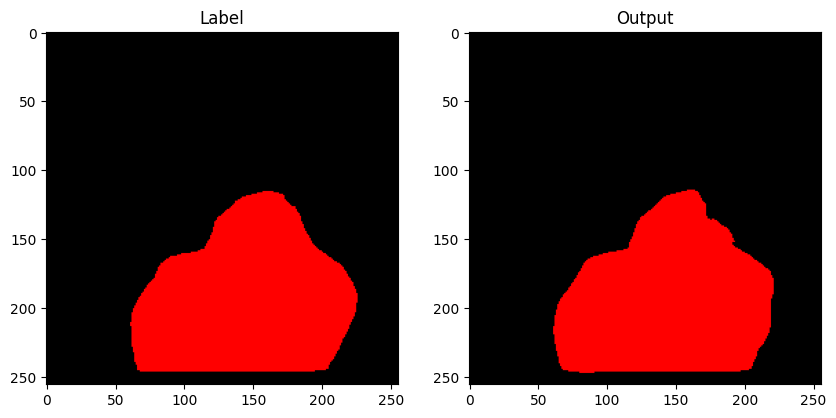

Epoch [198/300], Loss: 0.1439360458


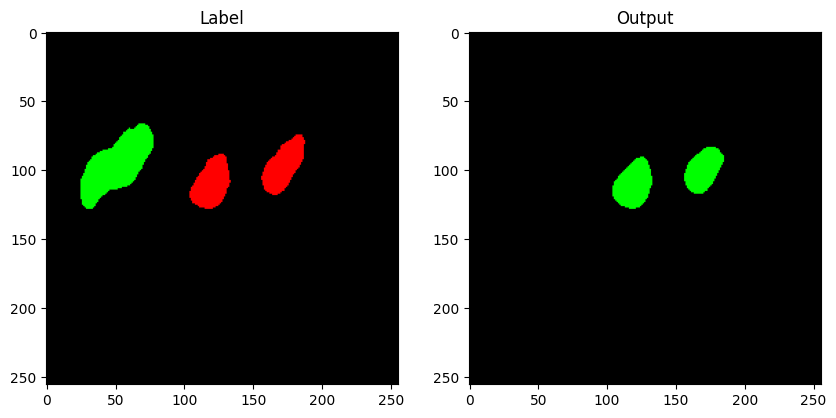

Epoch [199/300], Loss: 0.1098166653


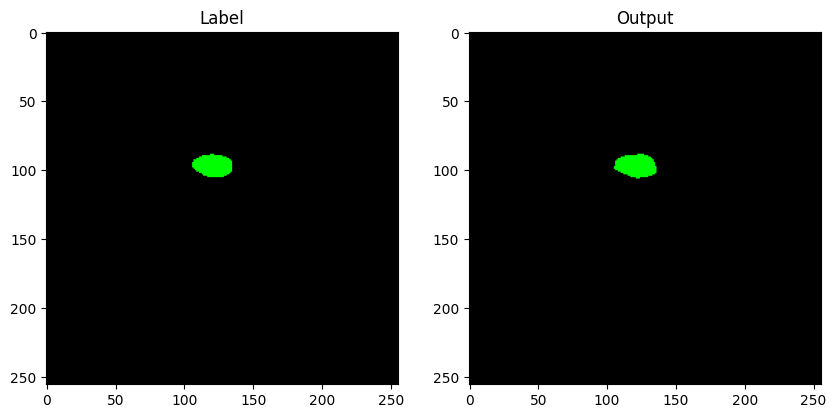

Epoch [200/300], Loss: 0.1217930290


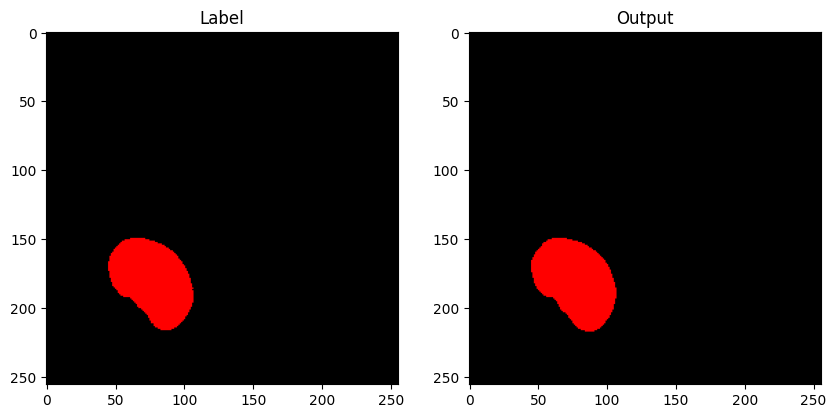

Epoch [201/300], Loss: 0.1137357363


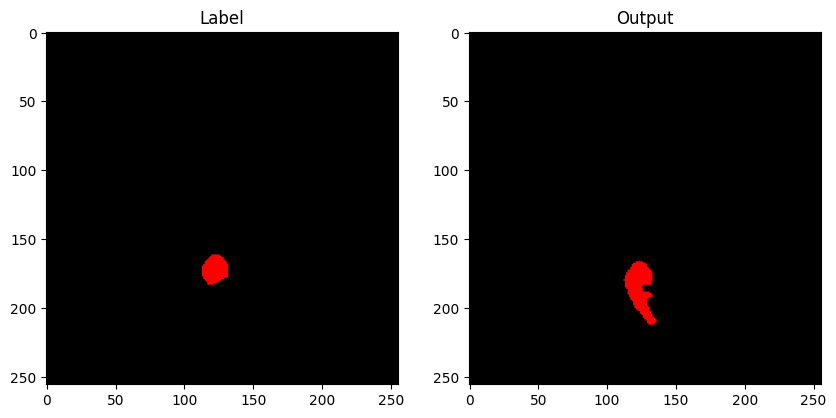

Epoch [202/300], Loss: 0.1151048197


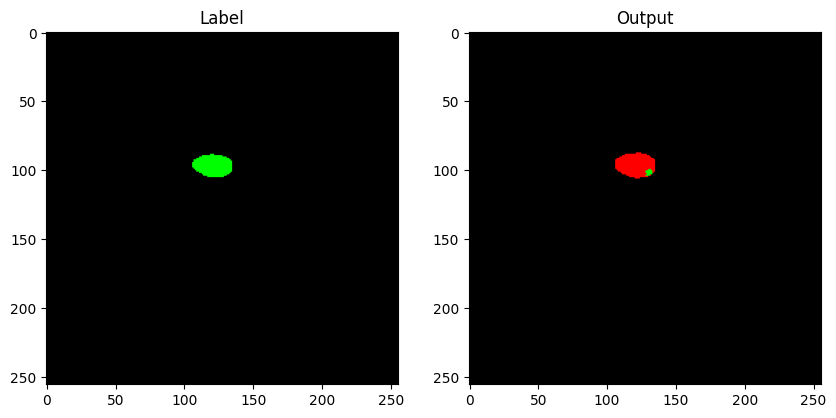

Epoch [203/300], Loss: 0.1486842869


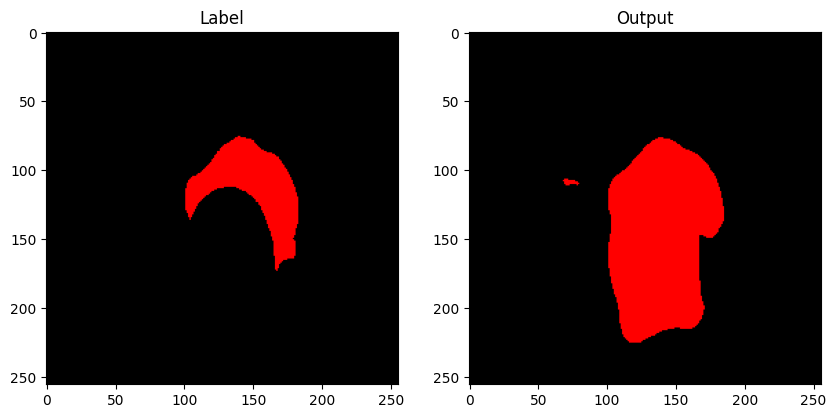

Epoch [204/300], Loss: 0.1271524964


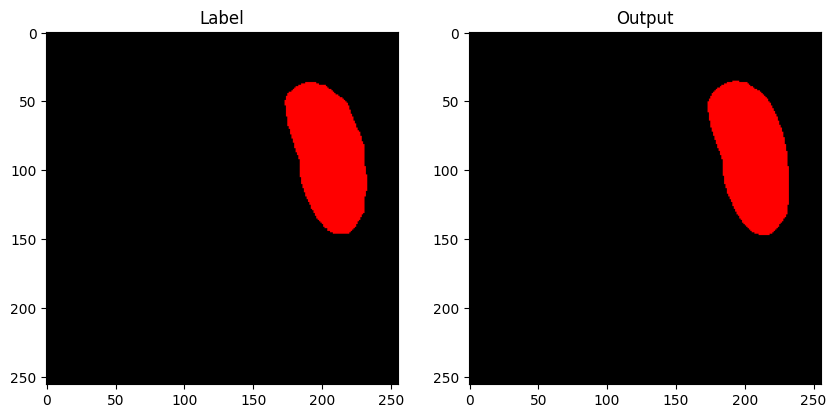

Epoch [205/300], Loss: 0.1153379110


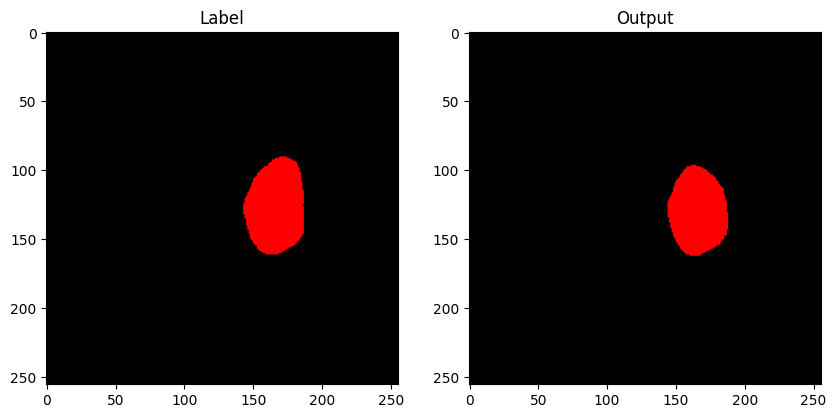

Epoch [206/300], Loss: 0.1468398022


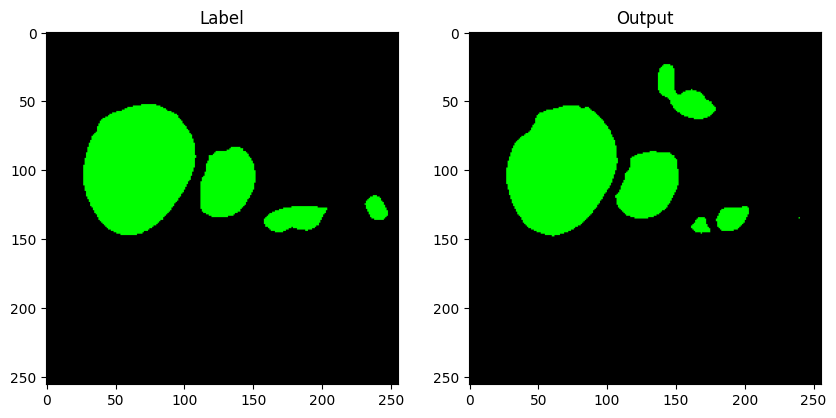

Epoch [207/300], Loss: 0.1401035548


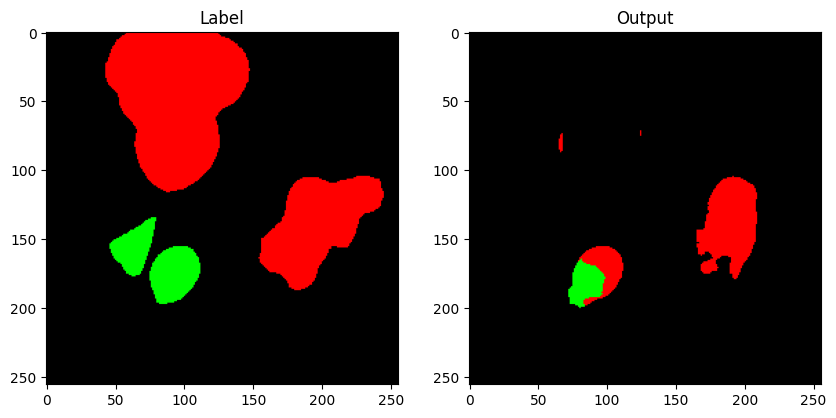

Epoch [208/300], Loss: 0.1181139601


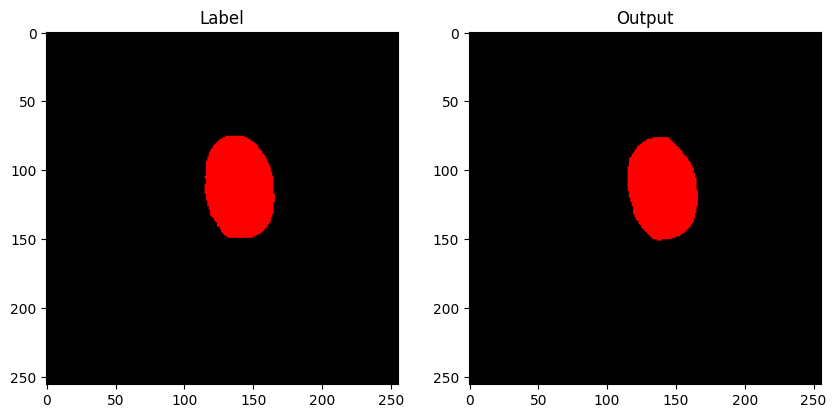

Epoch [209/300], Loss: 0.1307292254


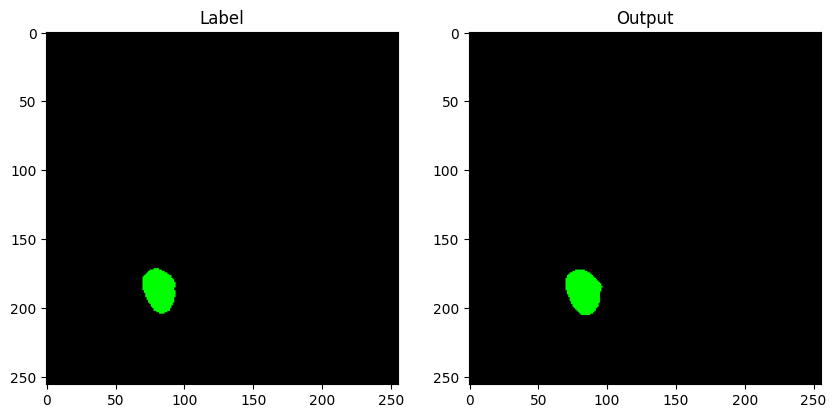

Epoch [210/300], Loss: 0.1359074233


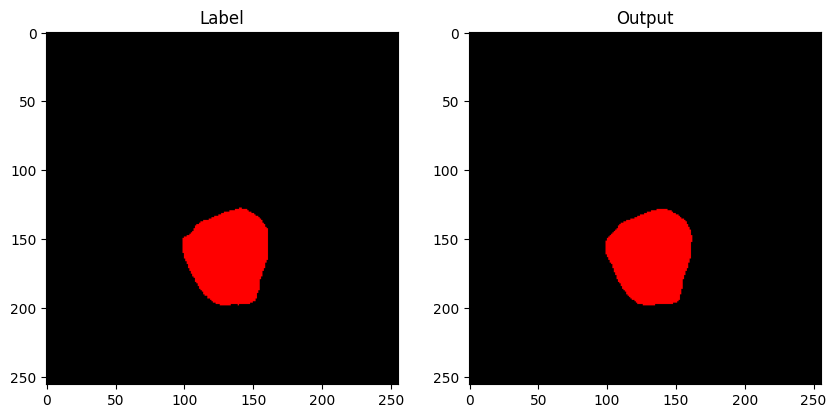

Epoch [211/300], Loss: 0.1324433928


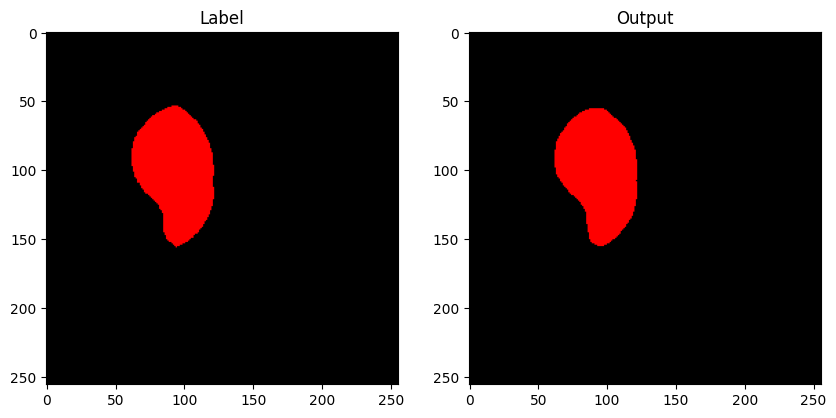

Epoch [212/300], Loss: 0.1370264882


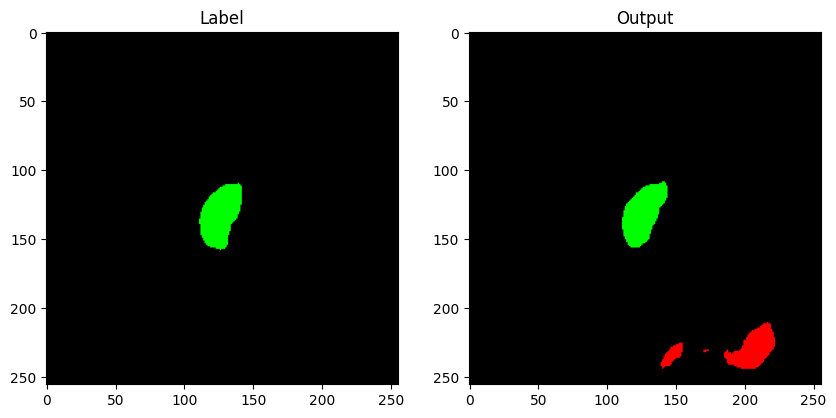

Epoch [213/300], Loss: 0.1323894469


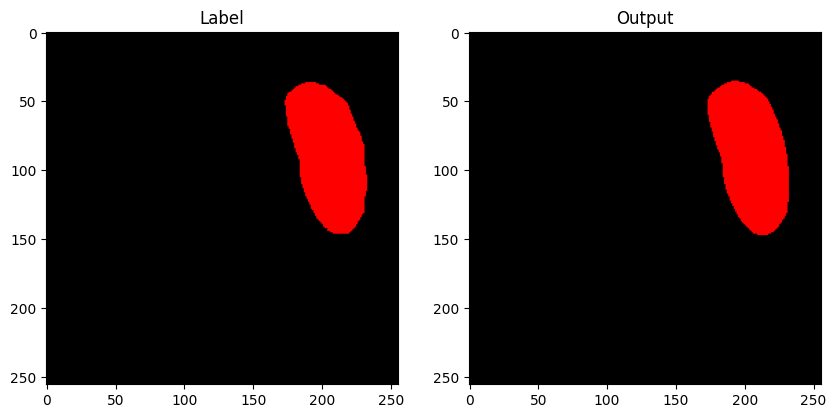

Epoch [214/300], Loss: 0.1267840175


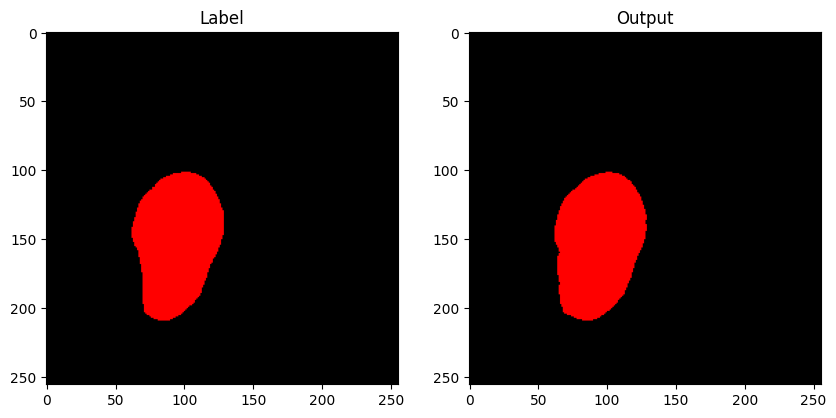

Epoch [215/300], Loss: 0.1262894382


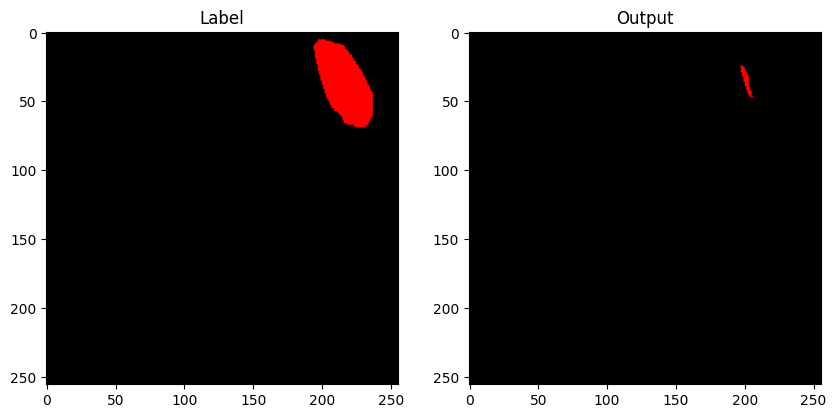

Epoch [216/300], Loss: 0.1269600026


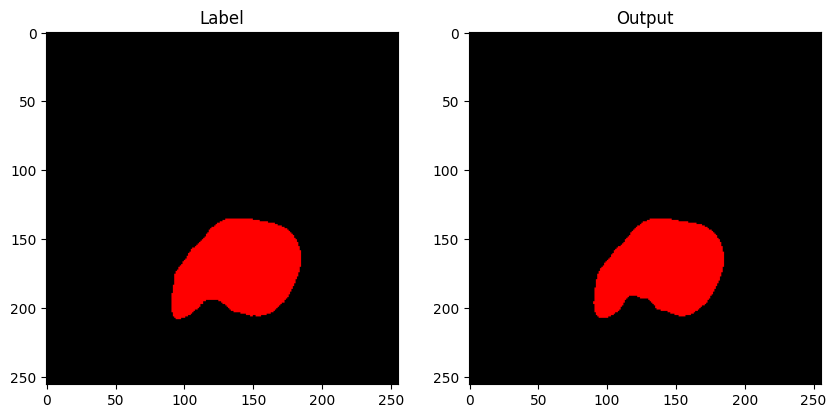

Epoch [217/300], Loss: 0.1377877398


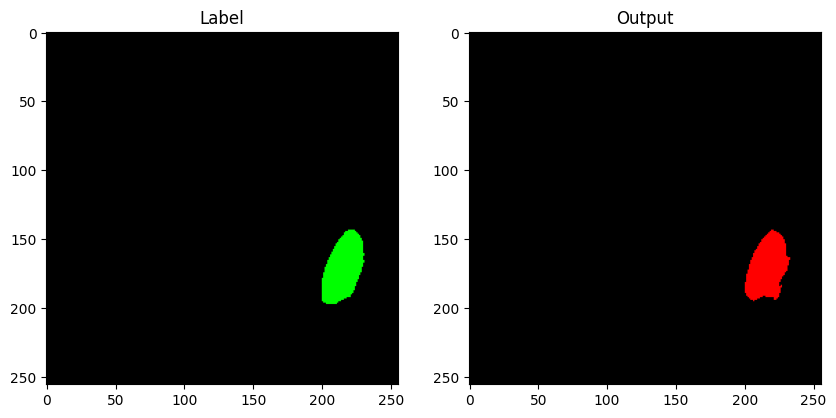

Epoch [218/300], Loss: 0.1090104889


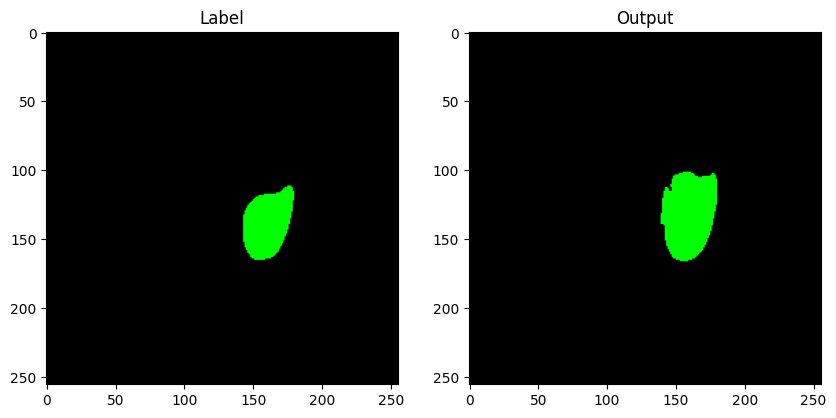

Epoch [219/300], Loss: 0.1375880524


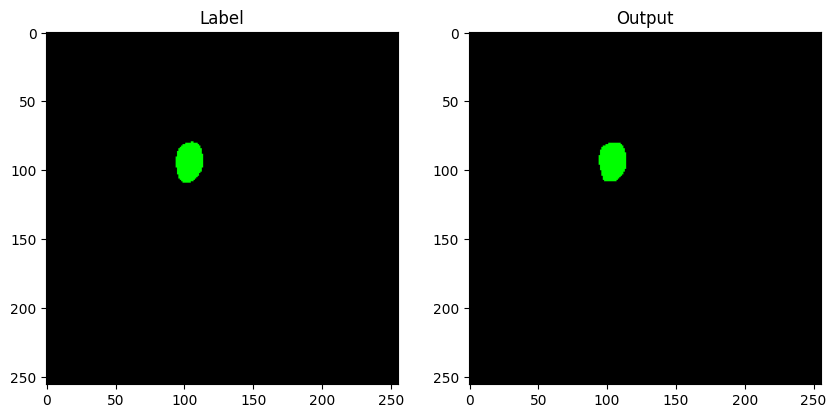

Epoch [220/300], Loss: 0.1190759358


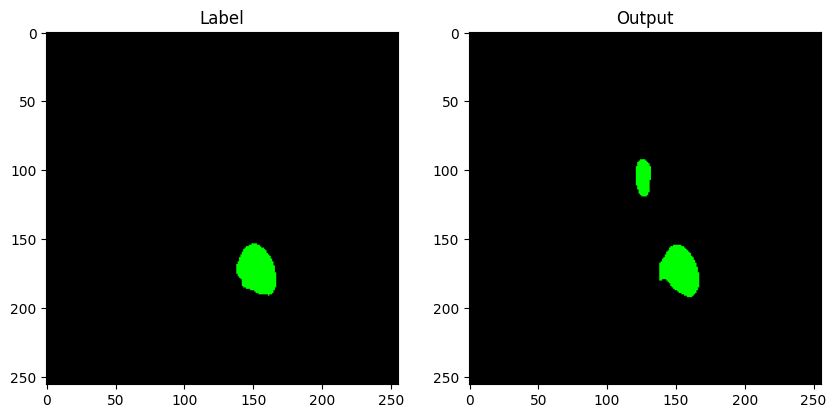

Epoch [221/300], Loss: 0.1563234321


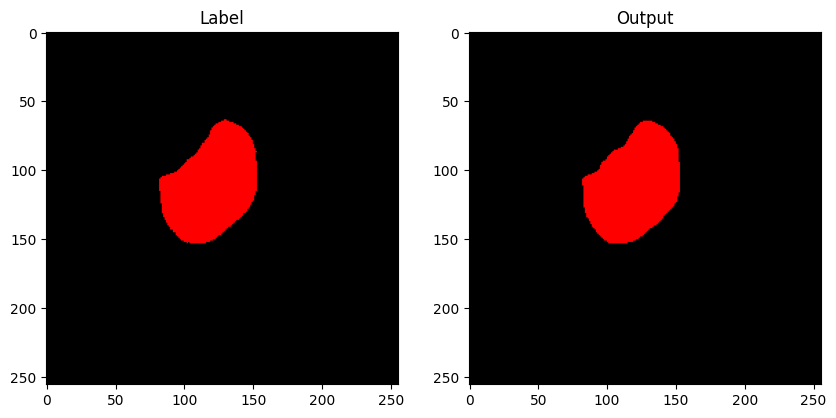

Epoch [222/300], Loss: 0.1137087424


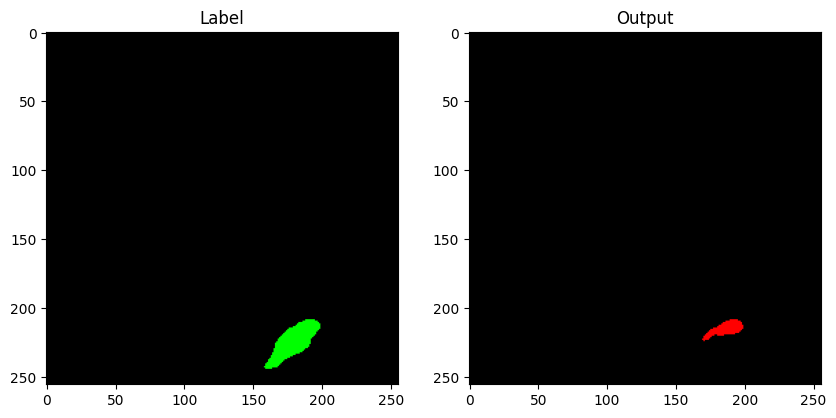

Epoch [223/300], Loss: 0.1271168802


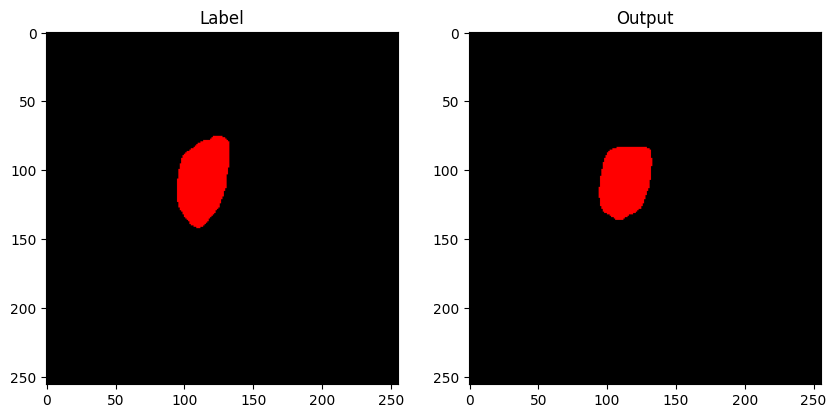

Epoch [224/300], Loss: 0.1185701700


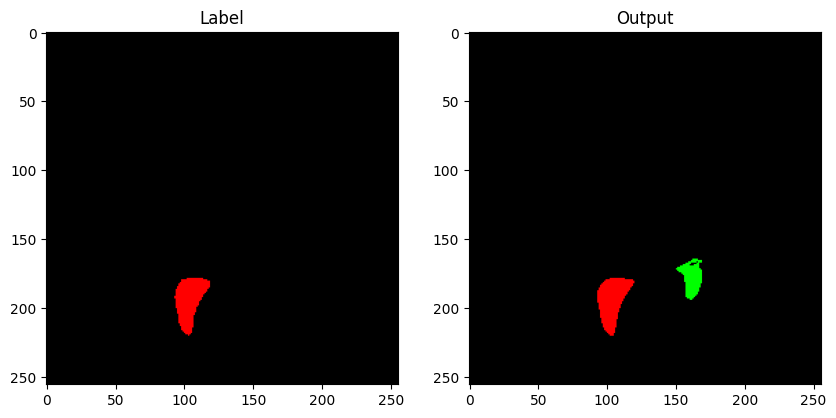

Epoch [225/300], Loss: 0.1198312209


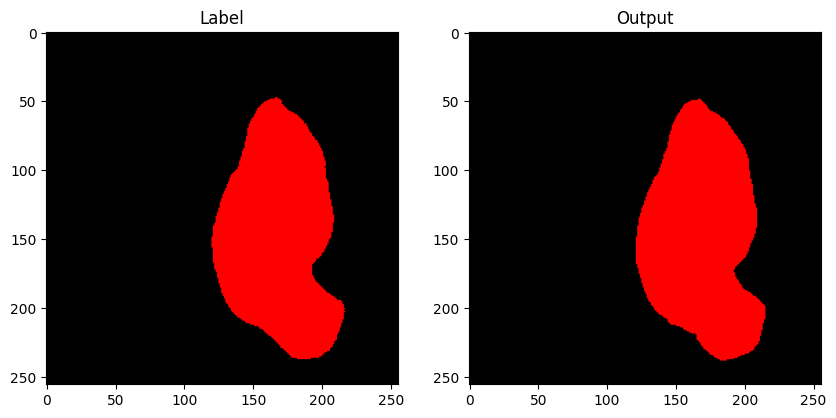

Epoch [226/300], Loss: 0.1266339974


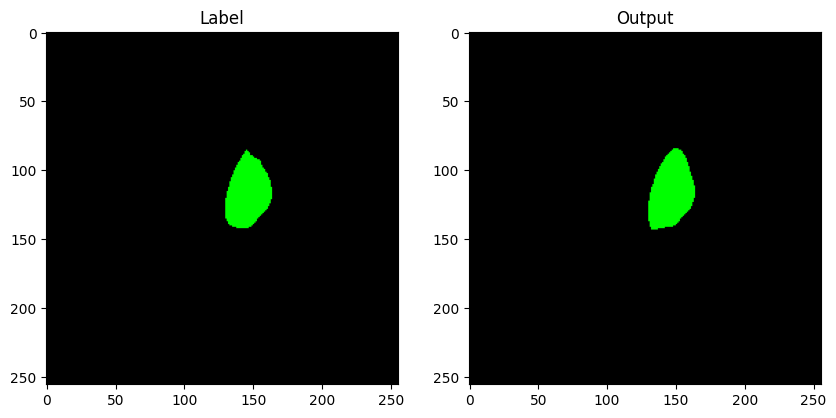

Epoch [227/300], Loss: 0.0998488478


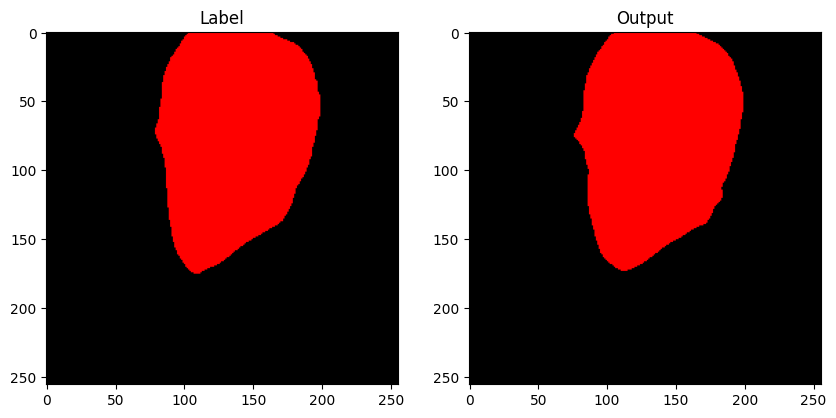

Epoch [228/300], Loss: 0.1492161626


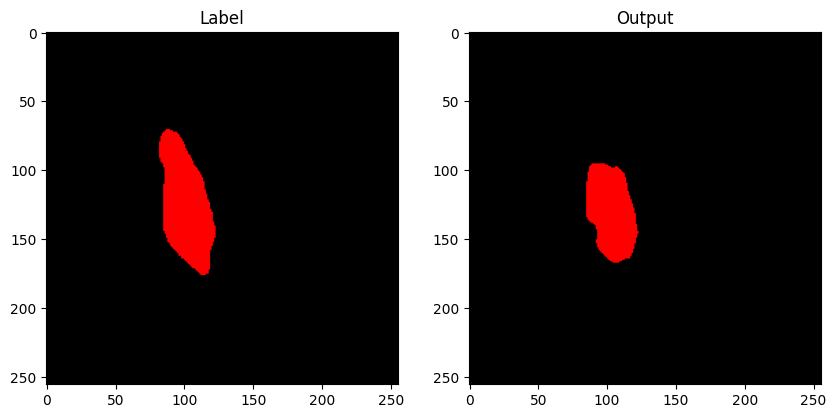

Epoch [229/300], Loss: 0.1440094984


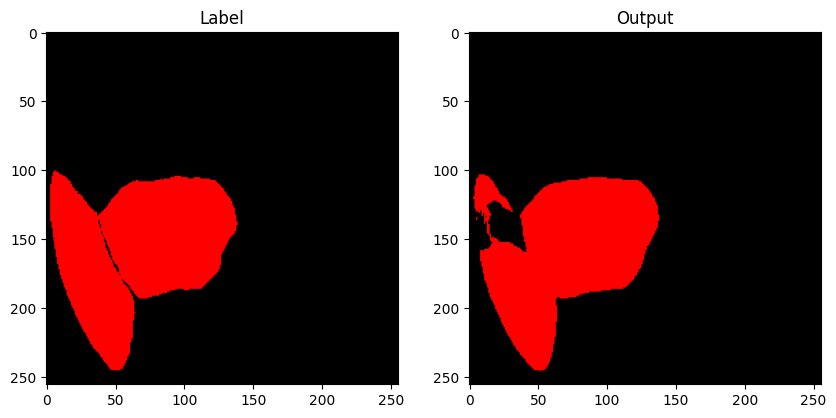

Epoch [230/300], Loss: 0.1236179742


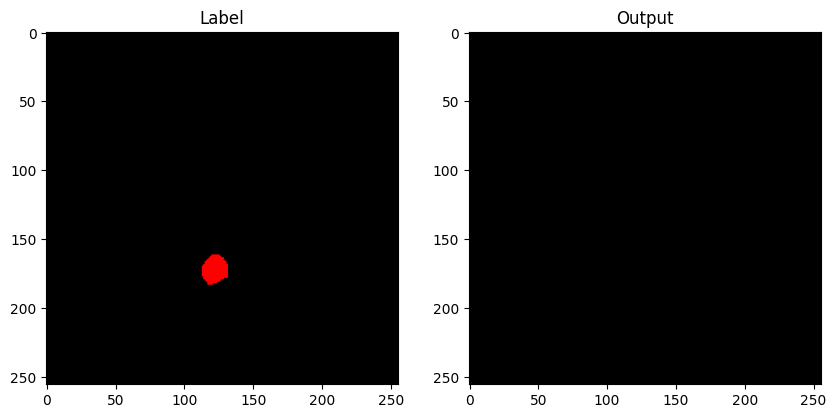

Epoch [231/300], Loss: 0.1113397285


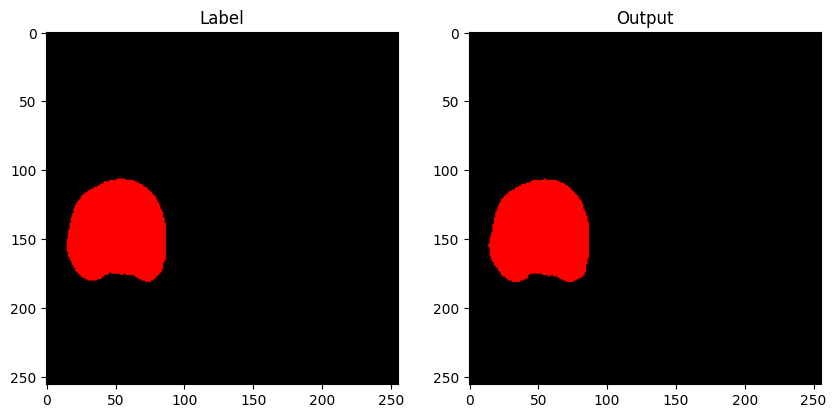

Epoch [232/300], Loss: 0.1452448274


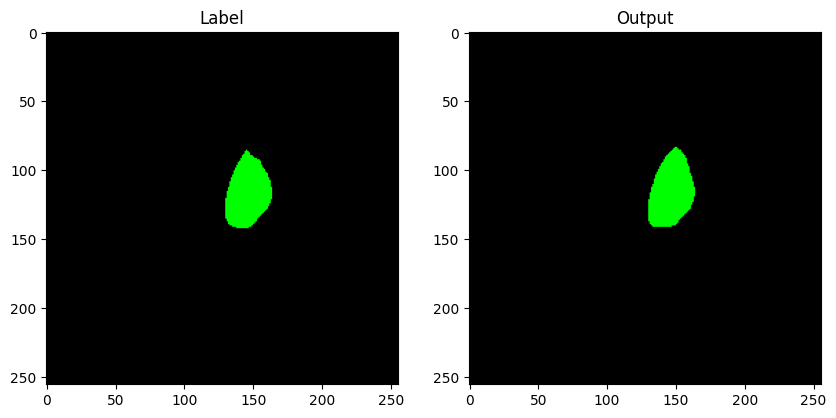

Epoch [233/300], Loss: 0.1361796271


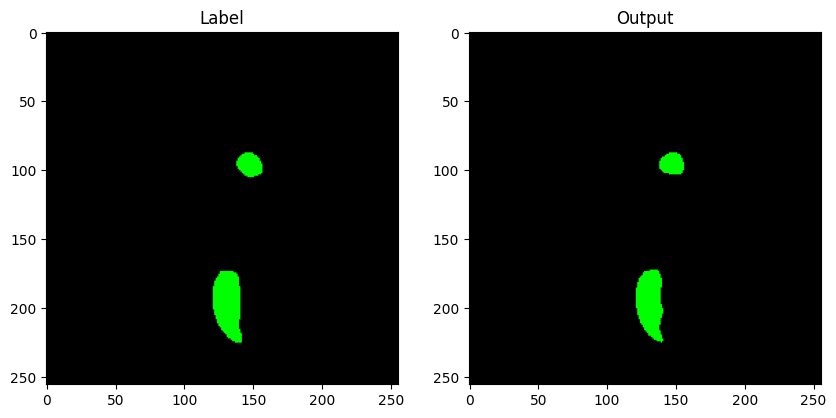

Epoch [234/300], Loss: 0.1359930752


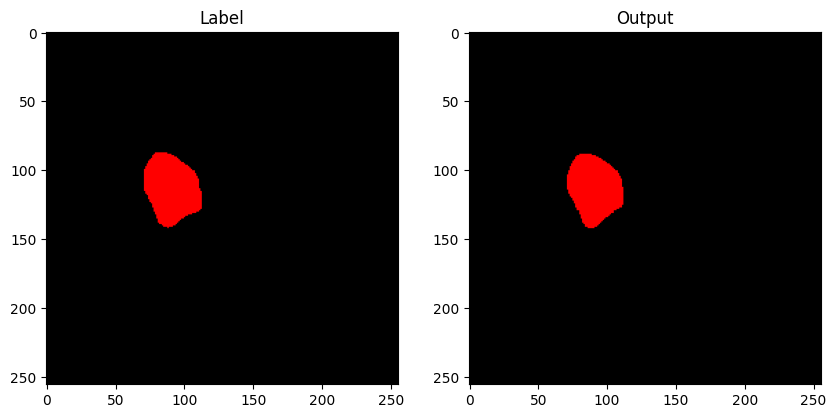

Epoch [235/300], Loss: 0.1362834149


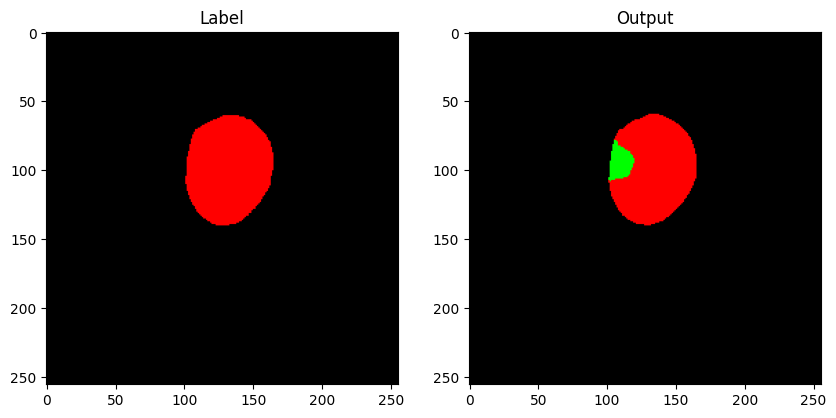

Epoch [236/300], Loss: 0.1427643127


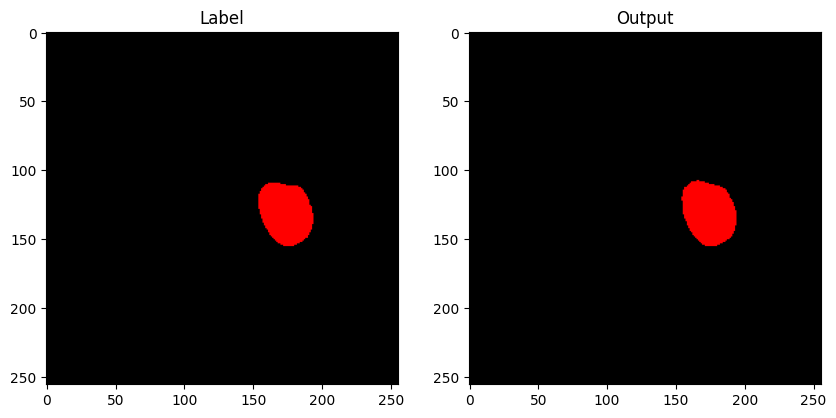

Epoch [237/300], Loss: 0.1454294718


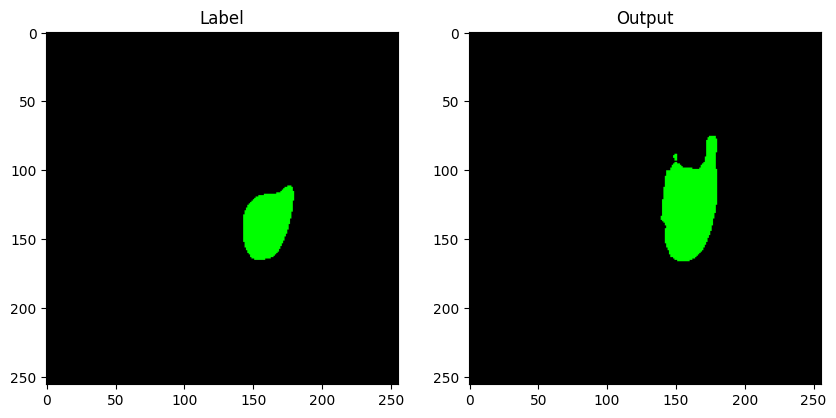

Epoch [238/300], Loss: 0.1356104587


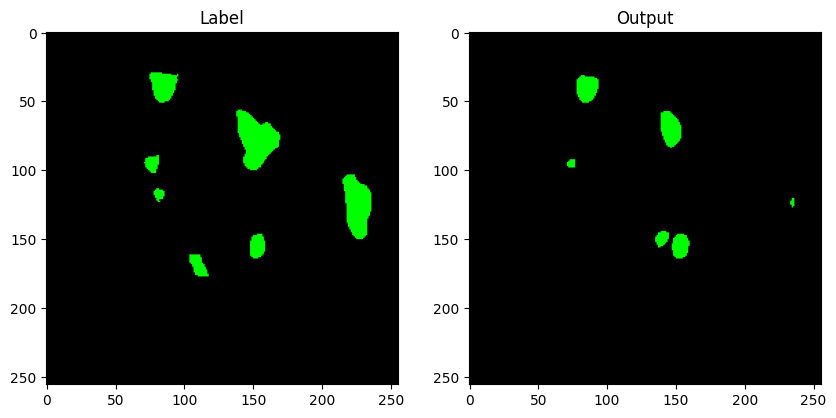

Epoch [239/300], Loss: 0.1435708341


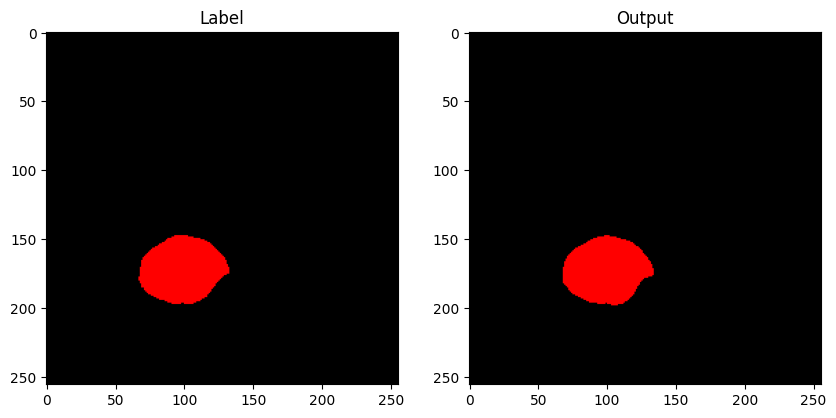

Epoch [240/300], Loss: 0.1504722854


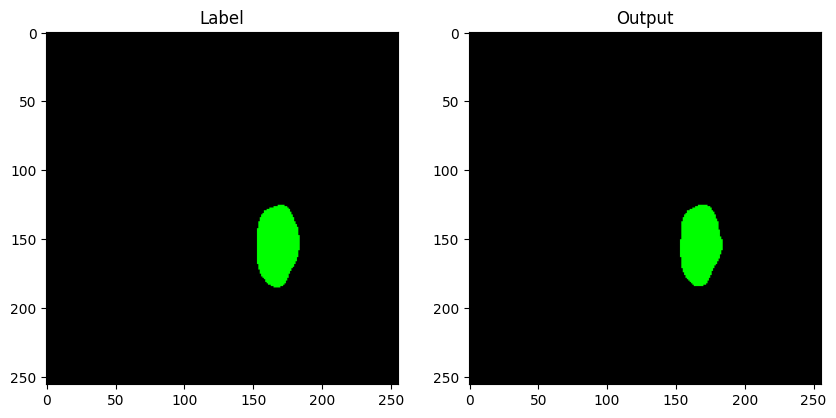

Epoch [241/300], Loss: 0.1246280593


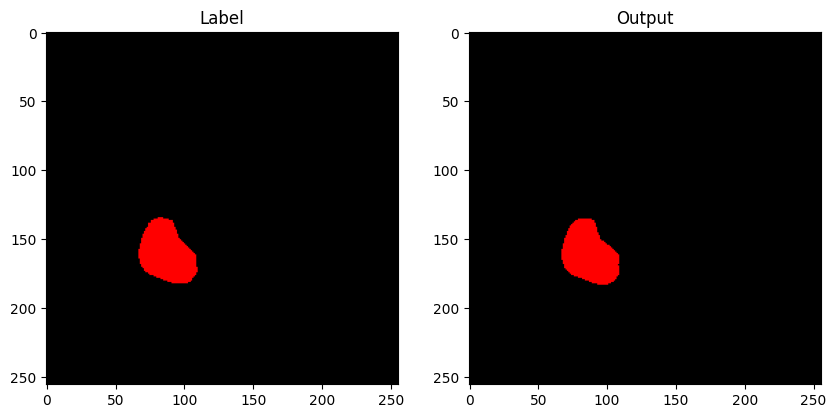

Epoch [242/300], Loss: 0.1370099439


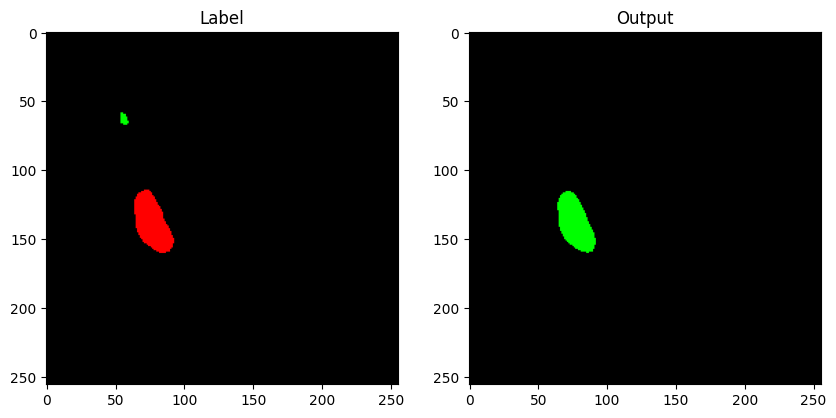

Epoch [243/300], Loss: 0.1166641893


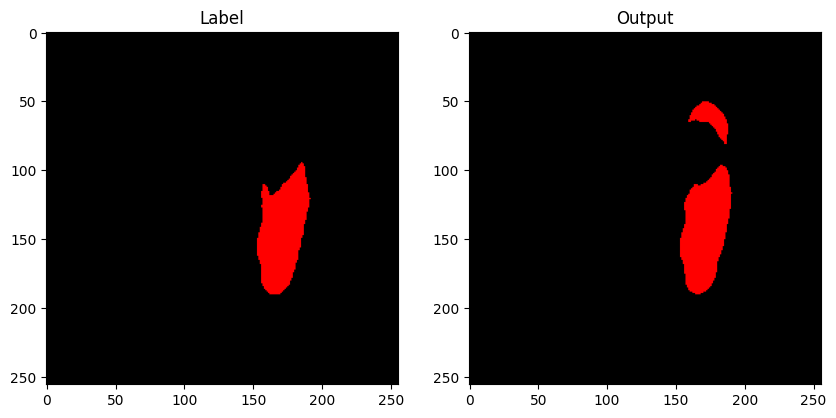

Epoch [244/300], Loss: 0.1234863051


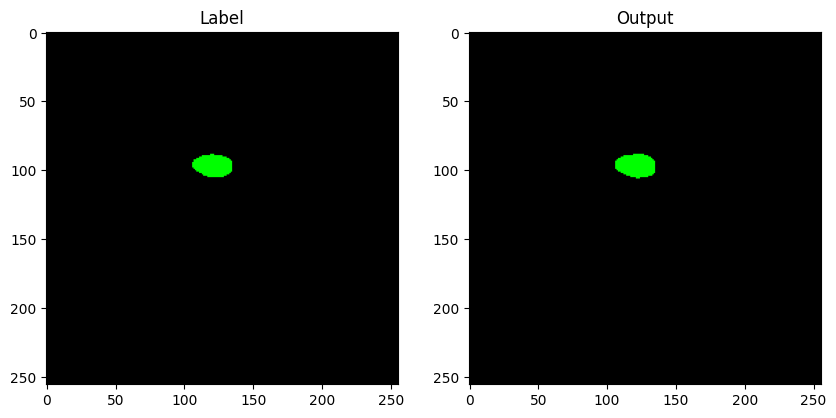

Epoch [245/300], Loss: 0.1164485153


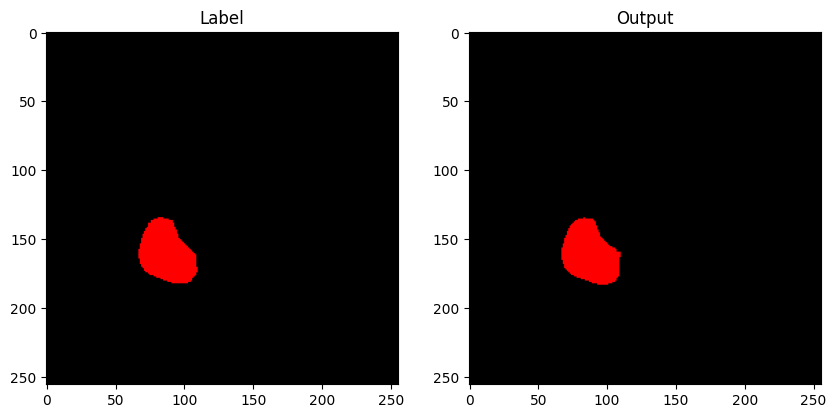

Epoch [246/300], Loss: 0.1553991958


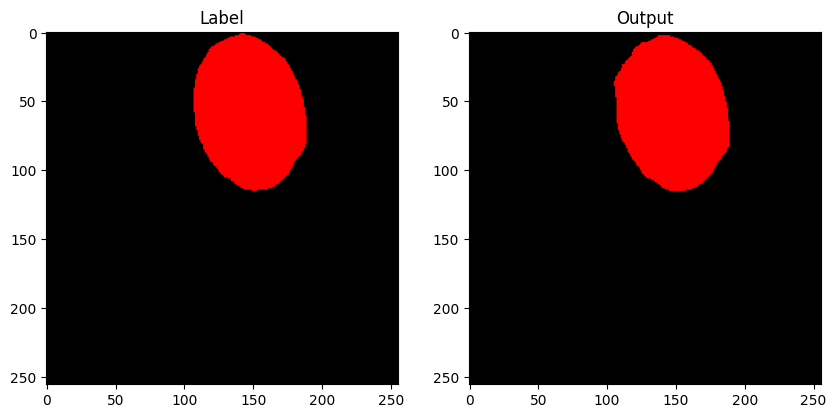

Epoch [247/300], Loss: 0.1373236682


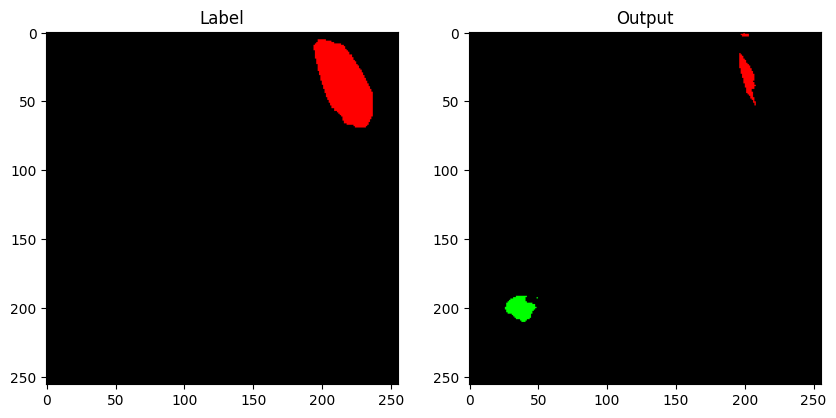

Epoch [248/300], Loss: 0.1344290992


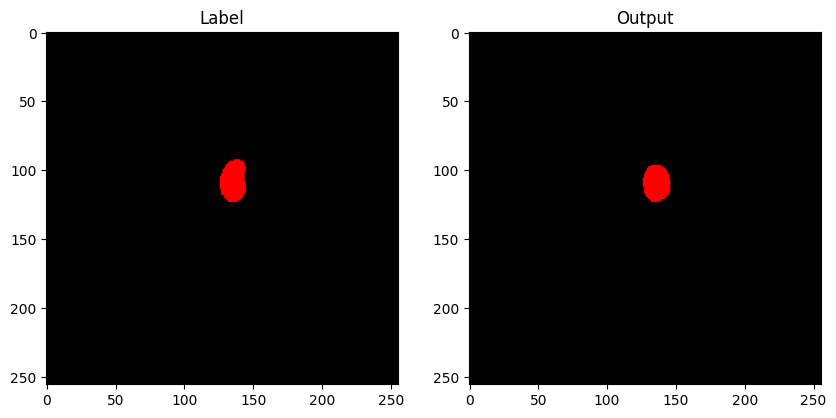

Epoch [249/300], Loss: 0.1397197444


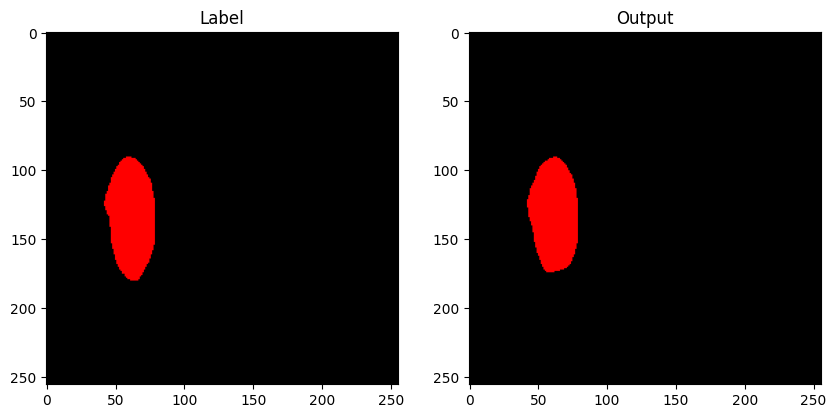

Epoch [250/300], Loss: 0.1375262603


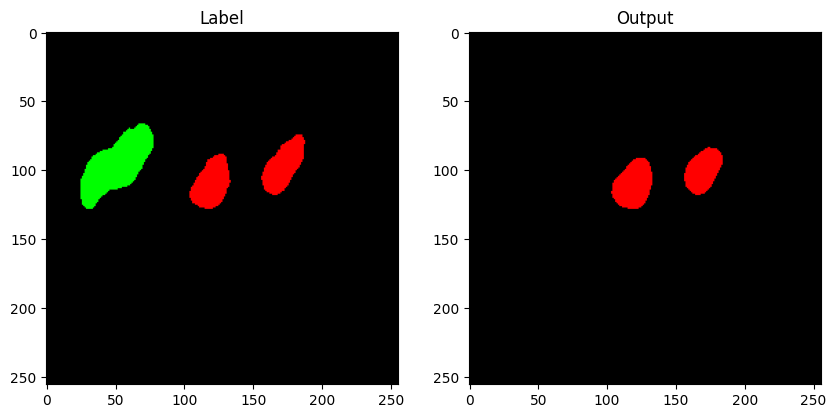

Epoch [251/300], Loss: 0.1369596393


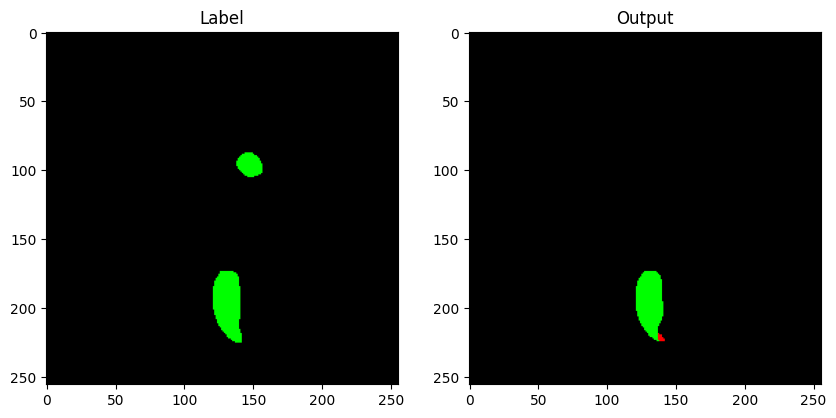

Epoch [252/300], Loss: 0.1407744664


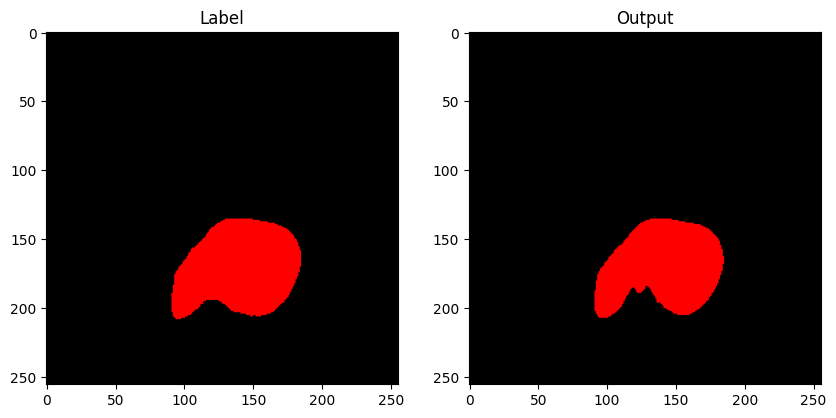

Epoch [253/300], Loss: 0.1560466989
Epoch [255/300], Loss: 0.1375799437


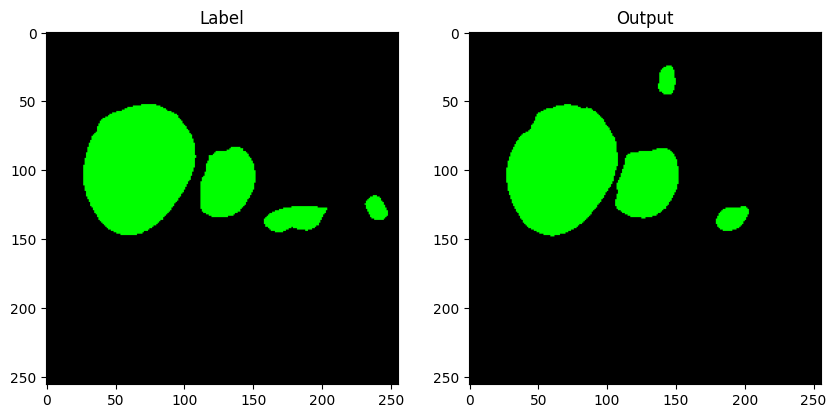

Epoch [256/300], Loss: 0.1429597032


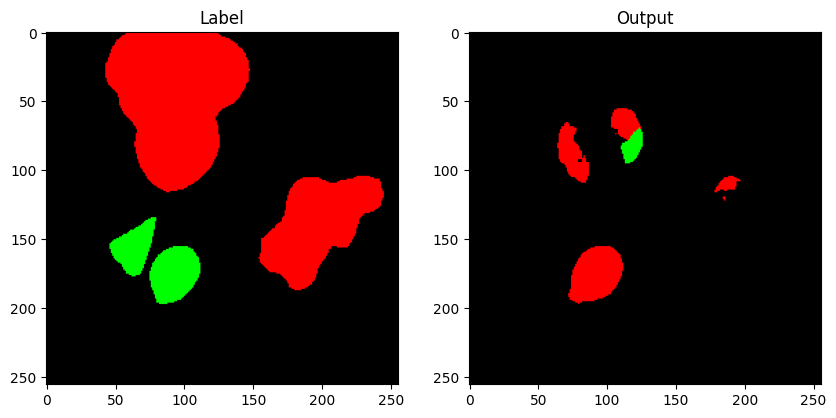

Epoch [257/300], Loss: 0.1642651890


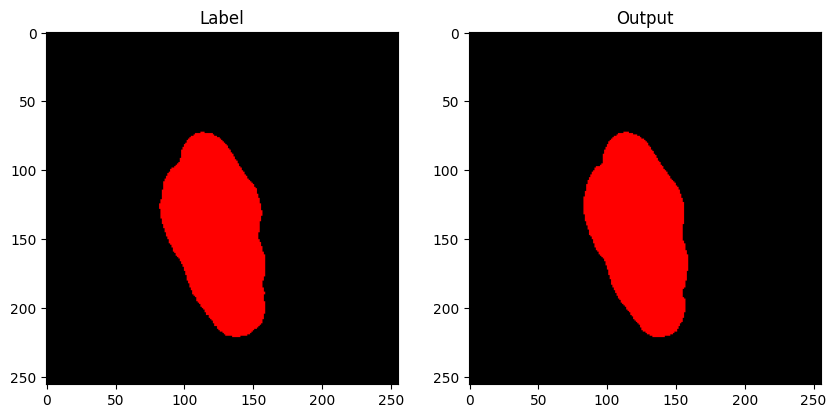

Epoch [258/300], Loss: 0.1412960436


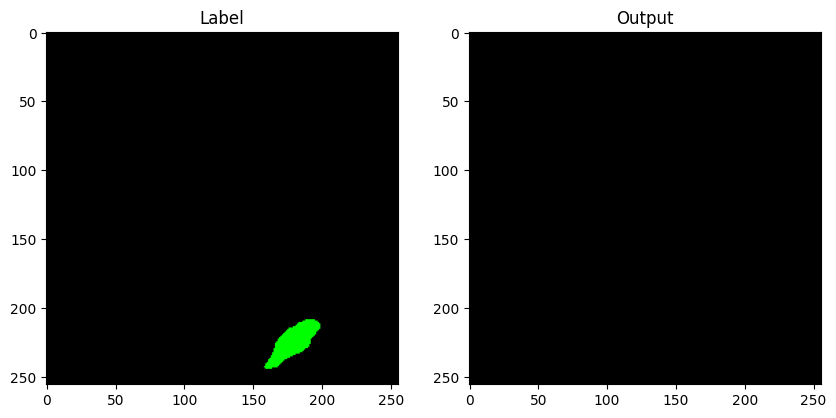

Epoch [259/300], Loss: 0.1397313205


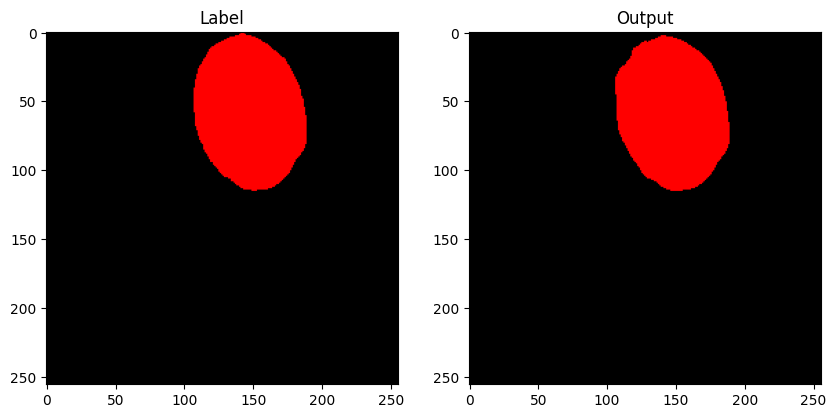

Epoch [260/300], Loss: 0.1321003843


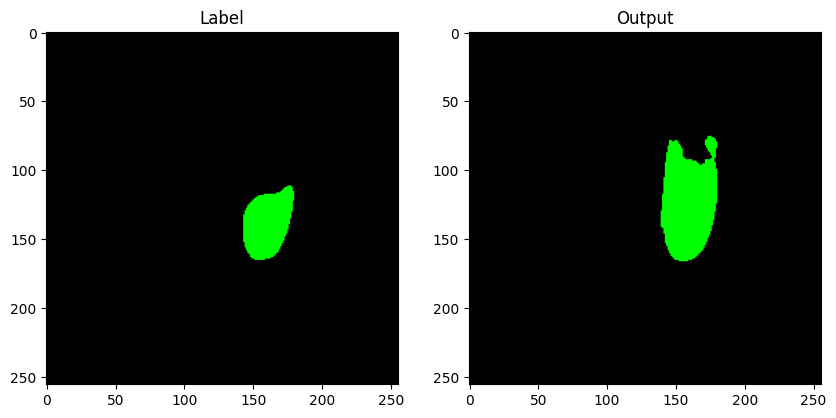

Epoch [261/300], Loss: 0.1621506673


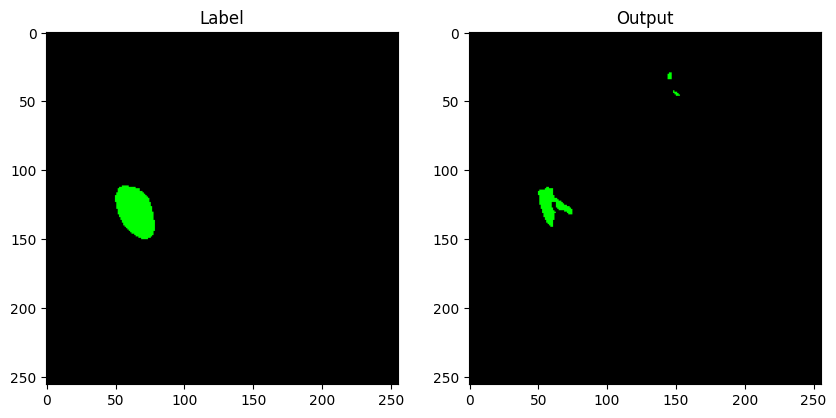

Epoch [262/300], Loss: 0.1584096249


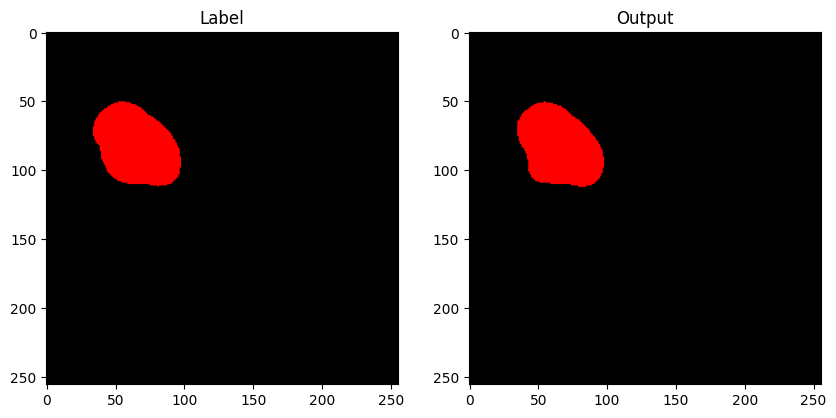

Epoch [263/300], Loss: 0.1338674861


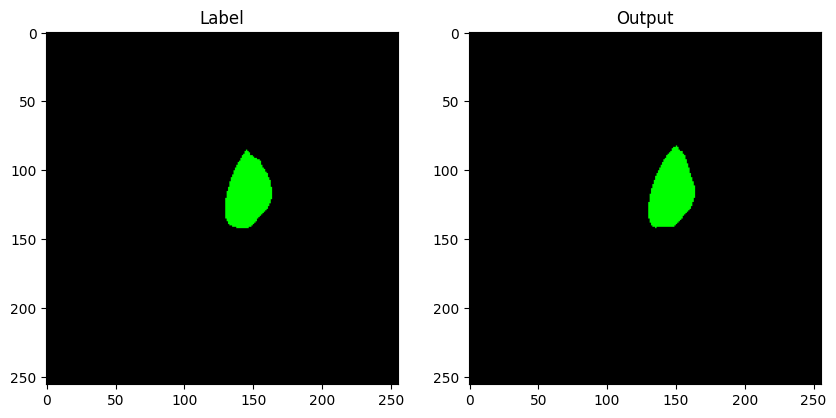

Epoch [264/300], Loss: 0.1421351126


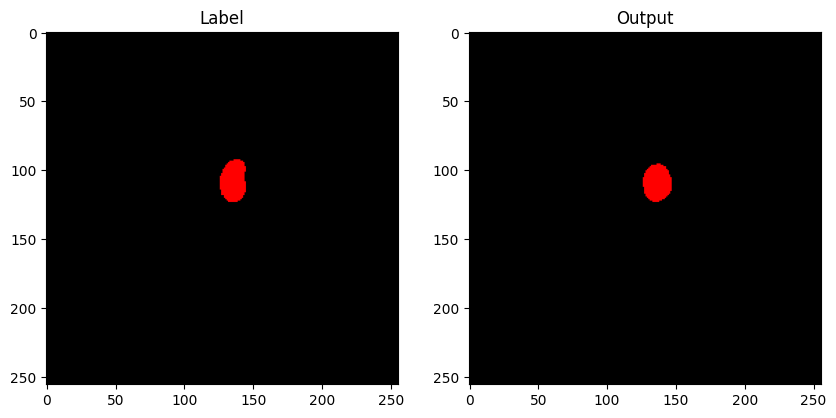

Epoch [265/300], Loss: 0.1147707575


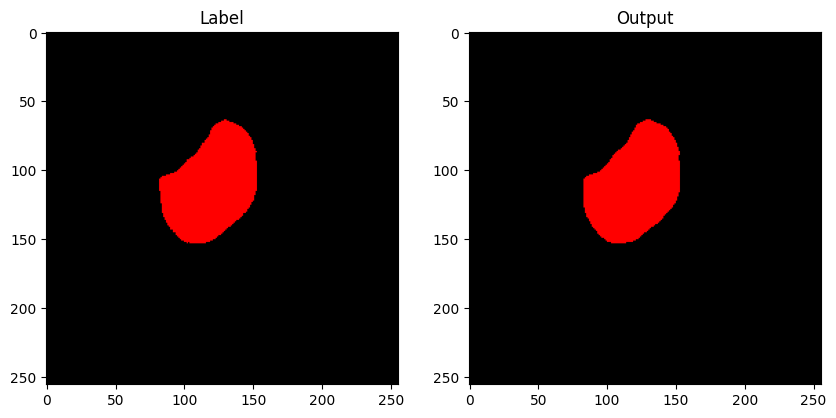

Epoch [266/300], Loss: 0.1154209703


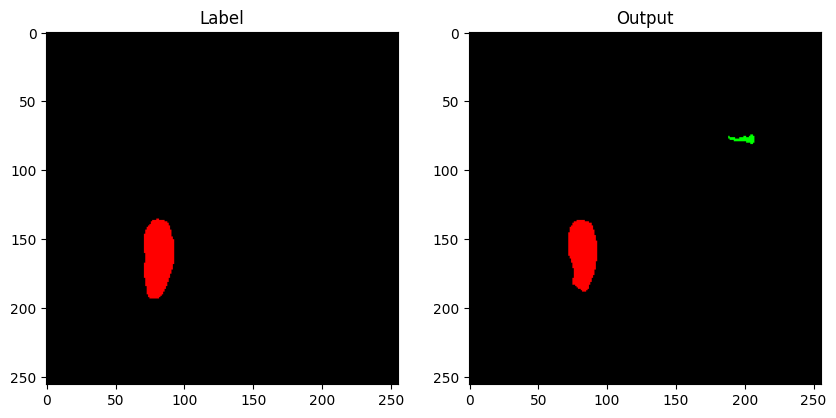

Epoch [267/300], Loss: 0.1303252022


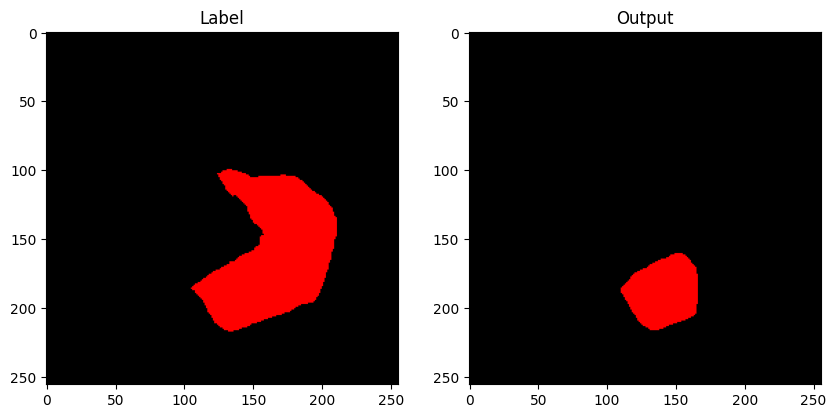

Epoch [268/300], Loss: 0.1341642171


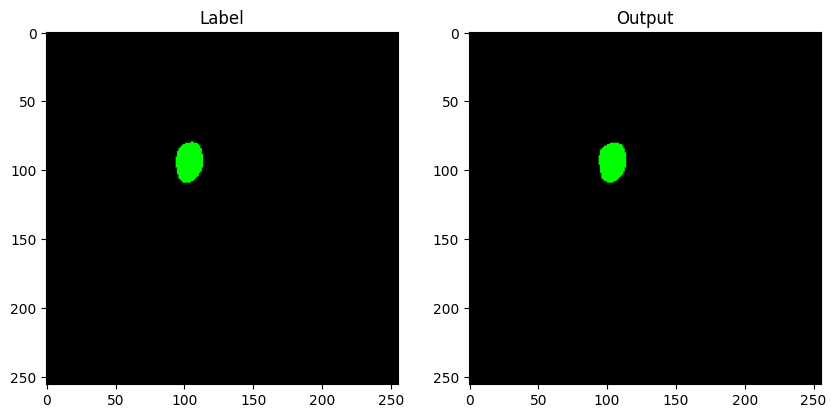

Epoch [269/300], Loss: 0.1847789614


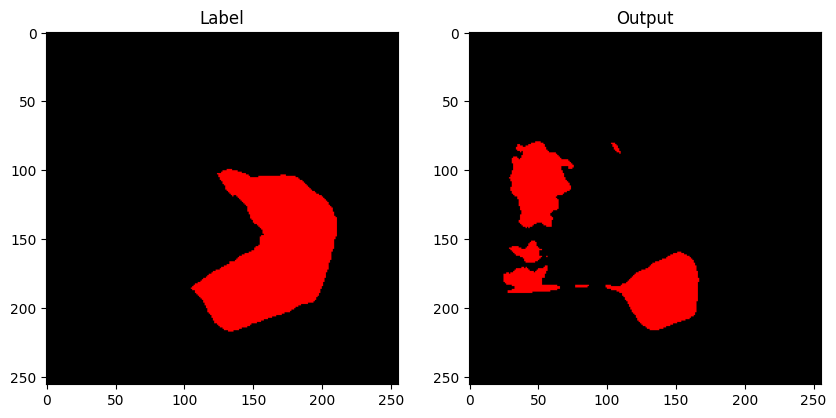

Epoch [270/300], Loss: 0.1457089647


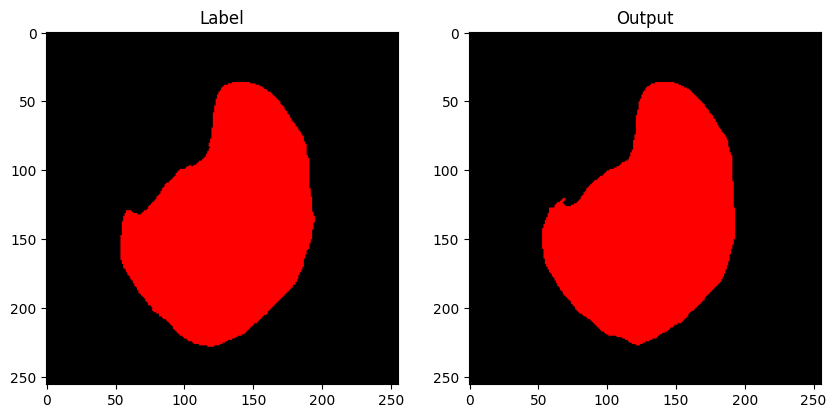

Epoch [271/300], Loss: 0.1663154601


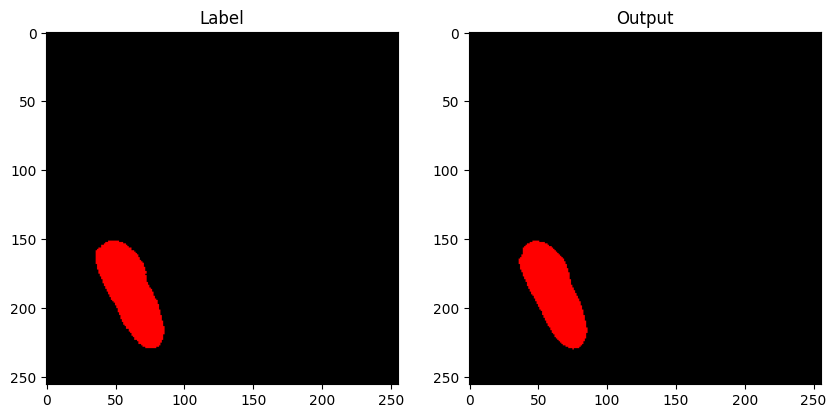

Epoch [272/300], Loss: 0.1554006481


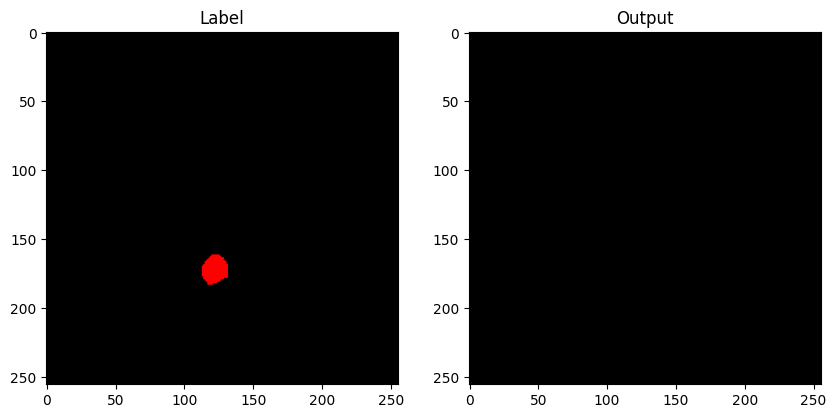

Epoch [273/300], Loss: 0.1396780148


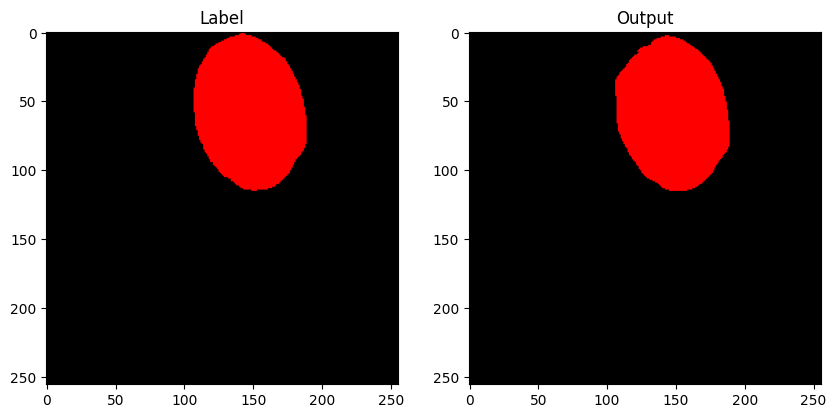

Epoch [274/300], Loss: 0.1657390600


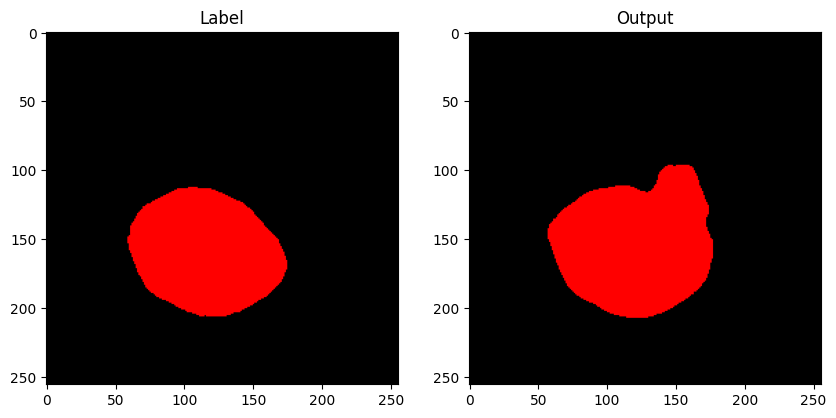

Epoch [275/300], Loss: 0.1545051266


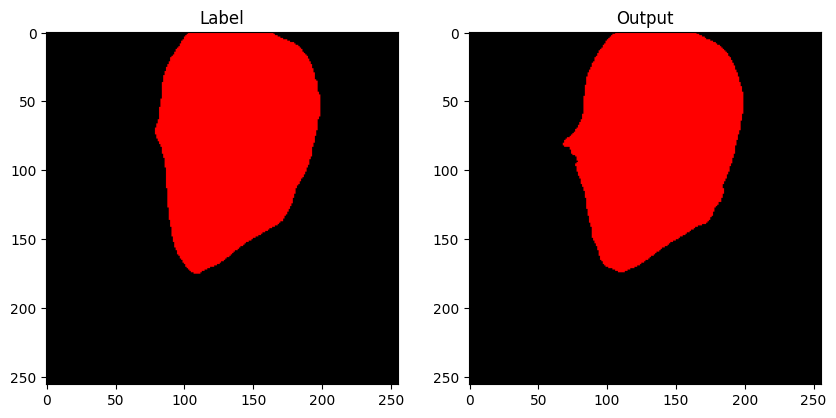

Epoch [276/300], Loss: 0.1501639795


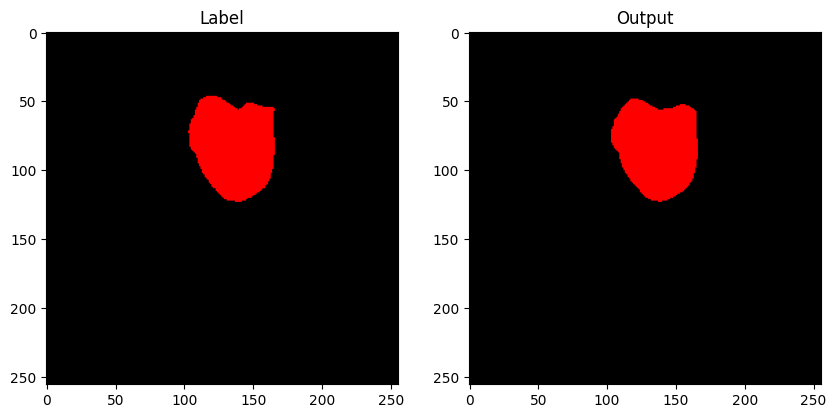

Epoch [277/300], Loss: 0.1661483327


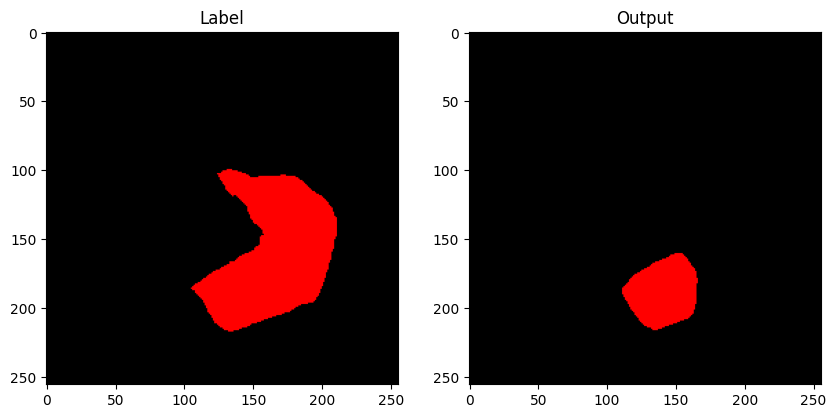

Epoch [278/300], Loss: 0.1258780741


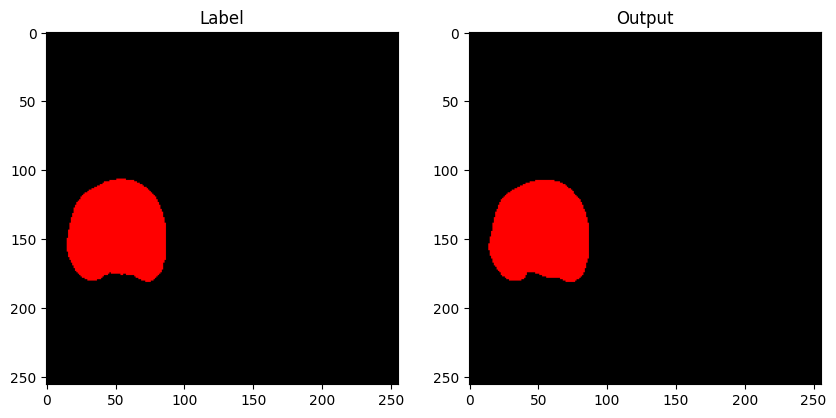

Epoch [279/300], Loss: 0.1458022371


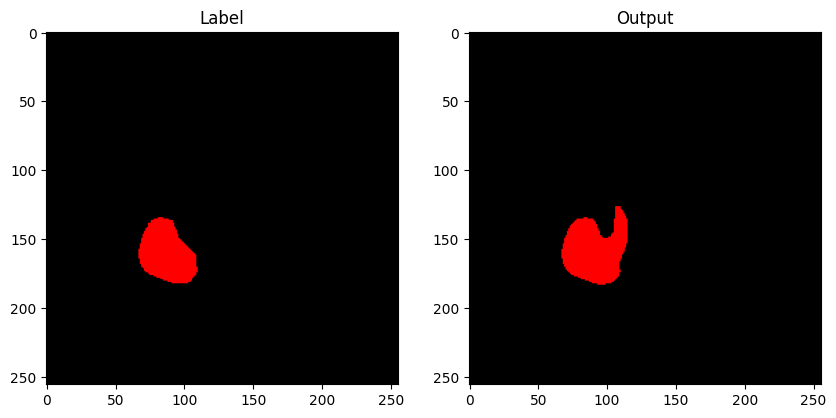

Epoch [280/300], Loss: 0.1504879928


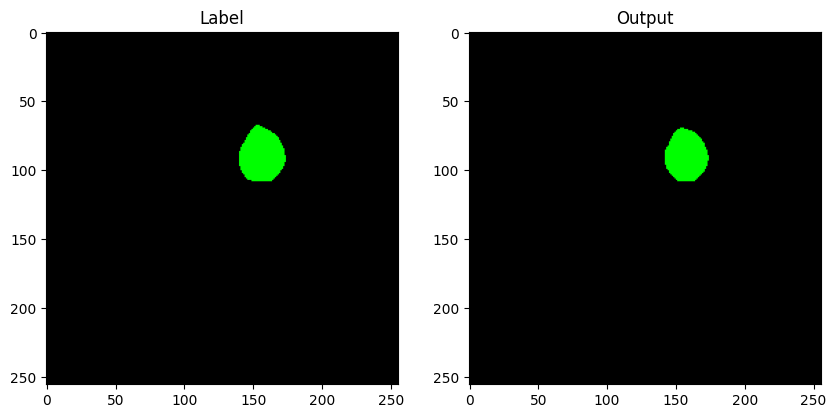

Epoch [281/300], Loss: 0.1656026665


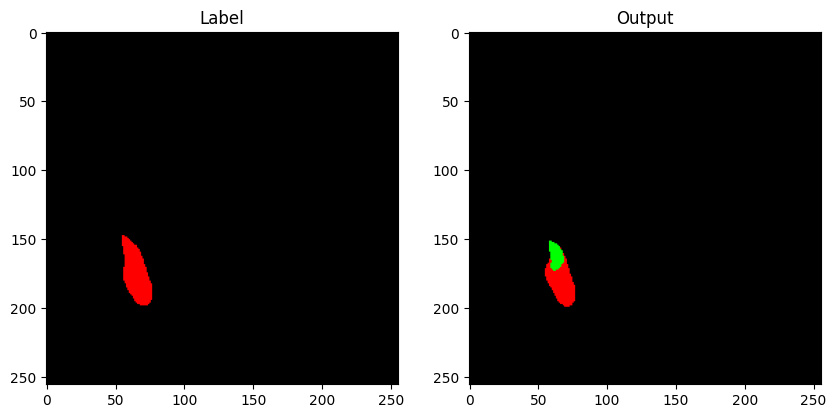

Epoch [282/300], Loss: 0.1425819656


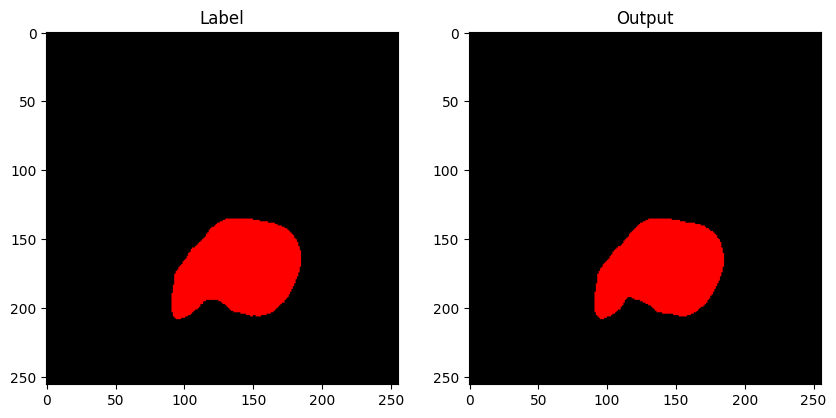

Epoch [283/300], Loss: 0.1568097197


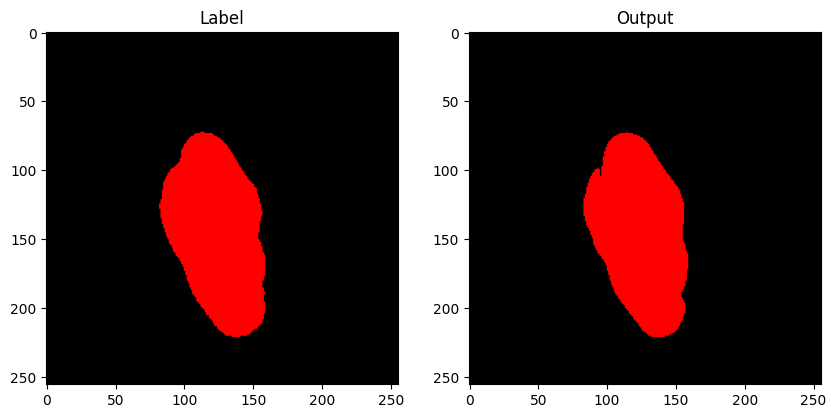

Epoch [284/300], Loss: 0.1806563447


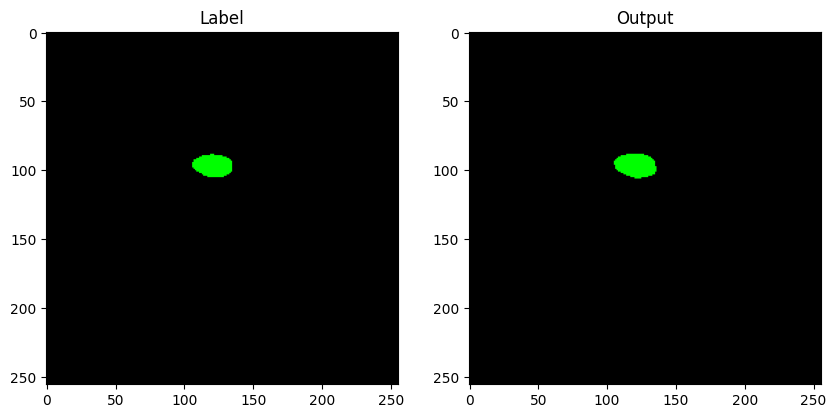

Epoch [285/300], Loss: 0.1754951403


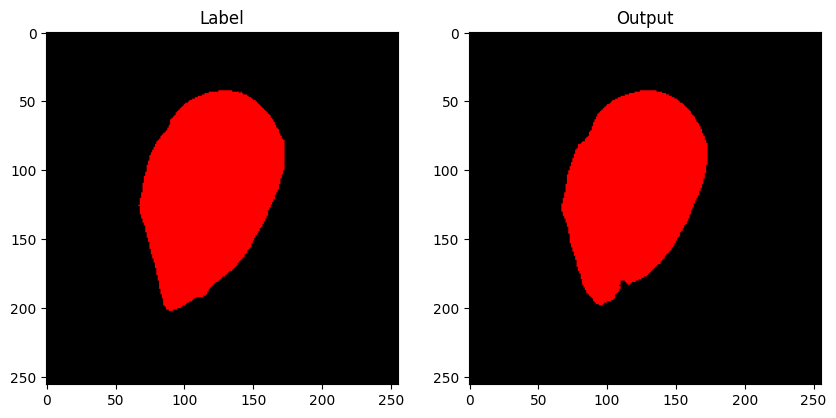

Epoch [286/300], Loss: 0.1406494186


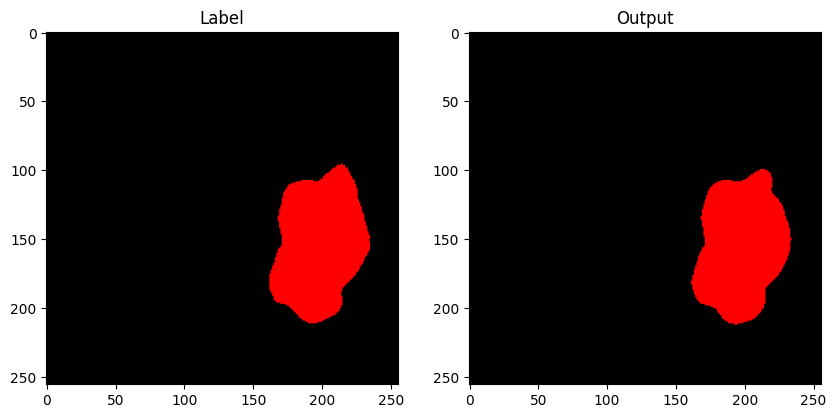

Epoch [287/300], Loss: 0.1592070225


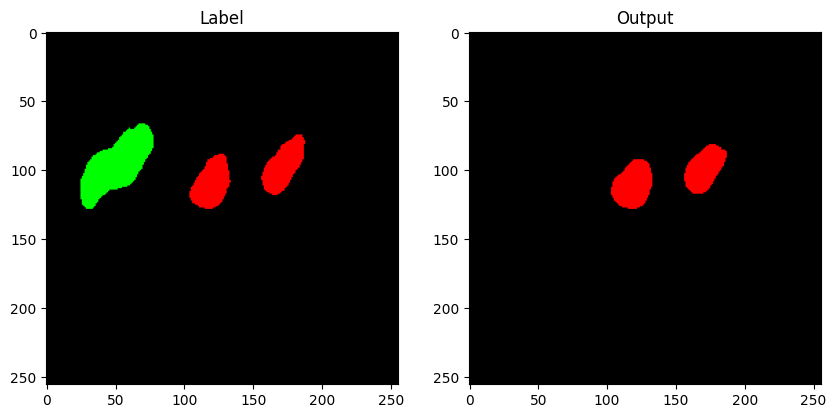

Epoch [288/300], Loss: 0.1755203192


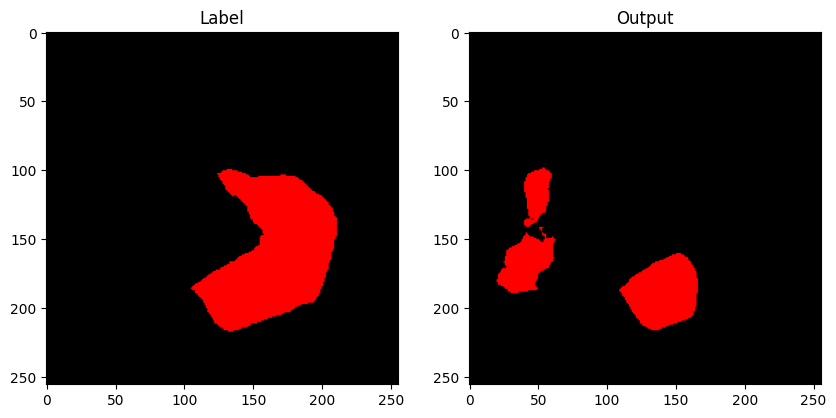

Epoch [289/300], Loss: 0.1344870769


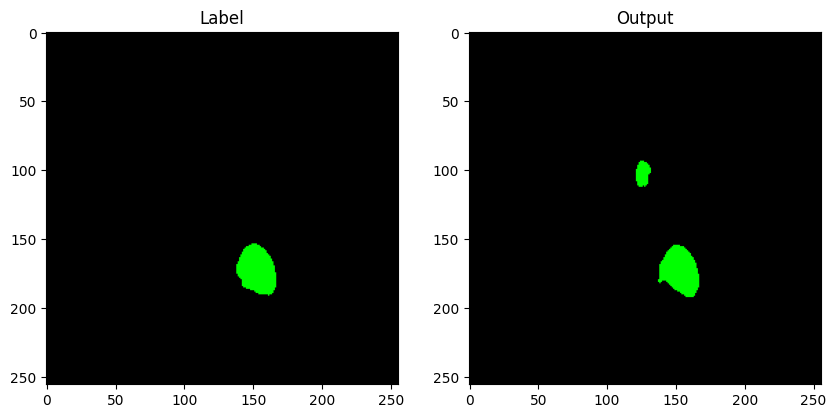

Epoch [290/300], Loss: 0.1436994993


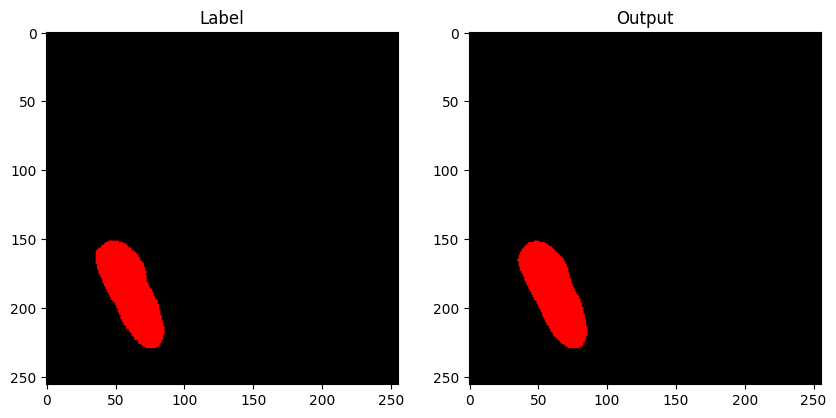

Epoch [291/300], Loss: 0.1530910480


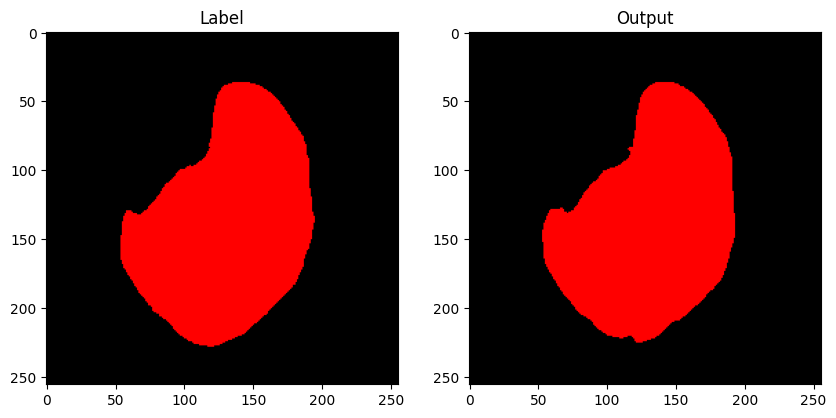

Epoch [292/300], Loss: 0.1449626285


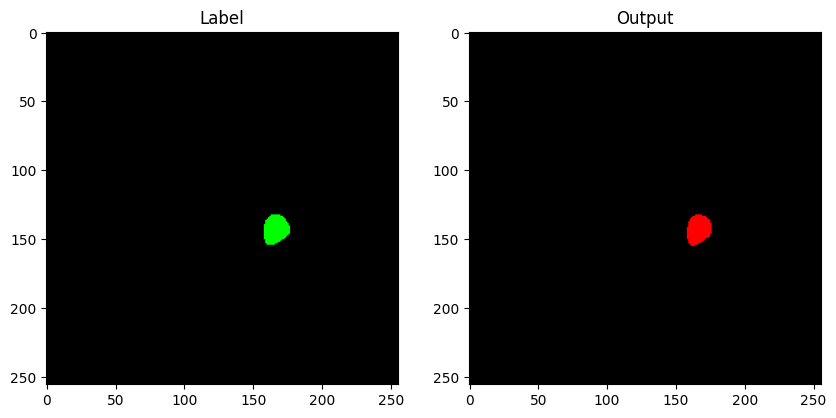

Epoch [293/300], Loss: 0.1600560523


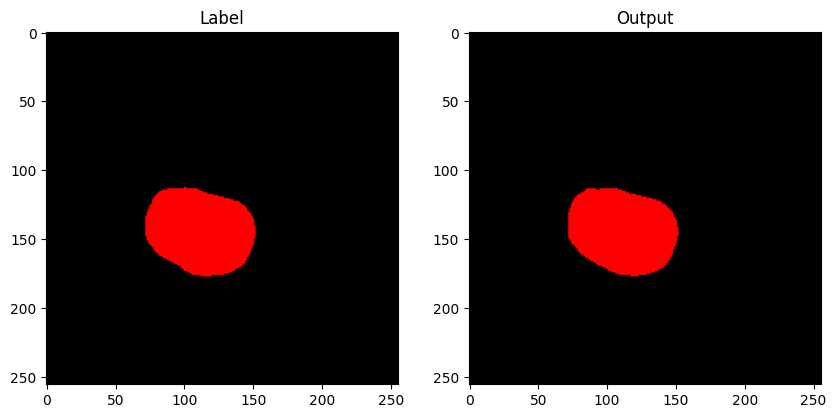

Epoch [294/300], Loss: 0.1602394793


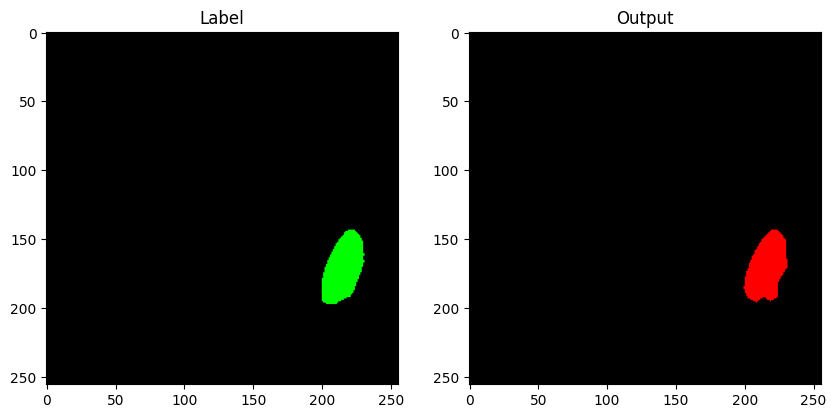

Epoch [295/300], Loss: 0.1428350780


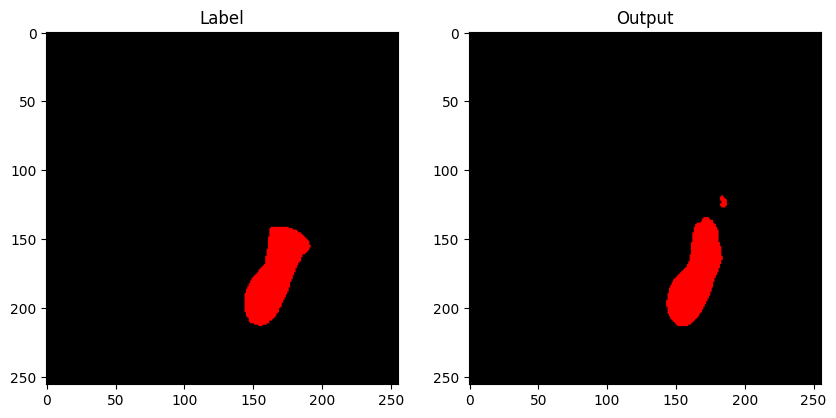

Epoch [296/300], Loss: 0.1501790861


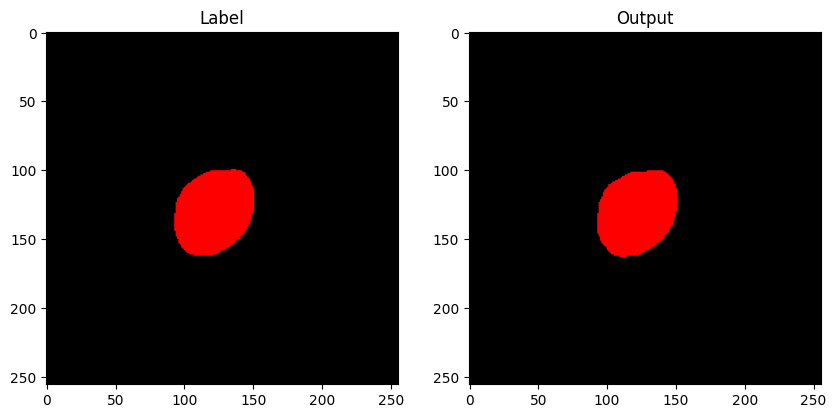

Epoch [297/300], Loss: 0.1274255684


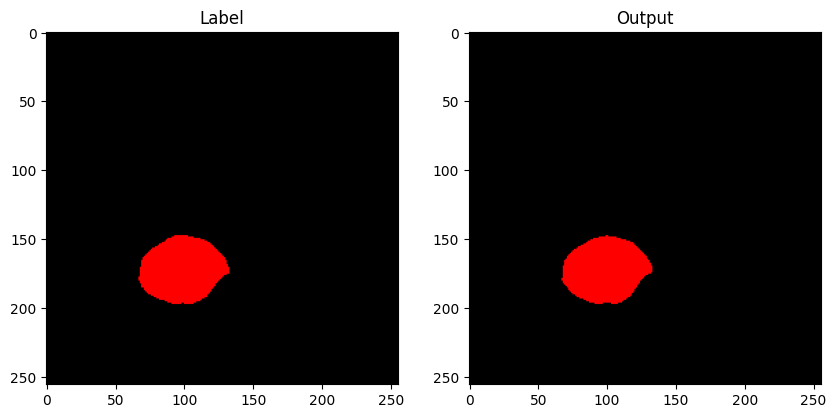

Epoch [298/300], Loss: 0.1398970831


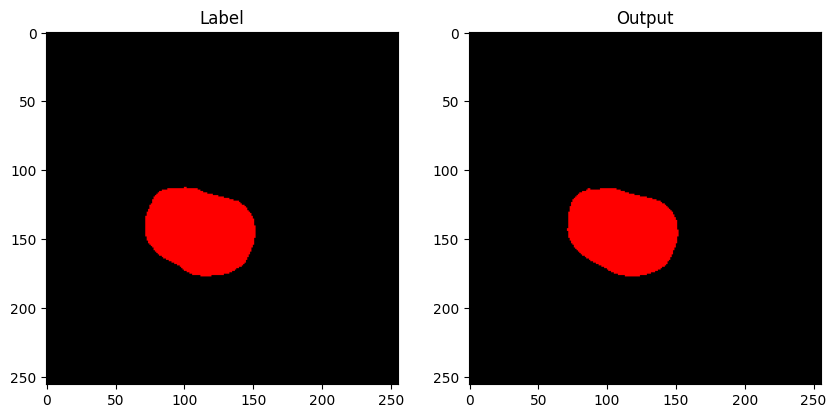

Epoch [299/300], Loss: 0.1320813196


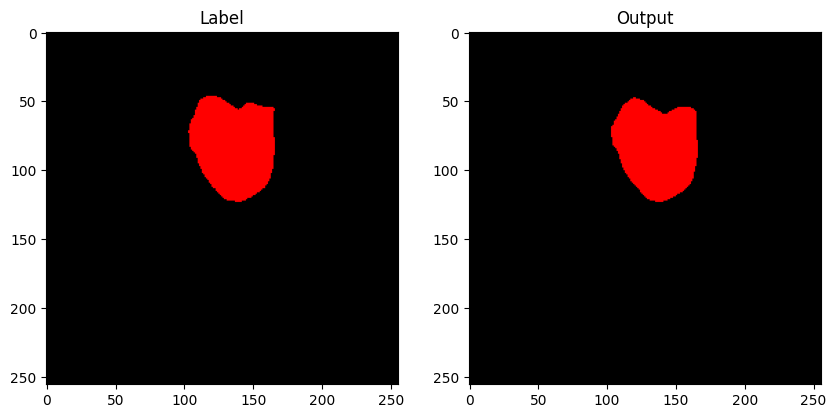

Epoch [300/300], Loss: 0.1253786359


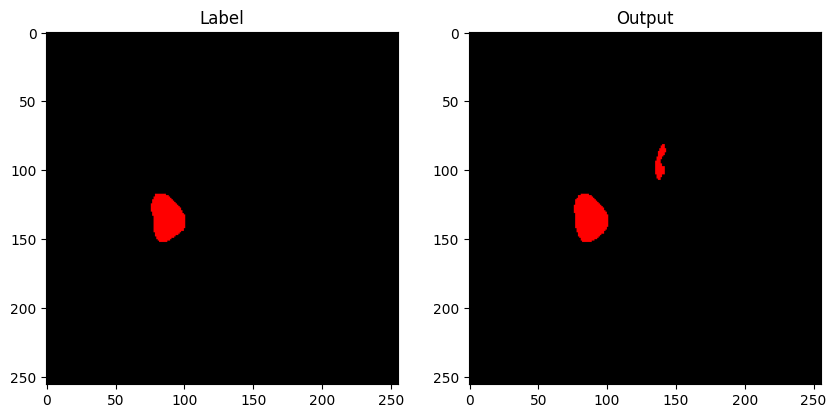

In [16]:
num_epochs = 300

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)
dice_loss = DiceLoss(mode='multiclass')
criterion = lambda outputs, labels: 0.5 * nn.CrossEntropyLoss()(outputs, labels) + 0.5 * dice_loss(outputs, labels)
best_val_loss = 999

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        labels = labels.squeeze(dim=1).long()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.squeeze(dim=1).long()

            outputs = model(images)

            val_loss += criterion(outputs.float(),labels.long()).item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss/len(val_loader):.10f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = {'epoch': epoch, 'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'loss': val_loss,}
        save_path = f'colorization_model.pth'
        torch.save(checkpoint, save_path)
        print('Save new model')
    wandb.log({'Val_loss': val_loss/len(val_loader), 'Train_loss': train_loss/len(train_loader)})

    label = labels[0].cpu().numpy()
    label = mask_to_rgb(label,color_dict)
    outputs[0] = outputs[0].softmax(dim=0)
    output = outputs[0].cpu().numpy()
    output = np.argmax(output, axis=0)
    output = mask_to_rgb(output,color_dict)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(label)
    axs[0].set_title('Label')
    axs[1].imshow(output)
    axs[1].set_title('Output')
    plt.show()

In [17]:
checkpoint = torch.load('/kaggle/working/colorization_model.pth')
model.load_state_dict(checkpoint['model'])
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)

UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          64, 16, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          16, 64, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticS

In [18]:
!mkdir prediction

In [19]:
trainsize = 256
model.eval()
for i in os.listdir("/kaggle/input/bkai-igh-neopolyp/test/test"):
    img_path = os.path.join("/kaggle/input/bkai-igh-neopolyp/test/test", i)
    ori_img = cv2.imread(img_path)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    ori_w = ori_img.shape[0]
    ori_h = ori_img.shape[1]
    img = cv2.resize(ori_img, (trainsize, trainsize))
    transformed = val_transform(image=img)
    input_img = transformed["image"]
    input_img = input_img.unsqueeze(0).to(device)
    with torch.no_grad():
        output_mask = model.forward(input_img).squeeze(0).cpu().numpy().transpose(1,2,0)
    mask = cv2.resize(output_mask, (ori_h, ori_w))
    mask = np.argmax(mask, axis=2)
    mask_rgb = mask_to_rgb(mask, color_dict)
    mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite("prediction/{}".format(i), mask_rgb)

In [20]:
def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 225] = 255
    pixels[pixels <= 225] = 0
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]

    return rle_to_string(rle)

def rle2mask(mask_rle, shape=(3,3)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2string(dir):
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '/kaggle/working/prediction'
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']

df.to_csv(r'output.csv', index=False)
print('Done')

/kaggle/working/prediction/a9d45c3dbc695325ded465efde988dfb.jpeg
/kaggle/working/prediction/e4a17af18f72c8e6166a915669c99390.jpeg
/kaggle/working/prediction/ff05dec1eb3a70b145a7d8d3b6c0ed75.jpeg
/kaggle/working/prediction/dd094a7f32574d6c748c41743c6c08a1.jpeg
/kaggle/working/prediction/60b246359c68c836f843dcf41f4dce3c.jpeg
/kaggle/working/prediction/8fa8625605da2023387fd56c04414eaa.jpeg
/kaggle/working/prediction/df8e26031fbb5e52c41545ba55aadaa7.jpeg
/kaggle/working/prediction/f62f215f0da4ad3a7ab8df9da7386835.jpeg
/kaggle/working/prediction/cb1b387133b51209db6dcdda5cc8a788.jpeg
/kaggle/working/prediction/2cd066b9fdbc3bbc04a3afe1f119f21b.jpeg
/kaggle/working/prediction/3bbc04a3afe1f119f21b248d152b672a.jpeg
/kaggle/working/prediction/df366e057db382b8564872a27301a654.jpeg
/kaggle/working/prediction/5b21960c94b0aab4c024a573c692195f.jpeg
/kaggle/working/prediction/a3657e4314fe384eb2ba3adfda6c1899.jpeg
/kaggle/working/prediction/4e2a6e51d077bad31c8c5f54ffaa27a6.jpeg
/kaggle/working/predictio